### 1️⃣ Setup + Imports

In [ ]:
# 1️⃣ Unmount just in case
from google.colab import drive
try:
    drive.flush_and_unmount()
except Exception as e:
    print("Drive was not mounted — continuing.")

# 2️⃣ Remove the stale directory that’s blocking the mount
!rm -rf /content/drive

# 3️⃣ Now mount fresh

# Mount Drive once per session
from google.colab import drive
drive.mount('/content/drive')

import sys, os

#  Add project path so Python can find src/
project_path = "/content/drive/MyDrive/Colab Notebooks/project"
if project_path not in sys.path:
    sys.path.append(project_path)

# Confirm it's there
print("Path added:", project_path in sys.path)

# Now import
import src.data as data_mod
import src.models as models_mod
import src.train as train_mod


# reload in case they were imported earlier
import importlib
importlib.reload(data_mod)
importlib.reload(models_mod)
importlib.reload(train_mod)

from src.data import (
    load_dataframe, load_indices, standardize_train_fit, standardize_apply,
    make_windows, inverse_target, INPUT_FEATURES, TARGET_FEATURE, HORIZONS
)
from src.models import build_lstm, build_gru, build_cnn1d
from src.train  import callbacks, evaluate

print("Imports OK ✅")



# ---- paths ----
BASE = "/content/drive/MyDrive/Colab Notebooks/project"
DATA = f"{BASE}/data"
SPLITS = f"{BASE}/splits"
RUNS = f"{BASE}/runs"

TRANSFORMERS = {
    "trans_1": f"{DATA}/trans_1.csv",
    "trans_2": f"{DATA}/trans_2.csv",
}

# Make output dir
import os
os.makedirs(RUNS, exist_ok=True)

# ---- imports ----
import numpy as np, pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models

# Print variables to confirm they are defined
print(f"BASE: {BASE}")
print(f"DATA: {DATA}")
print(f"SPLITS: {SPLITS}")
print(f"RUNS: {RUNS}")
print(f"TRANSFORMERS: {TRANSFORMERS}")

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive
Path added: True
Imports OK ✅
BASE: /content/drive/MyDrive/Colab Notebooks/project
DATA: /content/drive/MyDrive/Colab Notebooks/project/data
SPLITS: /content/drive/MyDrive/Colab Notebooks/project/splits
RUNS: /content/drive/MyDrive/Colab Notebooks/project/runs
TRANSFORMERS: {'trans_1': '/content/drive/MyDrive/Colab Notebooks/project/data/trans_1.csv', 'trans_2': '/content/drive/MyDrive/Colab Notebooks/project/data/trans_2.csv'}


### (extra) Visualisations setup

In [ ]:
# (optional) for architecture diagrams
!apt-get -qq install graphviz >/dev/null
!pip -q install pydot graphviz ipywidgets >/dev/null

import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from IPython.display import Image, display
import tensorflow as tf
import ipywidgets as W

plt.rcParams["figure.figsize"] = (9,4)
plt.rcParams["axes.grid"] = True

# ---------- helpers (purely for viz) ----------
def plot_model_arch(model, out_png):
    tf.keras.utils.plot_model(model, to_file=out_png, show_shapes=True, dpi=130)
    display(Image(filename=out_png))

def plot_history(history_dict, title="Training curves"):
    df = pd.DataFrame(history_dict)
    ax = df[[c for c in df.columns if "loss" in c]].plot(title=title)
    ax.set_ylabel("Loss"); plt.show()
    mae_cols = [c for c in df.columns if "mae" in c]
    if mae_cols:
        df[mae_cols].plot(title="MAE"); plt.ylabel("MAE"); plt.show()
    if "lr" in df.columns:
        df["lr"].plot(title="Learning rate"); plt.ylabel("LR"); plt.show()

def inverse_C(z, mu, sd): return z * sd + mu

def line_preds(y_true_z, y_pred_z, mu, sd, start=0, length=500, title="Predictions vs Actual (°C)"):
    s = slice(start, start+length)
    yC = inverse_C(y_true_z, mu, sd); pC = inverse_C(y_pred_z, mu, sd)
    plt.plot(yC[s], label="Actual OT (°C)")
    plt.plot(pC[s], label="Pred OT (°C)")
    plt.title(title); plt.xlabel("Sample index"); plt.ylabel("°C")
    plt.legend(); plt.tight_layout(); plt.show()

def residual_plots(y_true_z, y_pred_z, mu, sd):
    yC = inverse_C(y_true_z, mu, sd); pC = inverse_C(y_pred_z, mu, sd)
    r  = yC - pC
    pd.Series(r).plot(kind="hist", bins=40, alpha=0.8, title="Residuals (°C)")
    plt.xlabel("Error (°C)"); plt.show()
    plt.scatter(pC, r, s=6, alpha=0.3)
    plt.axhline(0, color="k", lw=1)
    plt.title("Residual vs Predicted (°C)"); plt.xlabel("Predicted (°C)"); plt.ylabel("Residual (°C)")
    plt.show()

# shared cache for comparisons (no model edits needed)
RUNS_CACHE = {}  # key: (HKEY, MODEL_NAME) -> dict(yte, pred_z, hist)



###2️⃣ Load Data & Splits

In [ ]:
# 1) Load dataframes and split indices
dfs = {}
idxs = {}

for tf_name, path in TRANSFORMERS.items():
    dfs[tf_name] = pd.read_csv(path)
    idxs[tf_name] = load_indices(f"{SPLITS}/{tf_name}")
    print(tf_name, dfs[tf_name].shape, {k: len(v) for k,v in idxs[tf_name].items()})

# Sanity: expected columns
INPUTS = INPUT_FEATURES  # ["HUFL","HULL","MUFL","MULL","LUFL","LULL"]
TARGET = TARGET_FEATURE  # "OT"



trans_1 (69680, 8) {'train': 48176, 'val': 6720, 'test': 14784}
trans_2 (69680, 8) {'train': 48176, 'val': 6720, 'test': 14784}


### 3️⃣ Load dataframes and split indices

In [ ]:
# ------------------------------------------------------------
# STEP 3️⃣: Load CSVs (raw transformer data) and the pre-saved row indices for each split
# ------------------------------------------------------------

dfs = {}   # will hold full DataFrames (raw CSVs)
idxs = {}  # will hold index dictionaries {train, val, test}

for tf_name, path in TRANSFORMERS.items():
    # Load the transformer data CSV
    dfs[tf_name] = pd.read_csv(path)

    # Load train/val/test row indices from splits folder
    idxs[tf_name] = load_indices(f"{SPLITS}/{tf_name}")

    # Print shapes and split sizes to confirm everything lines up
    print(tf_name, dfs[tf_name].shape, {k: len(v) for k,v in idxs[tf_name].items()})

# Define feature and target columns
INPUTS = INPUT_FEATURES  # the 6 load features only
TARGET = TARGET_FEATURE  # OT (Oil Temperature) – the prediction target


trans_1 (69680, 8) {'train': 48176, 'val': 6720, 'test': 14784}
trans_2 (69680, 8) {'train': 48176, 'val': 6720, 'test': 14784}


### 4️⃣ Standardise (Z-score) using train only (inputs & target separately)

In [ ]:
# ------------------------------------------------------------
# STEP 4️⃣: Standardise (Z-score) per transformer, using its TRAIN only
# Why: trans_1 and trans_2 live on very different scales (even signs for some
#      features). Fitting global μ/σ squashes one transformer and hurts learning.
# Result: zdfs[t] holds the z-scored dataframe for transformer t,
#         stats[t] stores the μ/σ used so we can invert later consistently.
# ------------------------------------------------------------
from src.data import standardize_train_fit, standardize_apply
import json, os

zdfs  = {}
stats = {}   # {t: {"in": {col:(mu,sd)}, "tg_mu": float, "tg_sd": float}}

for t in TRANSFORMERS:  # e.g. "trans_1", "trans_2"
    tr_idx = idxs[t]["train"]
    df_t   = dfs[t]

    # 1) Fit stats on this transformer's TRAIN rows only
    in_stats_t  = standardize_train_fit(df_t.loc[tr_idx, INPUTS], INPUTS)              # inputs μ/σ per feature
    out_stats_t = standardize_train_fit(df_t.loc[tr_idx, [TARGET]], [TARGET])          # target μ/σ
    tg_mu_t, tg_sd_t = out_stats_t[TARGET]

    stats[t] = {"in": in_stats_t, "tg_mu": float(tg_mu_t), "tg_sd": float(tg_sd_t)}

    # 2) Apply those stats to FULL dataframe (train/val/test) for this transformer
    Xz = standardize_apply(df_t[INPUTS], in_stats_t)
    yz = standardize_apply(df_t[[TARGET]], {TARGET: (tg_mu_t, tg_sd_t)})
    zdfs[t] = pd.concat([Xz, yz], axis=1)

    # 3) Quick sanity: target (OT) in TRAIN should be ~N(0,1)
    m = float(zdfs[t].loc[tr_idx, TARGET].mean())
    s = float(zdfs[t].loc[tr_idx, TARGET].std())
    print(f"{t}: OT_z on TRAIN → mean={m:.3f}, std={s:.3f}  (≈ 0/1 is good)")

# 4) (Optional) Save z-scored CSVs + the stats used (per transformer)
for t in TRANSFORMERS:
    # z-scored data (handy for quick inspection)
    z_path = f"{DATA}/{t}_zscore.csv"
    zdfs[t].to_csv(z_path, index=False)

    # stats JSON (critical so viz/prediction uses the SAME μ/σ as training)
    s_path = f"{RUNS}/{t}/{t}_zscore_stats_{HKEY if 'HKEY' in globals() else 'all'}.json"
    os.makedirs(os.path.dirname(s_path), exist_ok=True)
    payload = {
        "input_stats": {c: {"mu": mu, "sd": sd} for c, (mu, sd) in stats[t]["in"].items()},
        "target_stats": {"mu": stats[t]["tg_mu"], "sd": stats[t]["tg_sd"]}
    }
    with open(s_path, "w") as f:
        json.dump(payload, f, indent=2)
    print(f"Saved: {z_path} and {s_path}")

# 5) Convenience: pick which transformer's target μ/σ to expose for viz cells
#    (Change 'trans_1' to 'trans_2' when visualising that transformer.)
tg_mu, tg_sd = stats["trans_1"]["tg_mu"], stats["trans_1"]["tg_sd"]
print("tg_mu/tg_sd now set for:", "trans_1")


trans_1: OT_z on TRAIN → mean=-0.000, std=1.000  (≈ 0/1 is good)
trans_2: OT_z on TRAIN → mean=-0.000, std=1.000  (≈ 0/1 is good)
Saved: /content/drive/MyDrive/Colab Notebooks/project/data/trans_1_zscore.csv and /content/drive/MyDrive/Colab Notebooks/project/runs/trans_1/trans_1_zscore_stats_t+24h.json
Saved: /content/drive/MyDrive/Colab Notebooks/project/data/trans_2_zscore.csv and /content/drive/MyDrive/Colab Notebooks/project/runs/trans_2/trans_2_zscore_stats_t+24h.json
tg_mu/tg_sd now set for: trans_1


### 5️⃣ Build leakage-safe time-series windows




In [ ]:
# ------------------------------------------------------------
# STEP 5 (memory-safe): Build windows horizon-by-horizon using NumPy.
# - float32 (half the memory of float64)
# - stride to reduce the #samples (try 4 for 15-min → 1-hr step)
# - build per horizon, not all at once

# Goal Convert each transformer's z-scored dataset into (X, y) pairs

# ------------------------------------------------------------
import numpy as np, gc
import tensorflow as tf
tf.keras.backend.clear_session()

# Convert z-scored dataframes to NumPy arrays ONCE (saves memory/cpu later)
X_np = {}  # inputs (n_rows, 6)
y_np = {}  # target (n_rows,)
for t in TRANSFORMERS:
    X_np[t] = zdfs[t][INPUTS].to_numpy(dtype=np.float32)
    y_np[t] = zdfs[t][[TARGET]].to_numpy(dtype=np.float32).ravel()

# 15-min sampling → steps per hour = 4
def hours_to_steps(h): return int(h * 4)

# Define horizons in STEPS (offset, gap)
HORIZONS = {
    "t+1h":   (hours_to_steps(1),   hours_to_steps(1)),               # offset=4,   gap=4
    "t+24h":  (hours_to_steps(24),  hours_to_steps(24)),   # offset=96,  gap=24
    "t+168h": (hours_to_steps(168), hours_to_steps(168)),  # offset=672, gap=96
}

# Window sizes (can tune smaller if needed)
WINDOWS = {"t+1h": 48, "t+24h": 72, "t+168h": 96}

def make_windows_np(X_in, y_out, rows, window, offset, gap, stride=1):
    rows = np.asarray(rows, dtype=np.int64)
    if rows.size == 0:
        return (np.empty((0, window, X_in.shape[1]), np.float32),
                np.empty((0,), np.float32))

    rowset = set(rows.tolist())          # fast membership test
    lo, hi = rows.min(), rows.max()
    X_list, y_list = [], []

    for t in rows[::stride]:
        t_gap_end = t - gap
        t_start   = t_gap_end - (window - 1)
        t_target  = t + offset

        # basic bounds
        if t_start < lo or t_gap_end > hi or t_target > hi:
            continue

        # require FULL membership inside the same split
        widx = np.arange(t_start, t_gap_end + 1, dtype=np.int64)
        if not np.all(np.isin(widx, rows)):
            continue
        if t_target not in rowset:
            continue   # <- ***prevent label leakage***

        X_list.append(X_in[widx, :])
        y_list.append(y_out[t_target])

    if not X_list:
        return (np.empty((0, window, X_in.shape[1]), np.float32),
                np.empty((0,), np.float32))
    return np.stack(X_list).astype(np.float32, copy=False), np.asarray(y_list, np.float32)


# ------------------------------------------------------------

# 🧩 Finish STEP 5: build/merge per split for each horizon, print shapes

STRIDE = 4  # try 4 (~1 hr between samples). Lower to 2 or 1 later for more data.

Xy = {}  # {horizon: {"train": (X,y), "val": (X,y), "test": (X,y)}}

for hkey, (offset, gap) in HORIZONS.items():
    L = WINDOWS[hkey]
    print(f"\n🏗️ Horizon {hkey}  (window={L}, offset={offset}, gap={gap}, stride={STRIDE})")

    # Build for each transformer and split
    buckets = {"train": [], "val": [], "test": []}
    for tf in TRANSFORMERS:
        for split in ["train", "val", "test"]:
            Xb, yb = make_windows_np(X_np[tf], y_np[tf], idxs[tf][split], L, offset, gap, stride=STRIDE)
            buckets[split].append((Xb, yb))
            print(f"  {tf:8s} {split:5s} → X:{Xb.shape} y:{yb.shape}")

    # Concatenate transformers inside each split
    Xy[hkey] = {}
    for split in ["train","val","test"]:
        X_list = [xy[0] for xy in buckets[split] if xy[0].size]
        y_list = [xy[1] for xy in buckets[split] if xy[1].size]
        if X_list:
            Xy[hkey][split] = (np.vstack(X_list), np.concatenate(y_list))
        else:
            Xy[hkey][split] = (np.empty((0, L, len(INPUTS)), np.float32), np.empty((0,), np.float32))

    # Summary per horizon
    for split in ["train","val","test"]:
        Xs, ys = Xy[hkey][split]
        print(f"  ➜ {split:5s}: X:{Xs.shape}  y:{ys.shape}")




🏗️ Horizon t+1h  (window=48, offset=4, gap=4, stride=4)
  trans_1  train → X:(11736, 48, 6) y:(11736,)
  trans_1  val   → X:(1568, 48, 6) y:(1568,)
  trans_1  test  → X:(3472, 48, 6) y:(3472,)
  trans_2  train → X:(11736, 48, 6) y:(11736,)
  trans_2  val   → X:(1568, 48, 6) y:(1568,)
  trans_2  test  → X:(3472, 48, 6) y:(3472,)
  ➜ train: X:(23472, 48, 6)  y:(23472,)
  ➜ val  : X:(3136, 48, 6)  y:(3136,)
  ➜ test : X:(6944, 48, 6)  y:(6944,)

🏗️ Horizon t+24h  (window=72, offset=96, gap=96, stride=4)
  trans_1  train → X:(10592, 72, 6) y:(10592,)
  trans_1  val   → X:(1152, 72, 6) y:(1152,)
  trans_1  test  → X:(2640, 72, 6) y:(2640,)
  trans_2  train → X:(10592, 72, 6) y:(10592,)
  trans_2  val   → X:(1152, 72, 6) y:(1152,)
  trans_2  test  → X:(2640, 72, 6) y:(2640,)
  ➜ train: X:(21184, 72, 6)  y:(21184,)
  ➜ val  : X:(2304, 72, 6)  y:(2304,)
  ➜ test : X:(5280, 72, 6)  y:(5280,)

🏗️ Horizon t+168h  (window=96, offset=672, gap=672, stride=4)
  trans_1  train → X:(5472, 96, 6) y:(54

##Model creation/training

### Pick a horizon and prepare data

In [ ]:
# Choose ONE horizon to work on in this cell: "t+1h", "t+24h", or "t+168h"
HKEY = "t+24h"   # <- change as needed

# Extract train/val/test for this horizon
Xy = build_Xy_for_transformer("trans_1", HKEY)  # or "trans_2"
Xtr, ytr = Xy["train"]
Xva, yva = Xy["val"]
Xte, yte = Xy["test"]
L, NFEATS = Xtr.shape[1], Xtr.shape[2]

print(HKEY, "→ window:", L, "features:", NFEATS)
print("train:", Xtr.shape, "val:", Xva.shape, "test:", Xte.shape)

offset, gap = (4, 4) if HKEY=="t+1h" else HORIZONS[HKEY]
print(f"⚙️ Horizon={HKEY} | offset={offset}, gap={gap}")

t+24h → window: 72 features: 6
train: (10592, 72, 6) val: (1152, 72, 6) test: (2640, 72, 6)
⚙️ Horizon=t+24h | offset=96, gap=96


#LSTM (*build, train, evaluate, save*)(t+1h)

In [ ]:
# ===== LSTM (t+1h) — separate models for trans_1 and trans_2 with gap/offset verification =====
# Uses: zdfs, idxs, INPUTS, TARGET, RUNS, make_windows_np (leak-safe), build_lstm

import os, json, csv, random, numpy as np, tensorflow as tf
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import optimizers, losses

# -----------------------------
# 0) Hard constraints (no OT as input; splits present)
# -----------------------------
assert TARGET not in INPUTS, "❌ OT must NOT be in INPUTS."
for tname in ["trans_1","trans_2"]:
    assert {"train","val","test"}.issubset(idxs[tname].keys()), f"Missing splits for {tname}"

# -----------------------------
# 1) Horizon config for t+1h (strictly enforce brief)
# -----------------------------
OFFSET = 4  # predict 1 hour ahead (15-min × 4)
GAP    = 4  # last input time is t-4 (no peeking into prediction hour)

# Per-transformer window/stride (tune if needed)
L_TRANS_1, STRIDE_TRANS_1 = 48, 2   # 12h context
L_TRANS_2, STRIDE_TRANS_2 = 48, 2

# -----------------------------
# 2) Training hyperparameters
# -----------------------------
UNITS, DROPOUT = 128, 0.30
LR, BATCH, EPOCHS = 5e-4, 32, 100
PATIENCE_ES, PATIENCE_LR = 8, 4
LOSS_OBJ = losses.Huber(delta=1.0)

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# -----------------------------
# 3) Helper: build X/y for t+1h (offset=4, gap=4)
# -----------------------------
def build_xy_for_t1h(tf_name: str, L: int, stride: int):
    """Return (Xtr,ytr), (Xva,yva), (Xte,yte) for t+1h using OFFSET=4 & GAP=4."""
    X_in  = zdfs[tf_name][INPUTS].to_numpy(np.float32)             # inputs: NO OT
    y_out = zdfs[tf_name][[TARGET]].to_numpy(np.float32).ravel()   # target: OT (z)
    Xtr, ytr = make_windows_np(X_in, y_out, idxs[tf_name]["train"], L, OFFSET, GAP, stride)
    Xva, yva = make_windows_np(X_in, y_out, idxs[tf_name]["val"],   L, OFFSET, GAP, stride)
    Xte, yte = make_windows_np(X_in, y_out, idxs[tf_name]["test"],  L, OFFSET, GAP, stride)
    return (Xtr, ytr), (Xva, yva), (Xte, yte)

# -----------------------------
# 4) Helper: verify horizon alignment (prints & asserts)
# -----------------------------
def verify_horizon(tf_name: str, L: int, stride: int):
    """
    Replays the indexing logic to confirm:
      - OFFSET == 4 and GAP == 4
      - last input index = t - GAP
      - target index     = t + OFFSET
      - separation between last input and target = OFFSET + GAP = 8
    Prints example indices per split and raises if misaligned.
    """
    print(f"🔎 Verifying horizon for {tf_name}: EXPECTED OFFSET=4, GAP=4 | ACTUAL OFFSET={OFFSET}, GAP={GAP}")
    assert OFFSET == 4 and GAP == 4, "❌ OFFSET/GAP must both be 4 for t+1h."

    import numpy as np
    def first_valid(rows):
        rows = np.asarray(rows, dtype=np.int64)
        if rows.size == 0: return None
        lo, hi = int(rows.min()), int(rows.max())
        rowset = set(rows.tolist())
        for t in rows[::stride]:
            t_gap_end = t - GAP
            t_start   = t_gap_end - (L - 1)
            t_target  = t + OFFSET
            if t_start < lo or t_gap_end > hi or t_target > hi:  # bounds
                continue
            widx = np.arange(t_start, t_gap_end + 1, dtype=np.int64)
            if np.all(np.isin(widx, rows)) and (t_target in rowset):
                return t, t_gap_end, t_target
        return None

    for split_name in ["train","val","test"]:
        rows = idxs[tf_name][split_name]
        res = first_valid(rows)
        if res is None:
            print(f"   ⚠️ {split_name:5s}: no valid sample (empty or too short).")
            continue
        t, last_input_idx, target_idx = res
        print(f"   {split_name:5s} → base t={t} | last_input_idx=t-GAP={last_input_idx} | target_idx=t+OFFSET={target_idx}")
        assert (target_idx - last_input_idx) == (OFFSET + GAP), "❌ Window/target misalignment."
    print("✅ Verified: inputs end at t-4 and target is t+4 (no peeking).")

# -----------------------------
# 5) Train per transformer
# -----------------------------
HKEY = "t+1h"

for tf_name in ["trans_1", "trans_2"]:
    print("\n" + "-"*74)
    print(f"📦 Building data for {tf_name} @ {HKEY} (OFFSET={OFFSET}, GAP={GAP})")

    # Select per-transformer window/stride
    if tf_name == "trans_1":
        L, STRIDE_LOCAL = L_TRANS_1, STRIDE_TRANS_1
    else:
        L, STRIDE_LOCAL = L_TRANS_2, STRIDE_TRANS_2

    # Build windows (END at t-4; predict t+4)
    (Xtr, ytr), (Xva, yva), (Xte, yte) = build_xy_for_t1h(tf_name, L=L, stride=STRIDE_LOCAL)
    NFEATS = Xtr.shape[2] if Xtr.size else len(INPUTS)
    print(f"Shapes → train:{Xtr.shape}  val:{Xva.shape}  test:{Xte.shape}  | window={L} stride={STRIDE_LOCAL}")

    # ---- NEW: verify horizon BEFORE training ----
    verify_horizon(tf_name, L=L, stride=STRIDE_LOCAL)

    # Safety: windows have right length
    assert Xtr.shape[1] == L and L > 0, "Empty or wrong-length windows."

    # Build & compile LSTM
    tf.keras.backend.clear_session()
    lstm = build_lstm(L, n_feats=NFEATS, units=UNITS, dropout=DROPOUT)
    lstm.compile(optimizer=optimizers.Adam(LR), loss=LOSS_OBJ, metrics=["mae"])

    # Paths & callbacks
    out_dir = f"{RUNS}/{tf_name}"; os.makedirs(out_dir, exist_ok=True)
    tag = f"LSTM_{HKEY}_L{L}_s{STRIDE_LOCAL}_u{UNITS}_d{DROPOUT}_Huber"
    ckpt_path = f"{out_dir}/{tag}.keras"
    hist_path = f"{out_dir}/{tag}_history.json"

    cbs = [
        EarlyStopping(monitor="val_loss", patience=PATIENCE_ES, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", patience=PATIENCE_LR, factor=0.5, min_lr=1e-5),
        ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True),
    ]

    # Train
    hist = lstm.fit(
        Xtr, ytr,
        validation_data=(Xva, yva),
        epochs=EPOCHS,
        batch_size=BATCH,
        callbacks=cbs,
        verbose=1
    )
    with open(hist_path, "w") as f:
        json.dump(hist.history, f)
    print(f"💾 Saved model → {ckpt_path}")
    print(f"💾 Saved history → {hist_path}")

    # Evaluate on TEST (z-space)
    pred_z = lstm.predict(Xte, batch_size=256).ravel()
    mae_z  = float(mean_absolute_error(yte, pred_z))
    rmse_z = float(np.sqrt(((yte - pred_z)**2).mean()))
    r2     = float(r2_score(yte, pred_z))

    # Convert to °C using THIS transformer's μ/σ
    mu = stats[tf_name]["tg_mu"]; sd = stats[tf_name]["tg_sd"]
    inv = lambda z: z*sd + mu
    mae_C  = float(mean_absolute_error(inv(yte), inv(pred_z)))
    rmse_C = float(np.sqrt(((inv(yte) - inv(pred_z))**2).mean()))

    print(f"✅ [{tf_name}] {tag}")
    print(f"   MAE_z={mae_z:.4f}  RMSE_z={rmse_z:.4f}  R2={r2:.4f} | MAE={mae_C:.2f}°C  RMSE={rmse_C:.2f}°C")

    # Log summary
    summary = {
        "transformer": tf_name, "horizon": HKEY,
        "window": int(L), "stride": int(STRIDE_LOCAL),
        "units": int(UNITS), "dropout": float(DROPOUT),
        "loss": "Huber", "lr": float(LR),
        "batch_size": int(BATCH), "epochs": int(EPOCHS),
        "val_loss": float(min(hist.history["val_loss"])),
        "MAE_z": mae_z, "RMSE_z": rmse_z, "R2": r2,
        "MAE_C": mae_C, "RMSE_C": rmse_C, "seed": SEED
    }

    csv_path = f"{RUNS}/LSTM_{HKEY}_summary.csv"
    new_file = not os.path.exists(csv_path)
    with open(csv_path, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=list(summary.keys()))
        if new_file: writer.writeheader()
        writer.writerow(summary)

    with open(f"{out_dir}/{tag}_summary.json", "w") as f:
        json.dump(summary, f, indent=2)

    print(f"📝 Appended → {csv_path}")
    print(f"📝 Wrote → {out_dir}/{tag}_summary.json")



--------------------------------------------------------------------------
📦 Building data for trans_1 @ t+1h (OFFSET=4, GAP=4)
Shapes → train:(23472, 48, 6)  val:(3136, 48, 6)  test:(6944, 48, 6)  | window=48 stride=2
🔎 Verifying horizon for trans_1: EXPECTED OFFSET=4, GAP=4 | ACTUAL OFFSET=4, GAP=4
   train → base t=52 | last_input_idx=t-GAP=48 | target_idx=t+OFFSET=56
   val   → base t=21556 | last_input_idx=t-GAP=21552 | target_idx=t+OFFSET=21560
   test  → base t=724 | last_input_idx=t-GAP=720 | target_idx=t+OFFSET=728
✅ Verified: inputs end at t-4 and target is t+4 (no peeking).
Epoch 1/100
734/734 ━━━━━━━━━━━━━━━━━━━━ 52s 66ms/step - loss: 0.2665 - mae: 0.5892 - val_loss: 0.1562 - val_mae: 0.4400 - learning_rate: 5.0000e-04
Epoch 2/100
734/734 ━━━━━━━━━━━━━━━━━━━━ 48s 66ms/step - loss: 0.1360 - mae: 0.3950 - val_loss: 0.1500 - val_mae: 0.4366 - learning_rate: 5.0000e-04
Epoch 3/100
734/734 ━━━━━━━━━━━━━━━━━━━━ 82s 66ms/step - loss: 0.1077 - mae: 0.3496 - val_loss: 0.1487 - val_

####Helper

In [ ]:
# --- prerequisites this cell expects already in memory ---
# zdfs, idxs            #  z-scored dataframes and split indices
# INPUTS, TARGET        # feature/target column names
# WINDOWS, HORIZONS     # dicts with window sizes and (offset,gap) per horizon
# STRIDE                #  stride used in Step 5

import numpy as np

# If DON'T already have make_windows_np defined somewhere, this is a minimal version:
try:
    make_windows_np
except NameError:
  def make_windows_np(X_in, y_out, rows, window, offset, gap, stride=1):
      rows = np.asarray(rows, dtype=np.int64)
      if rows.size == 0:
          return (np.empty((0, window, X_in.shape[1]), np.float32),
                  np.empty((0,), np.float32))

      rowset = set(rows.tolist())          # fast membership test
      lo, hi = rows.min(), rows.max()
      X_list, y_list = [], []

      for t in rows[::stride]:
          t_gap_end = t - gap
          t_start   = t_gap_end - (window - 1)
          t_target  = t + offset

          # basic bounds
          if t_start < lo or t_gap_end > hi or t_target > hi:
              continue

          # require FULL membership inside the same split
          widx = np.arange(t_start, t_gap_end + 1, dtype=np.int64)
          if not np.all(np.isin(widx, rows)):
              continue
          if t_target not in rowset:
              continue   # <- ***prevent label leakage***

          X_list.append(X_in[widx, :])
          y_list.append(y_out[t_target])

      if not X_list:
          return (np.empty((0, window, X_in.shape[1]), np.float32),
                  np.empty((0,), np.float32))
      return np.stack(X_list).astype(np.float32, copy=False), np.asarray(y_list, np.float32)


def build_Xy_for_transformer(tf_name: str, hkey: str):
    """Return dict(split -> (X,y)) for ONE transformer & ONE horizon."""
    L = WINDOWS[hkey]
    offset, gap = HORIZONS[hkey]
    X_in  = zdfs[tf_name][INPUTS].to_numpy(dtype=np.float32)
    y_out = zdfs[tf_name][[TARGET]].to_numpy(dtype=np.float32).ravel()

    out = {}
    for split in ["train", "val", "test"]:
        rows = idxs[tf_name][split]
        X, y = make_windows_np(X_in, y_out, rows, L, offset, gap, stride=STRIDE)
        out[split] = (X, y)
    return out

print("✅ build_Xy_for_transformer ready")





✅ build_Xy_for_transformer ready


#LSTM (t+24h)

In [ ]:
# ===== LSTM (t+24h) — train separate models for trans_1 and trans_2 =====
# using build_lstm and the OPT params found

import os, json, csv, random, numpy as np, tensorflow as tf
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# --- choose horizon & best hyperparams (from search) ---
HKEY = "t+24h"
BEST = {"units": 128, "dropout": 0.3, "batch_size": 32, "learning_rate": 5e-4}

# --- reproducibility (optional) ---
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

for tf_name in ["trans_1", "trans_2"]:
    print("\n" + "-"*65)
    print(f"📦 Building data for {tf_name} @ {HKEY}")

    # 1) per-transformer datasets for this horizon (uses global STRIDE/WINDOWS/HORIZONS)
    Xy_tf = build_Xy_for_transformer(tf_name, HKEY)
    (Xtr, ytr), (Xva, yva), (Xte, yte) = Xy_tf["train"], Xy_tf["val"], Xy_tf["test"]
    L, NFEATS = Xtr.shape[1], Xtr.shape[2]
    print(f"Shapes → train:{Xtr.shape}  val:{Xva.shape}  test:{Xte.shape}")

    # 2) build & compile LSTM with OPT params
    tf.keras.backend.clear_session()
    lstm = build_lstm(L, n_feats=NFEATS, units=BEST["units"], dropout=BEST["dropout"])
    lstm.compile(optimizer=tf.keras.optimizers.Adam(BEST["learning_rate"]),
                 loss="mse", metrics=["mae"])

    # 3) callbacks & paths (per-transformer)
    out_dir = f"{RUNS}/{tf_name}"
    os.makedirs(out_dir, exist_ok=True)
    tag       = f"LSTM_{HKEY}_L{L}_s{STRIDE}_u{BEST['units']}_d{BEST['dropout']}_bs{BEST['batch_size']}_lr{BEST['learning_rate']:.0e}"
    ckpt_path = f"{out_dir}/{tag}.keras"
    hist_path = f"{out_dir}/{tag}_history.json"

    cbs = [
        EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", patience=4, factor=0.5, min_lr=1e-5),
        ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True),
    ]

    # 4) train
    hist = lstm.fit(
        Xtr, ytr,
        validation_data=(Xva, yva),
        epochs=100,
        batch_size=BEST["batch_size"],
        callbacks=cbs,
        verbose=1
    )

    # save training history
    with open(hist_path, "w") as f:
        json.dump(hist.history, f)
    print(f"💾 Saved model → {ckpt_path}")
    print(f"💾 Saved history → {hist_path}")

    # 5) evaluate (z-space)
    pred_z = lstm.predict(Xte, batch_size=256).ravel()
    mae_z  = float(mean_absolute_error(yte, pred_z))
    rmse_z = float(np.sqrt(((yte - pred_z)**2).mean()))
    r2     = float(r2_score(yte, pred_z))

    # 6) convert to °C using THIS transformer's target μ/σ
    mu = stats[tf_name]["tg_mu"]; sd = stats[tf_name]["tg_sd"]
    inv = lambda z: z*sd + mu
    mae_C  = float(mean_absolute_error(inv(yte), inv(pred_z)))
    rmse_C = float(np.sqrt(((inv(yte) - inv(pred_z))**2).mean()))

    print(f"✅ [{tf_name}] {tag}")
    print(f"   MAE_z={mae_z:.4f}  RMSE_z={rmse_z:.4f}  R2={r2:.4f} | MAE={mae_C:.2f}°C  RMSE={rmse_C:.2f}°C")

    # 7) log summary (master CSV + per-transformer JSON)
    summary = {
        "transformer": tf_name, "horizon": HKEY,
        "window": int(L), "stride": int(STRIDE),
        "units": int(BEST["units"]), "dropout": float(BEST["dropout"]),
        "batch_size": int(BEST["batch_size"]), "learning_rate": float(BEST["learning_rate"]),
        "val_loss": float(min(hist.history["val_loss"])),
        "MAE_z": mae_z, "RMSE_z": rmse_z, "R2": r2,
        "MAE_C": mae_C, "RMSE_C": rmse_C, "seed": SEED
    }

    csv_path = f"{RUNS}/LSTM_{HKEY}_summary.csv"
    new_file = not os.path.exists(csv_path)
    with open(csv_path, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=list(summary.keys()))
        if new_file: writer.writeheader()
        writer.writerow(summary)

    with open(f"{out_dir}/{tag}_summary.json", "w") as f:
        json.dump(summary, f, indent=2)

    print(f"📝 Appended → {csv_path}")
    print(f"📝 Wrote → {out_dir}/{tag}_summary.json")



-----------------------------------------------------------------
📦 Building data for trans_1 @ t+24h
Shapes → train:(10988, 72, 6)  val:(1296, 72, 6)  test:(2928, 72, 6)
Epoch 1/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 38s 101ms/step - loss: 0.7040 - mae: 0.6592 - val_loss: 0.3435 - val_mae: 0.4708 - learning_rate: 5.0000e-04
Epoch 2/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 32s 93ms/step - loss: 0.3745 - mae: 0.4667 - val_loss: 0.2947 - val_mae: 0.4290 - learning_rate: 5.0000e-04
Epoch 3/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 41s 93ms/step - loss: 0.3011 - mae: 0.4149 - val_loss: 0.3207 - val_mae: 0.4405 - learning_rate: 5.0000e-04
Epoch 4/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - loss: 0.2865 - mae: 0.3935 - val_loss: 0.3247 - val_mae: 0.4509 - learning_rate: 5.0000e-04
Epoch 5/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 31s 90ms/step - loss: 0.2421 - mae: 0.3686 - val_loss: 0.3187 - val_mae: 0.4477 - learning_rate: 5.0000e-04
Epoch 6/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 33s 95ms/step - loss: 0.2270 - mae: 0.355

#LSTM (t+1w)

In [ ]:
# ===== LSTM (t+1w) — separate models for trans_1 and trans_2 (OFFSET=672, GAP=672; <=50 epochs) =====
# Requires in scope: zdfs, idxs, INPUTS, TARGET, RUNS, stats, make_windows_np, build_lstm
# Assumes 15-min sampling (4 steps/hour).

import os, json, csv, random, numpy as np, tensorflow as tf
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import optimizers, losses

# -----------------------------
# 0) Hard constraints & reproducibility
# -----------------------------
assert TARGET not in INPUTS, "❌ OT must NOT be in INPUTS."
for tname in ["trans_1", "trans_2"]:
    assert {"train","val","test"}.issubset(idxs[tname].keys()), f"Missing splits for {tname}"

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# -----------------------------
# 1) Horizon config for t+1w (strict)
# -----------------------------
HKEY   = "t+1w"
OFFSET = 4 * 24 * 7   # 672 steps → predict 1 week ahead
GAP    = 4 * 24 * 7   # inputs end at t-672 (strictly before the future horizon)

# Per-transformer windows/stride (context length; tune if needed)
# (These match what worked for CNN: more context for trans_1)
L_TRANS_1, STRIDE_TRANS_1 = 288, 2   # ~3 days of context, stride 2
L_TRANS_2, STRIDE_TRANS_2 = 192, 2   # ~2 days of context, stride 2

# -----------------------------
# 2) LSTM hyperparameters (stable for 1w, bounded runtime)
# -----------------------------
CFG = {
    "trans_1": dict(units=128, dropout=0.20, lr=2e-4, patience_es=12, patience_lr=6),
    "trans_2": dict(units=128, dropout=0.20, lr=2e-4, patience_es=12, patience_lr=6),
}
BATCH   = 64
EPOCHS  = 50                      # <= 50 epochs as requested
LOSS    = losses.Huber(delta=1.0) # robust to outliers
CLIPNORM = 1.0                    # gradient clipping for stability

# -----------------------------
# 3) Helpers
# -----------------------------
def build_xy_1w(tf_name: str, L: int, stride: int):
    """Return (Xtr,ytr), (Xva,yva), (Xte,yte) for t+1w with OFFSET=GAP=672."""
    X_in  = zdfs[tf_name][INPUTS].to_numpy(np.float32)
    y_out = zdfs[tf_name][[TARGET]].to_numpy(np.float32).ravel()
    Xtr, ytr = make_windows_np(X_in, y_out, idxs[tf_name]["train"], L, OFFSET, GAP, stride)
    Xva, yva = make_windows_np(X_in, y_out, idxs[tf_name]["val"],   L, OFFSET, GAP, stride)
    Xte, yte = make_windows_np(X_in, y_out, idxs[tf_name]["test"],  L, OFFSET, GAP, stride)
    return (Xtr, ytr), (Xva, yva), (Xte, yte)

def audit_gap_examples(tf_name, L, stride, max_print=2):
    """Human-readable proof: window ends at t-672; target at t+672."""
    import numpy as np
    print(f"🔎 Verifying {tf_name} @ {HKEY} → EXPECTED OFFSET=672, GAP=672")
    assert OFFSET == 672 and GAP == 672, "❌ OFFSET/GAP must both be 672 for t+1w."
    rows = np.asarray(idxs[tf_name]["train"], dtype=np.int64)
    if rows.size == 0:
        print("   (no rows to audit)"); return
    lo, hi = int(rows.min()), int(rows.max()); rowset = set(rows.tolist())
    shown = 0
    for t in rows[::stride]:
        t_gap_end = t - GAP
        t_start   = t_gap_end - (L - 1)
        t_target  = t + OFFSET
        if t_start < lo or t_gap_end > hi or t_target > hi:
            continue
        widx = np.arange(t_start, t_gap_end + 1, dtype=np.int64)
        if np.all(np.isin(widx, rows)) and (t_target in rowset):
            print(f"   sample#{shown}: t={t} | window=[{widx[0]}..{widx[-1]}] = "
                  f"[t-{(GAP+L-1)} .. t-{GAP}] | target=t+{OFFSET} → {t_target}")
            shown += 1
            if shown >= max_print: break
    print("✅ Horizon alignment verified (inputs end at t-672; target at t+672).")

def ensure_val_if_empty(Xtr, ytr, Xva, yva, frac=0.1):
    """If official VAL is empty, carve a small tail from TRAIN for validation."""
    if yva.size > 0:
        return (Xtr, ytr, Xva, yva, False)
    if ytr.size == 0:
        return (Xtr, ytr, Xva, yva, False)
    n = len(ytr); k = max(1, int(n * frac))
    return (Xtr[:-k], ytr[:-k], Xtr[-k:], ytr[-k:], True)

# -----------------------------
# 4) Train per transformer
# -----------------------------
for tf_name in ["trans_1", "trans_2"]:
    print("\n" + "-"*90)
    print(f"📦 Building data for {tf_name} @ {HKEY} (OFFSET={OFFSET}, GAP={GAP})")

    # Window/stride
    if tf_name == "trans_1":
        L, STRIDE_LOCAL = L_TRANS_1, STRIDE_TRANS_1
    else:
        L, STRIDE_LOCAL = L_TRANS_2, STRIDE_TRANS_2

    # Build windows
    (Xtr, ytr), (Xva, yva), (Xte, yte) = build_xy_1w(tf_name, L=L, stride=STRIDE_LOCAL)
    NFEATS = Xtr.shape[2] if Xtr.size else len(INPUTS)
    print(f"Shapes → train:{Xtr.shape}  val:{Xva.shape}  test:{Xte.shape}  | window={L} stride={STRIDE_LOCAL}")

    # Audit (no-peek proof) — quick samples from TRAIN
    audit_gap_examples(tf_name, L=L, stride=STRIDE_LOCAL)

    # Fallback: small val split from tail of train if val is empty
    Xtr2, ytr2, Xva2, yva2, made_val = ensure_val_if_empty(Xtr, ytr, Xva, yva, frac=0.1)
    if made_val:
        print(f"ℹ️ VAL was empty → using last {len(yva2)} train windows as a temporary VAL for training stability.")
    else:
        print("ℹ️ Using official VAL split.")

    # Safety: window length must be L
    assert Xtr2.size == 0 or Xtr2.shape[1] == L, "Unexpected L in training windows."

    # Build & compile LSTM
    tf.keras.backend.clear_session()
    cfg = CFG[tf_name]
    lstm = build_lstm(L, n_feats=NFEATS, units=cfg["units"], dropout=cfg["dropout"])
    opt  = optimizers.Adam(learning_rate=cfg["lr"], clipnorm=CLIPNORM)
    lstm.compile(optimizer=opt, loss=LOSS, metrics=["mae"])

    # Paths & callbacks
    out_dir = f"{RUNS}/{tf_name}"; os.makedirs(out_dir, exist_ok=True)
    tag = f"LSTM_{HKEY}_L{L}_s{STRIDE_LOCAL}_u{cfg['units']}_d{cfg['dropout']}_Huber_lr{cfg['lr']:.0e}"
    ckpt_path = f"{out_dir}/{tag}.keras"
    hist_path = f"{out_dir}/{tag}_history.json"

    cbs = [
        EarlyStopping(monitor="val_loss", patience=cfg["patience_es"], restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", patience=cfg["patience_lr"], factor=0.5, min_lr=1e-5),
        ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True),
    ]

    # Train (≤50 epochs)
    hist = lstm.fit(
        Xtr2, ytr2,
        validation_data=(Xva2, yva2) if yva2.size > 0 else None,
        epochs=EPOCHS,
        batch_size=BATCH,
        callbacks=cbs,
        verbose=1
    )
    with open(hist_path, "w") as f: json.dump(hist.history, f)
    print(f"💾 Saved model → {ckpt_path}")
    print(f"💾 Saved history → {hist_path}")

    # Evaluate (z-space) on TEST if available; else on TRAIN as a pseudo check
    eval_split = "test" if yte.size > 0 else "train"
    X_eval, y_eval = (Xte, yte) if yte.size > 0 else (Xtr, ytr)
    pred_z = lstm.predict(X_eval, batch_size=256).ravel()
    mae_z  = float(mean_absolute_error(y_eval, pred_z))
    rmse_z = float(np.sqrt(((y_eval - pred_z)**2).mean()))
    r2     = float(r2_score(y_eval, pred_z)) if len(y_eval) > 1 else float("nan")

    # Convert to °C using THIS transformer's μ/σ
    mu = stats[tf_name]["tg_mu"]; sd = stats[tf_name]["tg_sd"]
    toC = lambda z: z*sd + mu
    mae_C  = float(mean_absolute_error(toC(y_eval), toC(pred_z)))
    rmse_C = float(np.sqrt(((toC(y_eval) - toC(pred_z))**2).mean()))

    test_note = "TEST" if eval_split == "test" else "TRAIN (pseudo, no test windows)"
    print(f"✅ [{tf_name}] {tag}")
    print(f"   Eval split: {test_note}")
    print(f"   MAE_z={mae_z:.4f}  RMSE_z={rmse_z:.4f}  R2={r2:.4f} | MAE={mae_C:.2f}°C  RMSE={rmse_C:.2f}°C")

    # Log summary
    summary = {
        "transformer": tf_name, "horizon": HKEY,
        "window": int(L), "stride": int(STRIDE_LOCAL),
        "units": int(cfg["units"]), "dropout": float(cfg["dropout"]),
        "loss": "Huber", "lr": float(cfg["lr"]), "batch_size": int(BATCH), "epochs": int(EPOCHS),
        "val_loss": float(min(hist.history.get("val_loss", [hist.history["loss"][-1]]))),
        "MAE_z": mae_z, "RMSE_z": rmse_z, "R2": r2,
        "MAE_C": mae_C, "RMSE_C": rmse_C, "seed": SEED,
        "eval_split": eval_split
    }
    csv_path = f"{RUNS}/LSTM_{HKEY}_summary.csv"
    new_file = not os.path.exists(csv_path)
    with open(csv_path, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=list(summary.keys()))
        if new_file: writer.writeheader()
        writer.writerow(summary)
    with open(f"{out_dir}/{tag}_summary.json", "w") as f:
        json.dump(summary, f, indent=2)



------------------------------------------------------------------------------------------
📦 Building data for trans_1 @ t+1w (OFFSET=672, GAP=672)
Shapes → train:(9984, 288, 6)  val:(0, 288, 6)  test:(0, 288, 6)  | window=288 stride=2
🔎 Verifying trans_1 @ t+1w → EXPECTED OFFSET=672, GAP=672
   sample#0: t=2976 | window=[2017..2304] = [t-959 .. t-672] | target=t+672 → 3648
   sample#1: t=2978 | window=[2019..2306] = [t-959 .. t-672] | target=t+672 → 3650
✅ Horizon alignment verified (inputs end at t-672; target at t+672).
ℹ️ VAL was empty → using last 998 train windows as a temporary VAL for training stability.
Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 83s 533ms/step - loss: 0.3087 - mae: 0.6636 - val_loss: 1.0147 - val_mae: 1.4955 - learning_rate: 2.0000e-04
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 67s 472ms/step - loss: 0.1690 - mae: 0.4609 - val_loss: 0.3658 - val_mae: 0.7076 - learning_rate: 2.0000e-04
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 64s 455ms/step - loss: 0.1318 - mae: 0.39

## Visualisations




📦 Loading model: /content/drive/MyDrive/Colab Notebooks/project/runs/trans_2/LSTM_t+24h_L72_s4_u128_d0.3_bs32_lr5e-04.keras


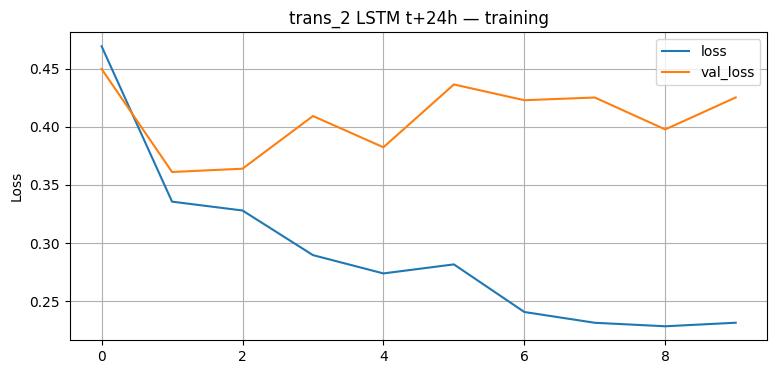

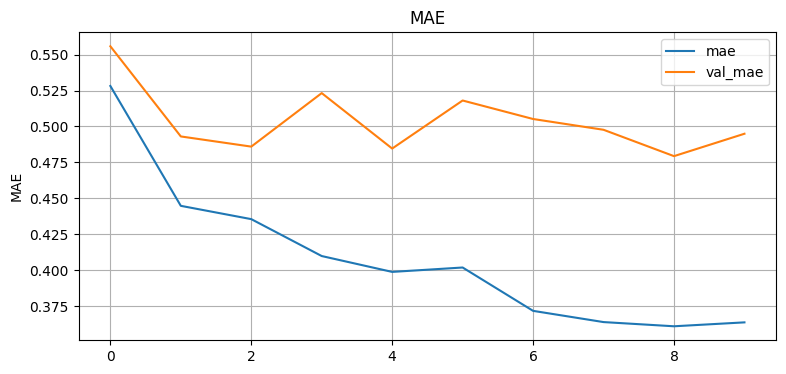

✅ Test shapes → Xte: (2640, 72, 6), yte: (2640,)
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 376ms/step
[trans_2 LSTM t+24h] MAE_z=0.6019 RMSE_z=0.7704 R2=0.4498 | MAE=7.10°C RMSE=9.09°C


IntRangeSlider(value=(0, 500), description='Slice:', max=2000, step=10)

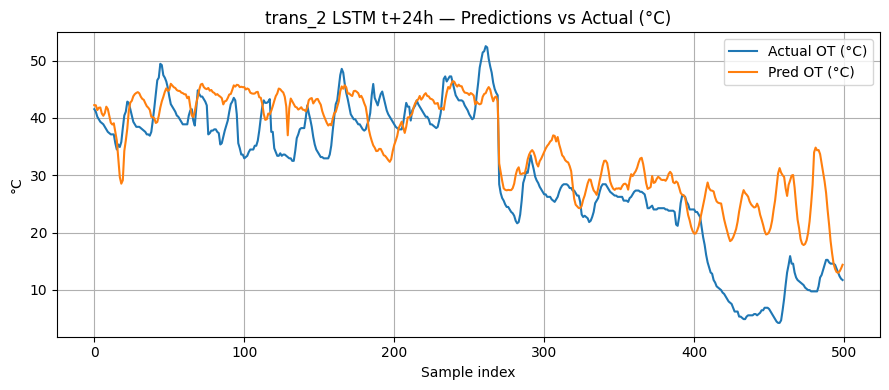

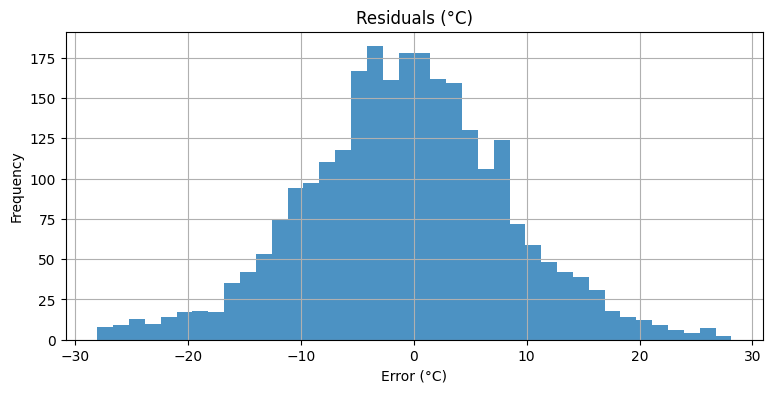

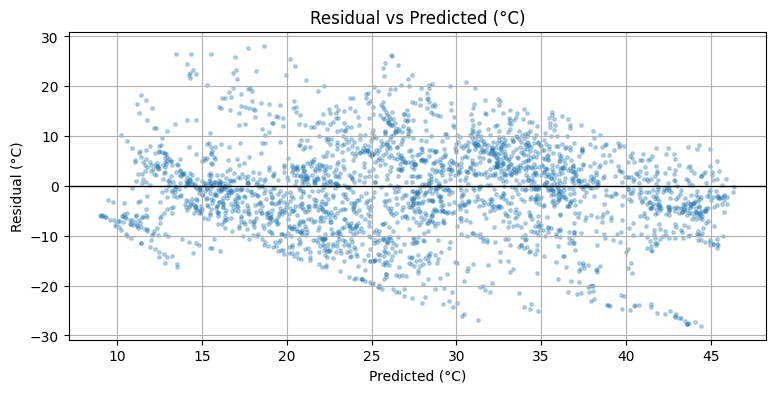

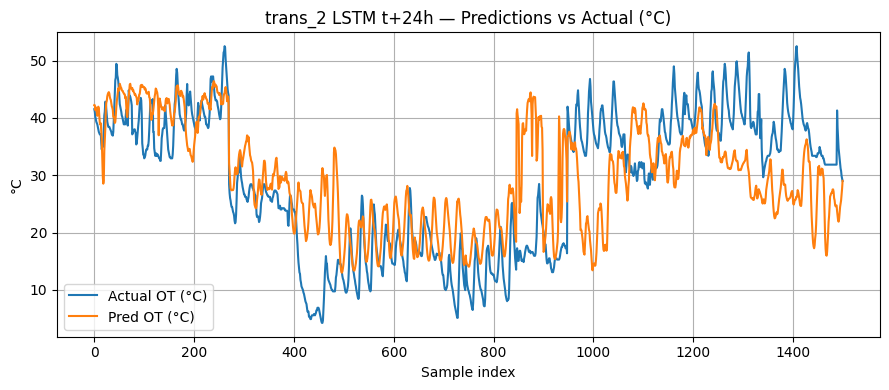

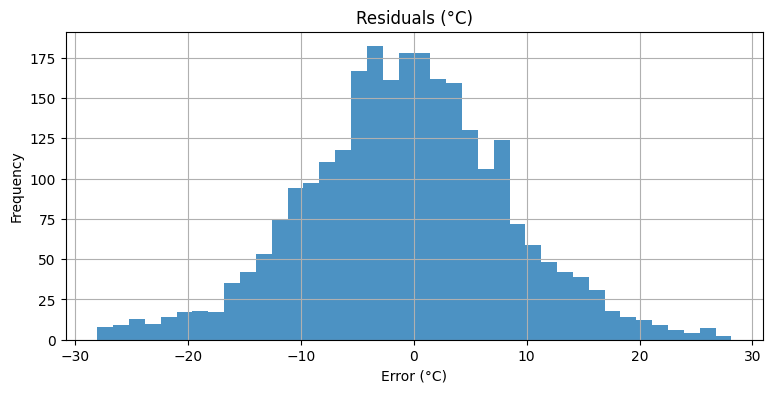

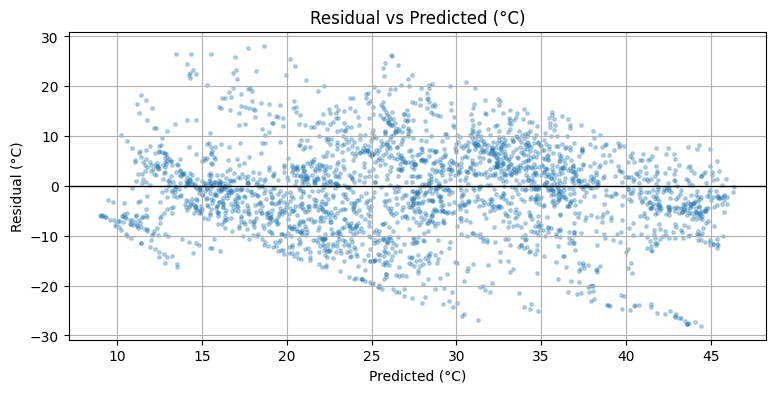

In [ ]:
# ==== Per-transformer LSTM visualisations (robust & per-μ/σ) ====
import os, json, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
import ipywidgets as W
from sklearn.metrics import mean_absolute_error, r2_score
from IPython.display import display

# choose what to view
tf_name = "trans_2"          # "trans_1" or "trans_2"
HKEY    = "t+24h"            # "t+1h" / "t+24h" / "t+168h"

BASE = "/content/drive/MyDrive/Colab Notebooks/project"
RUNS = f"{BASE}/runs"

# --- helper: find latest LSTM checkpoint under runs/<tf_name>/ ---
def _latest_lstm_ckpt(out_dir, hkey):
    files = [f for f in os.listdir(out_dir) if f.startswith(f"LSTM_{hkey}_") and f.endswith(".keras")]
    if not files:
        return None, None
    files.sort(key=lambda f: os.path.getmtime(os.path.join(out_dir, f)), reverse=True)
    ckpt = os.path.join(out_dir, files[0])
    hist = os.path.join(out_dir, os.path.splitext(files[0])[0] + "_history.json")
    return ckpt, (hist if os.path.exists(hist) else None)

# --- load model + (optional) history ---
out_dir = f"{RUNS}/{tf_name}"
ckpt_path, hist_path = _latest_lstm_ckpt(out_dir, HKEY)

# fallback to old OPT name if needed
if ckpt_path is None:
    maybe = os.path.join(out_dir, f"LSTM_{HKEY}_OPT.keras")
    if os.path.exists(maybe):
        ckpt_path = maybe
        hp = os.path.splitext(os.path.basename(maybe))[0] + "_history.json"
        hist_path = os.path.join(out_dir, hp) if os.path.exists(os.path.join(out_dir, hp)) else None

assert ckpt_path is not None, f"No LSTM checkpoint found in {out_dir} for {HKEY}"

print("📦 Loading model:", ckpt_path)
model = tf.keras.models.load_model(ckpt_path)

if hist_path:
    with open(hist_path) as f: hist_dict = json.load(f)
    try:
        plot_history(hist_dict, title=f"{tf_name} LSTM {HKEY} — training")
    except Exception as e:
        print("plot_history skipped:", e)
else:
    print("ℹ️ No history file found.")

# --- rebuild TEST split for this transformer/horizon ---
Xy_tf = build_Xy_for_transformer(tf_name, HKEY)       # uses STRIDE/WINDOWS/HORIZONS
(Xtr, ytr), (Xva, yva), (Xte, yte) = Xy_tf["train"], Xy_tf["val"], Xy_tf["test"]
print(f"✅ Test shapes → Xte: {Xte.shape}, yte: {yte.shape}")

# --- predictions & metrics (per-transformer μ/σ) ---
pred_z = model.predict(Xte, batch_size=256).ravel()

mae_z  = float(mean_absolute_error(yte, pred_z))
rmse_z = float(np.sqrt(((yte - pred_z)**2).mean()))
r2     = float(r2_score(yte, pred_z))

mu = stats[tf_name]["tg_mu"]; sd = stats[tf_name]["tg_sd"]   # <- key fix
toC = lambda z: z*sd + mu
mae_C  = float(mean_absolute_error(toC(yte), toC(pred_z)))
rmse_C = float(np.sqrt(((toC(yte) - toC(pred_z))**2).mean()))

print(f"[{tf_name} LSTM {HKEY}] MAE_z={mae_z:.4f} RMSE_z={rmse_z:.4f} R2={r2:.4f} | MAE={mae_C:.2f}°C RMSE={rmse_C:.2f}°C")

# --- interactive slice + residuals (reusing helpers) ---
W.IntSlider()  # warm widgets so the slider renders in Colab
slider = W.IntRangeSlider(value=[0, min(500, len(yte))], min=0, max=min(2000, len(yte)), step=10, description="Slice:")

def _show(_):
    s0, s1 = slider.value
    # pass mu/sd explicitly so helpers use the RIGHT transformer stats
    line_preds(yte, pred_z, mu, sd, start=s0, length=max(50, s1-s0),
               title=f"{tf_name} LSTM {HKEY} — Predictions vs Actual (°C)")
    residual_plots(yte, pred_z, mu, sd)

slider.observe(_show, names="value"); display(slider); _show(None)


###Visualisations (1w)

📦 Using model: LSTM_t+1w_L192_s2_u128_d0.2_Huber_lr2e-04.keras


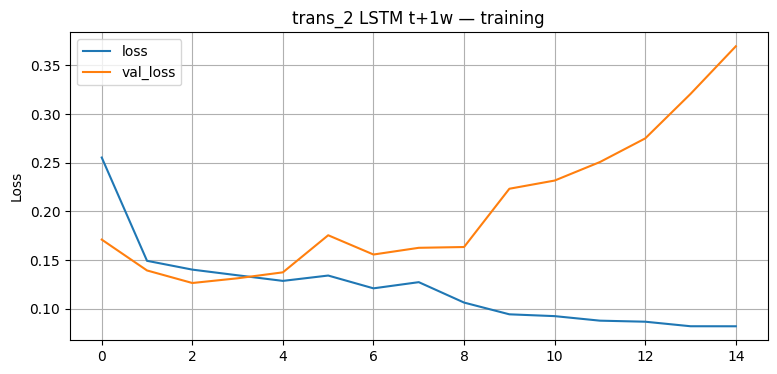

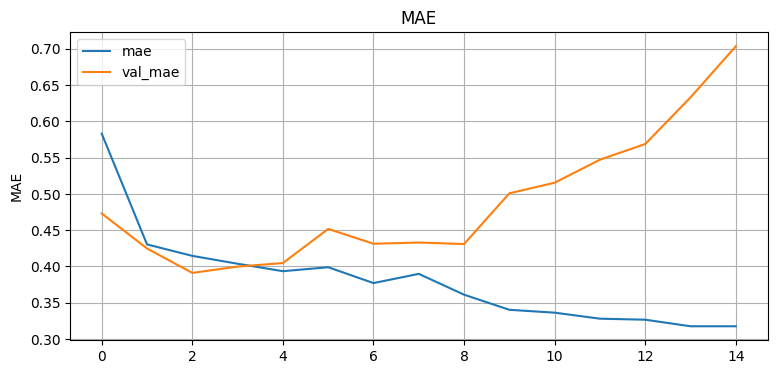

Shapes → train:(10464, 192, 6)  val:(0, 192, 6)  test:(0, 192, 6)  | window=192 stride=2
🧪 Using **TRAIN** split for visualisation/metrics (others empty).
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 518ms/step
[trans_2 LSTM t+1w • train] MAE_z=0.3954  RMSE_z=0.5280  R2=0.7408 | MAE=4.67°C  RMSE=6.23°C


IntRangeSlider(value=(0, 500), description='Slice (train):', max=2000, step=10)

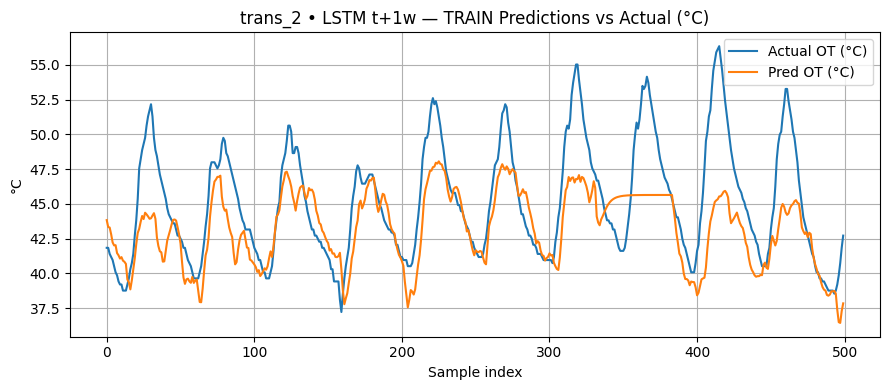

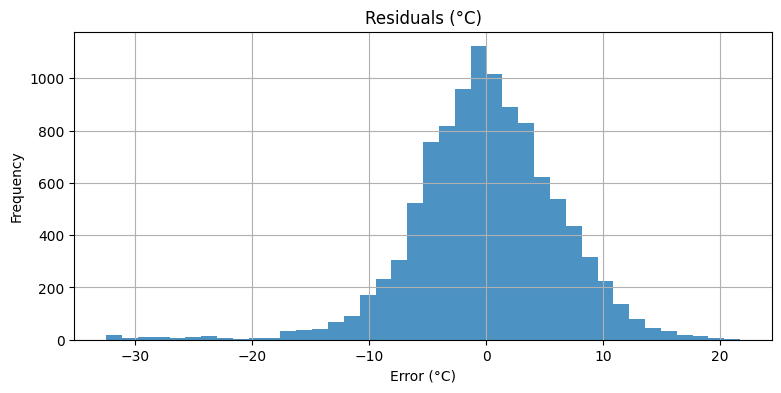

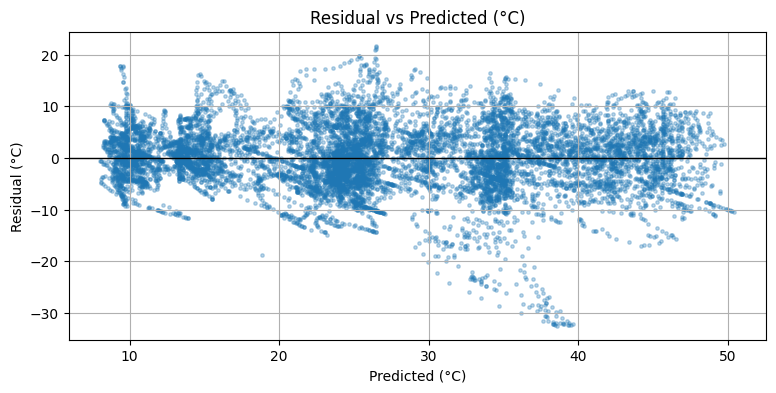

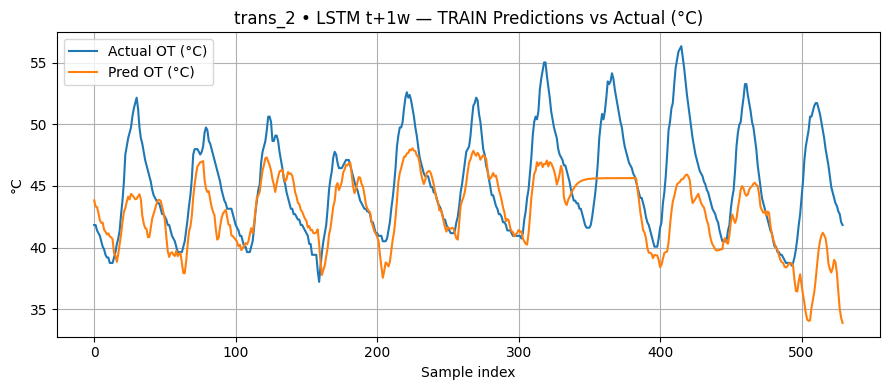

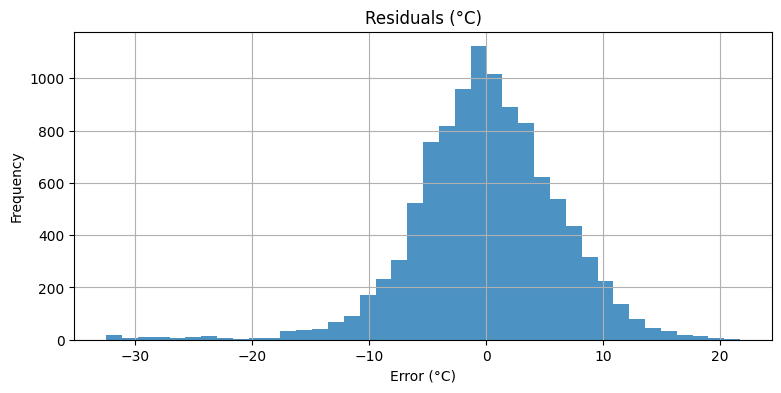

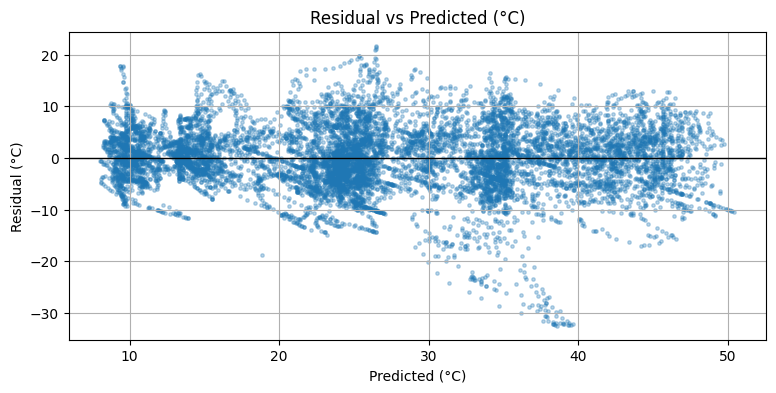

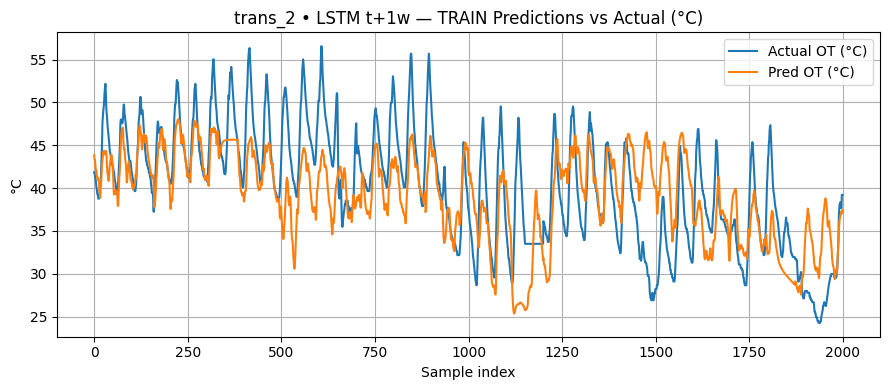

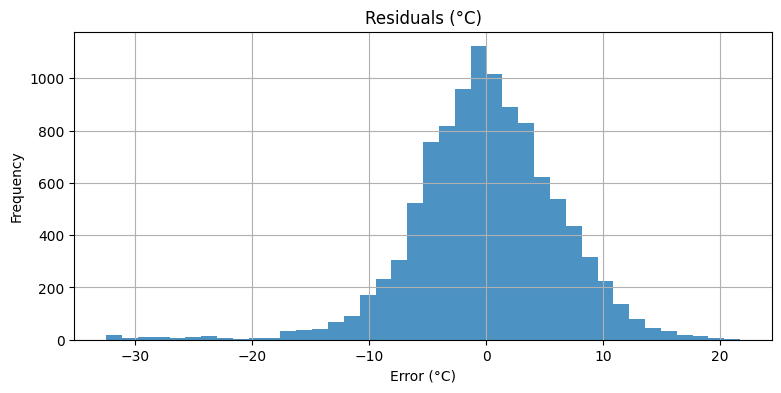

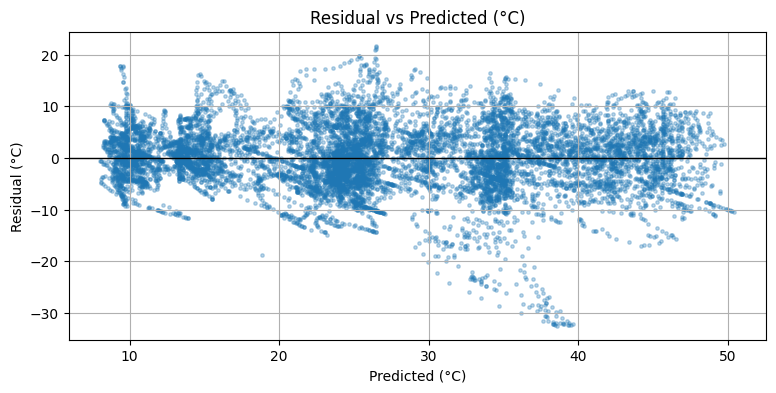

In [ ]:
# ==== LSTM @ +1 week — visualisation with safe split fallback ====
import os, re, glob, json, numpy as np, tensorflow as tf
from sklearn.metrics import mean_absolute_error, r2_score
import ipywidgets as W
from IPython.display import display

# --- choose transformer/horizon ---
tf_name = "trans_2"      # or "trans_2"
HKEY    = "t+1w"         # accepts "t+1w" or "t+168h"

# --- project paths ---
BASE = "/content/drive/MyDrive/Colab Notebooks/project"
RUNS = f"{BASE}/runs"

# --- required globals: stats, zdfs, idxs, INPUTS, TARGET, HORIZONS, STRIDE, make_windows_np, line_preds, residual_plots
req = ["stats","zdfs","idxs","INPUTS","TARGET","HORIZONS","STRIDE","make_windows_np","line_preds","residual_plots"]
assert all(k in globals() for k in req), "Run preprocessing/helpers first."

# --- per-transformer scaling (avoid global tg_mu/tg_sd) ---
mu_t = stats[tf_name]["tg_mu"]; sd_t = stats[tf_name]["tg_sd"]
toC  = lambda z: z*sd_t + mu_t

def _aliases(hk):
    if hk == "t+1w":    return ["t+1w","t+168h"]
    if hk == "t+168h":  return ["t+168h","t+1w"]
    return [hk]

# --- find latest LSTM checkpoint for this transformer/horizon (alias-aware) ---
cand = []
for hk in _aliases(HKEY):
    cand += glob.glob(f"{RUNS}/{tf_name}/LSTM_{hk}*.keras")
if not cand:  # last resort: any LSTM whose name contains the alias
    cand = [p for p in glob.glob(f"{RUNS}/{tf_name}/LSTM_*.keras") if any(a in p for a in _aliases(HKEY))]
assert cand, f"No LSTM model found for {tf_name} @ {HKEY} in {RUNS}/{tf_name}"
model_path = max(cand, key=os.path.getmtime)
print("📦 Using model:", os.path.basename(model_path))

# --- try to load matching history (same prefix) ---
hist_path = os.path.splitext(model_path)[0] + "_history.json"
hist_dict = {}
if os.path.exists(hist_path):
    with open(hist_path) as f: hist_dict = json.load(f)
    try:
        plot_history(hist_dict, title=f"{tf_name} LSTM {HKEY} — training")
    except Exception as e:
        print("plot_history skipped:", e)
else:
    print("ℹ️ No LSTM history file found at:", os.path.basename(hist_path))

# --- load model; infer required window length L ---
model = tf.keras.models.load_model(model_path)
L_required = model.input_shape[1]  # (batch, L, feats)

# --- rebuild windows to EXACTLY match model's L and this horizon's offset/gap ---
def build_Xy_for_transformer_L(tf_name: str, hkey: str, L_override: int, stride: int):
    # Support alias "t+1w" <-> "t+168h"
    hkey_real = "t+168h" if (hkey == "t+1w" and "t+1w" not in HORIZONS) else hkey
    offset, gap = HORIZONS[hkey_real]
    X_in  = zdfs[tf_name][INPUTS].to_numpy(np.float32)
    y_out = zdfs[tf_name][[TARGET]].to_numpy(np.float32).ravel()
    out = {}
    for split in ["train","val","test"]:
        rows = idxs[tf_name][split]
        X, y = make_windows_np(X_in, y_out, rows, L_override, offset, gap, stride=stride)
        out[split] = (X, y)
    return out

# Try to recover stride used at train time from filename (_sXX_). If absent, use global STRIDE.
m = re.search(r"_s(\d+)_", os.path.basename(model_path))
stride_used = int(m.group(1)) if m else int(globals().get("STRIDE", 1))

Xy_tf = build_Xy_for_transformer_L(tf_name, HKEY, L_required, stride_used)
(Xtr, ytr), (Xva, yva), (Xte, yte) = Xy_tf["train"], Xy_tf["val"], Xy_tf["test"]
print(f"Shapes → train:{Xtr.shape}  val:{Xva.shape}  test:{Xte.shape}  | window={L_required} stride={stride_used}")

# Pick the first non-empty split for metrics/plots: TEST → VAL → TRAIN
chosen = "test" if yte.size > 0 else ("val" if yva.size > 0 else ("train" if ytr.size > 0 else None))
assert chosen is not None, (
    "All splits empty for this horizon/window/stride. "
    "For t+1w you need ≥ (L + GAP + OFFSET) consecutive rows (~ L+1344)."
)
Xsel, ysel = Xy_tf[chosen]
print(f"🧪 Using **{chosen.upper()}** split for visualisation/metrics (others empty).")

# --- predictions & metrics (z and °C) ---
pred_z = model.predict(Xsel, batch_size=256).ravel()
mae_z  = float(mean_absolute_error(ysel, pred_z))
rmse_z = float(np.sqrt(((ysel - pred_z)**2).mean()))
r2     = float(r2_score(ysel, pred_z)) if len(ysel) > 1 else float("nan")

mae_C  = float(mean_absolute_error(toC(ysel), toC(pred_z)))
rmse_C = float(np.sqrt(((toC(ysel) - toC(pred_z))**2).mean()))

print(f"[{tf_name} LSTM {HKEY} • {chosen}] MAE_z={mae_z:.4f}  RMSE_z={rmse_z:.4f}  R2={r2:.4f} | "
      f"MAE={mae_C:.2f}°C  RMSE={rmse_C:.2f}°C")

# --- interactive slice + residuals (no unsupported kwargs) ---
W.IntSlider()  # warm widgets
slider = W.IntRangeSlider(
    value=[0, min(500, len(ysel))],
    min=0, max=min(2000, len(ysel)),
    step=10, description=f"Slice ({chosen}):"
)

def _show(_):
    s0, s1 = slider.value
    line_preds(
        ysel, pred_z, mu_t, sd_t,
        start=s0, length=max(50, s1 - s0),
        title=f"{tf_name} • LSTM {HKEY} — {chosen.upper()} Predictions vs Actual (°C)"
    )
    residual_plots(ysel, pred_z, mu_t, sd_t)

slider.observe(_show, names="value")
display(slider)
_show(None)

# (optional) cache for later comparisons
try:
    RUNS_CACHE
except NameError:
    RUNS_CACHE = {}
RUNS_CACHE[(f"{tf_name}:{HKEY}", "LSTM")] = {
    "y": ysel, "pred_z": pred_z, "hist": hist_dict, "mu": mu_t, "sd": sd_t, "split": chosen
}


#GRU (*build, train, evaluate, save*) (t+1h)

In [ ]:
# ===== GRU (t+1h) — train separate models for trans_1 and trans_2 (OFFSET=4, GAP=4) =====
# Requires in scope: zdfs, idxs, INPUTS, TARGET, RUNS, stats, make_windows_np, build_gru

import os, json, csv, random, numpy as np, tensorflow as tf
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import optimizers, losses

# -----------------------------
# 0) Hard constraints & reproducibility
# -----------------------------
assert TARGET not in INPUTS, "❌ OT must NOT be in INPUTS."
for tname in ["trans_1", "trans_2"]:
    assert {"train","val","test"}.issubset(idxs[tname].keys()), f"Missing splits for {tname}"

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# -----------------------------
# 1) Horizon config for t+1h (strict)
# -----------------------------
HKEY   = "t+1h"
OFFSET = 4   # predict 1 hour ahead (15-min × 4)
GAP    = 4   # inputs end at t-4 (no peeking)

# Per-transformer window/stride (tune if needed)
L_TRANS_1, STRIDE_TRANS_1 = 48, 2   # ~12h context
L_TRANS_2, STRIDE_TRANS_2 = 48, 2

# -----------------------------
# 2) GRU hyperparameters
# -----------------------------
# Keep both transformers on Huber for robustness at short horizon
CFG = {
    "trans_1": dict(units=128, dropout=0.10, lr=5e-4, patience_es=12, patience_lr=6),
    "trans_2": dict(units=128, dropout=0.15, lr=5e-4, patience_es=12, patience_lr=6),
}
BATCH = 64
EPOCHS = 120
LOSS_OBJ = losses.Huber(delta=1.0)

# -----------------------------
# 3) Helper to build X/y using (OFFSET=4, GAP=4)
# -----------------------------
def build_xy_t1h(tf_name: str, L: int, stride: int):
    X_in  = zdfs[tf_name][INPUTS].to_numpy(np.float32)             # inputs: NO OT
    y_out = zdfs[tf_name][[TARGET]].to_numpy(np.float32).ravel()   # target: OT (z)
    Xtr, ytr = make_windows_np(X_in, y_out, idxs[tf_name]["train"], L, OFFSET, GAP, stride)
    Xva, yva = make_windows_np(X_in, y_out, idxs[tf_name]["val"],   L, OFFSET, GAP, stride)
    Xte, yte = make_windows_np(X_in, y_out, idxs[tf_name]["test"],  L, OFFSET, GAP, stride)
    return (Xtr, ytr), (Xva, yva), (Xte, yte)

# -----------------------------
# 4) Train per transformer
# -----------------------------
for tf_name in ["trans_1", "trans_2"]:
    print("\n" + "-"*72)
    print(f"📦 Preparing data for {tf_name} @ {HKEY} (OFFSET={OFFSET}, GAP={GAP})")

    # Window/stride
    if tf_name == "trans_1":
        L, STRIDE_LOCAL = L_TRANS_1, STRIDE_TRANS_1
    else:
        L, STRIDE_LOCAL = L_TRANS_2, STRIDE_TRANS_2

    # Build windows (END at t-4; predict t+4)
    (Xtr, ytr), (Xva, yva), (Xte, yte) = build_xy_t1h(tf_name, L=L, stride=STRIDE_LOCAL)
    NFEATS = Xtr.shape[2] if Xtr.size else len(INPUTS)
    print(f"Shapes → train:{Xtr.shape}  val:{Xva.shape}  test:{Xte.shape}  | window={L} stride={STRIDE_LOCAL}")

    # Quick verification print (human-readable)
    # Separation between last input (t-4) and target (t+4) must be OFFSET+GAP = 8
    print(f"🔎 Verifying horizon config → expected OFFSET=4, GAP=4; separation=8 steps")
    assert OFFSET == 4 and GAP == 4, "❌ Wrong horizon config: OFFSET/GAP must both be 4 for t+1h."

    # Build & compile GRU
    tf.keras.backend.clear_session()
    units   = CFG[tf_name]["units"]
    dropout = CFG[tf_name]["dropout"]
    lr      = CFG[tf_name]["lr"]

    gru = build_gru(L, n_feats=NFEATS, units=units, dropout=dropout)
    gru.compile(optimizer=optimizers.Adam(lr), loss=LOSS_OBJ, metrics=["mae"])

    # Paths & callbacks
    out_dir = f"{RUNS}/{tf_name}"; os.makedirs(out_dir, exist_ok=True)
    tag = f"GRU_{HKEY}_L{L}_s{STRIDE_LOCAL}_u{units}_d{dropout}_Huber"
    ckpt_path = f"{out_dir}/{tag}.keras"
    hist_path = f"{out_dir}/{tag}_history.json"

    cbs = [
        EarlyStopping(monitor="val_loss", patience=CFG[tf_name]["patience_es"], restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", patience=CFG[tf_name]["patience_lr"], factor=0.5, min_lr=1e-5),
        ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True),
    ]

    # Train
    hist = gru.fit(
        Xtr, ytr,
        validation_data=(Xva, yva),
        epochs=EPOCHS,
        batch_size=BATCH,
        callbacks=cbs,
        verbose=1
    )
    with open(hist_path, "w") as f:
        json.dump(hist.history, f)

    # Evaluate (z-space)
    pred_z = gru.predict(Xte, batch_size=256).ravel()
    mae_z  = float(mean_absolute_error(yte, pred_z))
    rmse_z = float(np.sqrt(((yte - pred_z)**2).mean()))
    r2     = float(r2_score(yte, pred_z))

    # Convert to °C using THIS transformer's stats
    mu = stats[tf_name]["tg_mu"]; sd = stats[tf_name]["tg_sd"]
    toC = lambda z: z*sd + mu
    mae_C  = float(mean_absolute_error(toC(yte), toC(pred_z)))
    rmse_C = float(np.sqrt(((toC(yte) - toC(pred_z))**2).mean()))

    print(f"✅ [{tf_name}] {tag}")
    print(f"   MAE_z={mae_z:.4f}  RMSE_z={rmse_z:.4f}  R2={r2:.4f} | MAE={mae_C:.2f}°C  RMSE={rmse_C:.2f}°C")
    print(f"   Saved model → {ckpt_path}")
    print(f"   Saved history → {hist_path}")

    # Log summary
    summary = {
        "transformer": tf_name, "horizon": HKEY,
        "window": int(L), "stride": int(STRIDE_LOCAL),
        "units": int(units), "dropout": float(dropout),
        "loss": "Huber", "lr": float(lr),
        "batch_size": int(BATCH), "epochs": int(EPOCHS),
        "val_loss": float(min(hist.history["val_loss"])),
        "MAE_z": mae_z, "RMSE_z": rmse_z, "R2": r2,
        "MAE_C": mae_C, "RMSE_C": rmse_C, "seed": SEED
    }

    csv_path = f"{RUNS}/GRU_{HKEY}_summary.csv"
    new_file = not os.path.exists(csv_path)
    with open(csv_path, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=list(summary.keys()))
        if new_file: writer.writeheader()
        writer.writerow(summary)

    with open(f"{out_dir}/{tag}_summary.json", "w") as f:
        json.dump(summary, f, indent=2)



------------------------------------------------------------------------
📦 Preparing data for trans_1 @ t+1h (OFFSET=4, GAP=4)
Shapes → train:(23472, 48, 6)  val:(3136, 48, 6)  test:(6944, 48, 6)  | window=48 stride=2
🔎 Verifying horizon config → expected OFFSET=4, GAP=4; separation=8 steps
Epoch 1/120
367/367 ━━━━━━━━━━━━━━━━━━━━ 39s 96ms/step - loss: 0.3322 - mae: 0.6861 - val_loss: 0.2020 - val_mae: 0.5094 - learning_rate: 5.0000e-04
Epoch 2/120
367/367 ━━━━━━━━━━━━━━━━━━━━ 37s 102ms/step - loss: 0.1578 - mae: 0.4342 - val_loss: 0.1510 - val_mae: 0.4347 - learning_rate: 5.0000e-04
Epoch 3/120
367/367 ━━━━━━━━━━━━━━━━━━━━ 39s 97ms/step - loss: 0.1156 - mae: 0.3672 - val_loss: 0.1396 - val_mae: 0.4078 - learning_rate: 5.0000e-04
Epoch 4/120
367/367 ━━━━━━━━━━━━━━━━━━━━ 37s 101ms/step - loss: 0.0980 - mae: 0.3344 - val_loss: 0.1357 - val_mae: 0.3978 - learning_rate: 5.0000e-04
Epoch 5/120
367/367 ━━━━━━━━━━━━━━━━━━━━ 35s 96ms/step - loss: 0.0871 - mae: 0.3154 - val_loss: 0.1311 - val_


#GRU (t+24h)


In [ ]:
# ===== Train GRU for trans_1 and trans_2 with per-transformer overrides =====
# Requires: zdfs, idxs, INPUTS, TARGET, HORIZONS, WINDOWS, STRIDE, stats, RUNS
# Uses existing build_gru(); we only change training/compilation settings.

import os, json, csv, numpy as np, tensorflow as tf, random
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# --- reproducibility (optional) ---
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

HKEY = "t+24h"   # "t+1h" / "t+24h" / "t+168h"

def make_windows_np(X_in, y_out, rows, window, offset, gap, stride=1):
    rows = np.asarray(rows, dtype=np.int64)
    if rows.size == 0:
        return (np.empty((0, window, X_in.shape[1]), np.float32),
                np.empty((0,), np.float32))

    rowset = set(rows.tolist())          # fast membership test
    lo, hi = rows.min(), rows.max()
    X_list, y_list = [], []

    for t in rows[::stride]:
        t_gap_end = t - gap
        t_start   = t_gap_end - (window - 1)
        t_target  = t + offset

        # basic bounds
        if t_start < lo or t_gap_end > hi or t_target > hi:
            continue

        # require FULL membership inside the same split
        widx = np.arange(t_start, t_gap_end + 1, dtype=np.int64)
        if not np.all(np.isin(widx, rows)):
            continue
        if t_target not in rowset:
            continue   # <- ***prevent label leakage***

        X_list.append(X_in[widx, :])
        y_list.append(y_out[t_target])

    if not X_list:
        return (np.empty((0, window, X_in.shape[1]), np.float32),
                np.empty((0,), np.float32))
    return np.stack(X_list).astype(np.float32, copy=False), np.asarray(y_list, np.float32)


offset, gap = HORIZONS[HKEY]

for tf_name in ["trans_1", "trans_2"]:
    print("\n" + "-"*65)
    print(f"📦 Preparing data for {tf_name} @ {HKEY}")

    # -------- per-transformer overrides ----------
    if tf_name == "trans_1":
        L_override     = 96           # more context (was 72)
        stride_override= 1            # denser sampling (was 4)
        units, dropout = 128, 0.10    # more capacity, less regularisation
        lr, loss_obj   = 5e-4, tf.keras.losses.Huber(delta=1.0)  # robust
    else:
        L_override     = WINDOWS[HKEY]
        stride_override= STRIDE
        units, dropout = 64, 0.20
        lr, loss_obj   = 1e-3, "mse"

    # -------- build windows with overrides ----------
    X_in  = zdfs[tf_name][INPUTS].to_numpy(np.float32)
    y_out = zdfs[tf_name][[TARGET]].to_numpy(np.float32).ravel()

    Xtr, ytr = make_windows_np(X_in, y_out, idxs[tf_name]["train"], L_override, offset, gap, stride_override)
    Xva, yva = make_windows_np(X_in, y_out, idxs[tf_name]["val"],   L_override, offset, gap, stride_override)
    Xte, yte = make_windows_np(X_in, y_out, idxs[tf_name]["test"],  L_override, offset, gap, stride_override)

    L, NFEATS = Xtr.shape[1], Xtr.shape[2]
    print(f"Shapes → train:{Xtr.shape}  val:{Xva.shape}  test:{Xte.shape}  | window={L} stride={stride_override}")

    # -------- build & compile GRU (no change to builder) ----------
    tf.keras.backend.clear_session()
    gru = build_gru(L, n_feats=NFEATS, units=units, dropout=dropout)
    gru.compile(optimizer=tf.keras.optimizers.Adam(lr), loss=loss_obj, metrics=["mae"])

    # -------- callbacks & paths ----------
    out_dir   = f"{RUNS}/{tf_name}"
    os.makedirs(out_dir, exist_ok=True)
    tag       = f"GRU_{HKEY}_L{L}_s{stride_override}_u{units}_d{dropout}_{'Huber' if tf_name=='trans_1' else 'MSE'}"
    ckpt_path = f"{out_dir}/{tag}.keras"
    hist_path = f"{out_dir}/{tag}_history.json"

    cbs = [
        EarlyStopping(monitor="val_loss", patience=12 if tf_name=='trans_1' else 8, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", patience=6 if tf_name=='trans_1' else 4, factor=0.5, min_lr=1e-5),
        ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True),
    ]

    # -------- train ----------
    hist = gru.fit(
        Xtr, ytr,
        validation_data=(Xva, yva),
        epochs=150 if tf_name=='trans_1' else 100,
        batch_size=64,
        callbacks=cbs,
        verbose=1
    )
    with open(hist_path, "w") as f: json.dump(hist.history, f)

    # -------- evaluate (z & °C with correct stats) ----------
    pred_z = gru.predict(Xte, batch_size=256).ravel()
    mae_z  = float(mean_absolute_error(yte, pred_z))
    rmse_z = float(np.sqrt(((yte - pred_z)**2).mean()))
    r2     = float(r2_score(yte, pred_z))

    mu = stats[tf_name]["tg_mu"]; sd = stats[tf_name]["tg_sd"]
    inv = lambda z: z*sd + mu
    mae_C  = float(mean_absolute_error(inv(yte), inv(pred_z)))
    rmse_C = float(np.sqrt(((inv(yte) - inv(pred_z))**2).mean()))

    print(f"✅ [{tf_name}] {tag}")
    print(f"   MAE_z={mae_z:.4f}  RMSE_z={rmse_z:.4f}  R2={r2:.4f} | MAE={mae_C:.2f}°C  RMSE={rmse_C:.2f}°C")
    print(f"   Saved model → {ckpt_path}")
    print(f"   Saved history → {hist_path}")

    # -------- log summary (master CSV + per-transformer JSON) ----------
    summary = {
        "transformer": tf_name, "horizon": HKEY, "window": int(L),
        "stride": int(stride_override), "units": int(units), "dropout": float(dropout),
        "loss": "Huber" if tf_name=='trans_1' else "MSE",
        "lr": float(lr), "batch_size": 64,
        "val_loss": float(min(hist.history["val_loss"])),
        "MAE_z": mae_z, "RMSE_z": rmse_z, "R2": r2,
        "MAE_C": mae_C, "RMSE_C": rmse_C, "seed": SEED
    }

    csv_path = f"{RUNS}/GRU_{HKEY}_summary.csv"
    new_file = not os.path.exists(csv_path)
    with open(csv_path, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=list(summary.keys()))
        if new_file: writer.writeheader()
        writer.writerow(summary)

    with open(f"{out_dir}/{tag}_summary.json", "w") as f:
        json.dump(summary, f, indent=2)



-----------------------------------------------------------------
📦 Preparing data for trans_1 @ t+24h
Shapes → train:(43446, 96, 6)  val:(5000, 96, 6)  test:(11344, 96, 6)  | window=96 stride=1
Epoch 1/150
679/679 ━━━━━━━━━━━━━━━━━━━━ 128s 185ms/step - loss: 0.2786 - mae: 0.6122 - val_loss: 0.1365 - val_mae: 0.4088 - learning_rate: 5.0000e-04
Epoch 2/150
679/679 ━━━━━━━━━━━━━━━━━━━━ 138s 180ms/step - loss: 0.1088 - mae: 0.3556 - val_loss: 0.1312 - val_mae: 0.4067 - learning_rate: 5.0000e-04
Epoch 3/150
679/679 ━━━━━━━━━━━━━━━━━━━━ 120s 177ms/step - loss: 0.0855 - mae: 0.3144 - val_loss: 0.1264 - val_mae: 0.4001 - learning_rate: 5.0000e-04
Epoch 4/150
679/679 ━━━━━━━━━━━━━━━━━━━━ 119s 176ms/step - loss: 0.0681 - mae: 0.2838 - val_loss: 0.1381 - val_mae: 0.4188 - learning_rate: 5.0000e-04
Epoch 5/150
679/679 ━━━━━━━━━━━━━━━━━━━━ 120s 177ms/step - loss: 0.0587 - mae: 0.2637 - val_loss: 0.1392 - val_mae: 0.4191 - learning_rate: 5.0000e-04
Epoch 6/150
679/679 ━━━━━━━━━━━━━━━━━━━━ 120s 177

#GRU (t+1w)

In [ ]:
# ===== GRU (t+1w) — faster training, strict no-peek (OFFSET=672, GAP=672) =====
# Requires in scope: zdfs, idxs, INPUTS, TARGET, RUNS, stats, make_windows_np, build_gru
# This version adds:
#   • tf.data pipelines (prefetch/cache) to remove Python/NumPy bottlenecks
#   • Mixed precision (AMP) on supported GPUs, with a float32 output head
#   • XLA compile (jit_compile=True) for train/eval steps
#   • Slightly larger batch size for better GPU throughput
#   • Validation fallback if VAL split is empty
#   • The same window/gap/offset audits that has been used

import os, json, csv, random, numpy as np, tensorflow as tf, re
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# -----------------------------
# 0) Hard constraints & reproducibility
# -----------------------------
assert TARGET not in INPUTS, "❌ OT must NOT be in INPUTS."
for tname in ["trans_1", "trans_2"]:
    assert {"train","val","test"}.issubset(idxs[tname].keys()), f"Missing splits for {tname}"

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# -----------------------------
# 1) Horizon config for t+1w (strict)
# -----------------------------
HKEY   = "t+1w"   # accepts "t+1w" or "t+168h" in HORIZONS mapping
OFFSET = 672      # 7d * 24h * 4 steps/h
GAP    = 672      # inputs end at t-672 (excludes the forecast week completely)

# Per-transformer windows/stride (balanced for 1w)
L_TRANS_1, STRIDE_TRANS_1 = 288, 2    # ~3 days context, 30-min stride
L_TRANS_2, STRIDE_TRANS_2 = 192, 2    # ~2 days context, 30-min stride

# -----------------------------
# 2) GRU hyperparameters (robust for long horizon)
# -----------------------------
CFG = {
    "trans_1": dict(units=160, dropout=0.15, lr=2e-4, patience_es=14, patience_lr=7),
    "trans_2": dict(units=128, dropout=0.20, lr=2e-4, patience_es=12, patience_lr=6),
}
BATCH    = 128                          # ↑ was 64; faster on GPU (reduce if VRAM tight)
EPOCHS   = 60                           # keep moderate cap; EarlyStopping will halt earlier
LOSS_OBJ = tf.keras.losses.Huber(delta=1.5)
CLIPNORM = 1.0

# -----------------------------
# 3) SPEED BOOSTS: AMP + tf.data + XLA
# -----------------------------
# Mixed precision (float16 compute / float32 variables). Safe on modern NVIDIA GPUs.
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy("mixed_float16")
    AMP_ENABLED = True
    print("⚡ Mixed precision enabled (float16 compute / float32 vars).")
except Exception:
    AMP_ENABLED = False
    print("ℹ️ Mixed precision not enabled (staying in float32).")

def to_ds(X, y, batch_size, shuffle=False):
    """Build fast tf.data pipeline with cache+prefetch."""
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(min(len(y), 65536), reshuffle_each_iteration=True)
    ds = ds.batch(batch_size, drop_remainder=False).cache().prefetch(tf.data.AUTOTUNE)
    return ds

def compile_for_speed(model, lr, loss_obj, clipnorm=1.0, xla=True):
    """Ensure float32 output head under AMP; compile with XLA & gradient clipping."""
    if AMP_ENABLED:
        # Keep predictions/metrics in float32 to avoid numeric jitter in MAE/RMSE
        if getattr(model.layers[-1], "dtype", None) != "float32":
            out = tf.keras.layers.Activation("linear", dtype="float32", name="float32_head")(model.output)
            model = tf.keras.Model(model.input, out, name=model.name)
    opt = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=clipnorm)
    model.compile(optimizer=opt, loss=loss_obj, metrics=["mae"], jit_compile=bool(xla))
    return model

# -----------------------------
# 4) Helpers (builder, audit, val-fallback)
# -----------------------------
def build_xy_1w(tf_name: str, L: int, stride: int):
    """Return (Xtr,ytr), (Xva,yva), (Xte,yte) for t+1w with OFFSET=GAP=672."""
    X_in  = zdfs[tf_name][INPUTS].to_numpy(np.float32)           # inputs: NO OT
    y_out = zdfs[tf_name][[TARGET]].to_numpy(np.float32).ravel() # target: OT (z)
    Xtr, ytr = make_windows_np(X_in, y_out, idxs[tf_name]["train"], L, OFFSET, GAP, stride)
    Xva, yva = make_windows_np(X_in, y_out, idxs[tf_name]["val"],   L, OFFSET, GAP, stride)
    Xte, yte = make_windows_np(X_in, y_out, idxs[tf_name]["test"],  L, OFFSET, GAP, stride)
    return (Xtr, ytr), (Xva, yva), (Xte, yte)

def audit_gap(tf_name, L, stride, max_print=2):
    """Print proof that window ends at t-672 and target is t+672 (separation 1344 steps)."""
    import numpy as np
    def first_valid(rows):
        rows = np.asarray(rows, dtype=np.int64)
        if rows.size == 0: return None
        lo, hi = int(rows.min()), int(rows.max()); rowset = set(rows.tolist())
        out = []
        for t in rows[::stride]:
            t_gap_end = t - GAP
            t_start   = t_gap_end - (L - 1)
            t_target  = t + OFFSET
            if t_start < lo or t_gap_end > hi or t_target > hi: continue
            widx = np.arange(t_start, t_gap_end + 1, dtype=np.int64)
            if np.all(np.isin(widx, rows)) and (t_target in rowset):
                out.append((t, t_gap_end, t_target, widx[0], widx[-1]))
                if len(out) >= max_print: break
        return out

    print(f"🔎 Verifying {tf_name} @ {HKEY} → EXPECTED OFFSET=672, GAP=672")
    assert OFFSET == 672 and GAP == 672, "❌ OFFSET/GAP must both be 672 for t+1w."
    for split in ["train","val","test"]:
        ex = first_valid(idxs[tf_name][split])
        if not ex:
            print(f"   {split:5s}: (no valid sample to print)")
            continue
        for i,(t, t_gap_end, t_target, w0, w1) in enumerate(ex):
            print(f"   {split:5s} sample#{i}: t={t} | window=[{w0}..{w1}] = [t-{(GAP+L-1)} .. t-{GAP}] | target=t+{OFFSET} → {t_target}")
            assert (t_target - t_gap_end) == 1344, "❌ separation != 1344 steps"
    print("✅ Horizon alignment verified (inputs end at t-672; target at t+672).")

def ensure_validation(Xtr, ytr, Xva, yva, frac=0.10):
    """If VAL is empty, carve last frac of TRAIN as VAL (no cross-split leakage)."""
    if Xva.size > 0 and yva.size > 0:
        return (Xtr, ytr, Xva, yva, False)
    if Xtr.size == 0:
        return (Xtr, ytr, Xva, yva, False)
    n = len(ytr)
    k = max(1, int(frac * n))
    return (Xtr[:-k], ytr[:-k], Xtr[-k:], ytr[-k:], True)

# -----------------------------
# 5) Train per transformer
# -----------------------------
for tf_name in ["trans_1", "trans_2"]:
    print("\n" + "-"*92)
    print(f"📦 Preparing data for {tf_name} @ {HKEY} (OFFSET={OFFSET}, GAP={GAP})")

    # Window/stride choice per transformer
    if tf_name == "trans_1":
        L, STRIDE_LOCAL = L_TRANS_1, STRIDE_TRANS_1
    else:
        L, STRIDE_LOCAL = L_TRANS_2, STRIDE_TRANS_2

    # Build windows (END at t-672; predict t+672)
    (Xtr, ytr), (Xva, yva), (Xte, yte) = build_xy_1w(tf_name, L=L, stride=STRIDE_LOCAL)
    NFEATS = Xtr.shape[2] if Xtr.size else len(INPUTS)
    print(f"Shapes → train:{Xtr.shape}  val:{Xva.shape}  test:{Xte.shape}  | window={L} stride={STRIDE_LOCAL}")

    # Audit (no-peek proof)
    audit_gap(tf_name, L=L, stride=STRIDE_LOCAL)

    # If VAL is empty, carve 10% from TRAIN as fallback
    Xtr, ytr, Xva, yva, carved = ensure_validation(Xtr, ytr, Xva, yva, frac=0.10)
    if carved:
        print(f"ℹ️ VAL was empty → carved {len(yva)} samples (10%) from TRAIN as validation.")

    # Safety
    assert Xtr.size > 0, "❌ No training samples for this transformer/horizon."

    # Build fast tf.data pipelines
    train_ds = to_ds(Xtr, ytr, BATCH, shuffle=True)
    val_ds   = to_ds(Xva, yva, BATCH, shuffle=False) if Xva.size else None

    # Build & compile GRU (gradient clipping + XLA + AMP head cast)
    tf.keras.backend.clear_session()
    units   = CFG[tf_name]["units"]
    dropout = CFG[tf_name]["dropout"]
    lr      = CFG[tf_name]["lr"]

    gru = build_gru(L, n_feats=NFEATS, units=units, dropout=dropout)
    gru = compile_for_speed(gru, lr=lr, loss_obj=LOSS_OBJ, clipnorm=CLIPNORM, xla=True)

    # Paths & callbacks
    out_dir = f"{RUNS}/{tf_name}"; os.makedirs(out_dir, exist_ok=True)
    tag = f"GRU_{HKEY}_L{L}_s{STRIDE_LOCAL}_u{units}_d{dropout}_Huber_lr{lr:.0e}_bs{BATCH}"
    ckpt_path = f"{out_dir}/{tag}.keras"
    hist_path = f"{out_dir}/{tag}_history.json"

    cbs = [
        EarlyStopping(monitor="val_loss", patience=CFG[tf_name]["patience_es"], restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", patience=CFG[tf_name]["patience_lr"], factor=0.5, min_lr=1e-5),
        ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True),
    ]

    # Train (tf.data → no need for workers/multiprocessing)
    hist = gru.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=cbs,
        verbose=1
    )
    with open(hist_path, "w") as f:
        json.dump(hist.history, f)

    # Choose split for evaluation: TEST → VAL → TRAIN
    if yte.size:
        Xev, yev, esplit = Xte, yte, "test"
    elif yva.size:
        Xev, yev, esplit = Xva, yva, "val"
    else:
        Xev, yev, esplit = Xtr, ytr, "train"

    # Evaluate
    pred_z = gru.predict(to_ds(Xev, yev, batch_size=256, shuffle=False)).ravel()
    mae_z  = float(mean_absolute_error(yev, pred_z))
    rmse_z = float(np.sqrt(((yev - pred_z)**2).mean()))
    r2     = float(r2_score(yev, pred_z)) if len(yev) > 1 else float("nan")

    # Convert to °C using THIS transformer's μ/σ
    mu = stats[tf_name]["tg_mu"]; sd = stats[tf_name]["tg_sd"]
    toC = lambda z: z*sd + mu
    mae_C  = float(mean_absolute_error(toC(yev), toC(pred_z)))
    rmse_C = float(np.sqrt(((toC(yev) - toC(pred_z))**2).mean()))

    print(f"✅ [{tf_name}] {tag} • eval on {esplit.upper()}")
    print(f"   MAE_z={mae_z:.4f}  RMSE_z={rmse_z:.4f}  R2={r2:.4f} | MAE={mae_C:.2f}°C  RMSE={rmse_C:.2f}°C")
    print(f"   Saved model → {ckpt_path}")
    print(f"   Saved history → {hist_path}")

    # Log summary (CSV + JSON per transformer)
    summary = {
        "transformer": tf_name, "horizon": HKEY,
        "window": int(L), "stride": int(STRIDE_LOCAL),
        "units": int(units), "dropout": float(dropout),
        "loss": "Huber", "lr": float(lr),
        "batch_size": int(BATCH), "epochs": int(EPOCHS),
        "eval_split": esplit,
        "val_loss": float(min(hist.history.get("val_loss", [np.nan]))),
        "MAE_z": mae_z, "RMSE_z": rmse_z, "R2": r2,
        "MAE_C": mae_C, "RMSE_C": rmse_C, "seed": SEED
    }

    csv_path = f"{RUNS}/GRU_{HKEY}_summary.csv"
    new_file = not os.path.exists(csv_path)
    with open(csv_path, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=list(summary.keys()))
        if new_file: writer.writeheader()
        writer.writerow(summary)

    with open(f"{out_dir}/{tag}_summary.json", "w") as f:
        json.dump(summary, f, indent=2)


⚡ Mixed precision enabled (float16 compute / float32 vars).

--------------------------------------------------------------------------------------------
📦 Preparing data for trans_1 @ t+1w (OFFSET=672, GAP=672)
Shapes → train:(9984, 288, 6)  val:(0, 288, 6)  test:(0, 288, 6)  | window=288 stride=2
🔎 Verifying trans_1 @ t+1w → EXPECTED OFFSET=672, GAP=672
   train sample#0: t=2976 | window=[2017..2304] = [t-959 .. t-672] | target=t+672 → 3648
   train sample#1: t=2978 | window=[2019..2306] = [t-959 .. t-672] | target=t+672 → 3650
   val  : (no valid sample to print)
   test : (no valid sample to print)
✅ Horizon alignment verified (inputs end at t-672; target at t+672).
ℹ️ VAL was empty → carved 998 samples (10%) from TRAIN as validation.
Epoch 1/60
71/71 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - loss: 0.3576 - mae: 0.6927 - val_loss: 1.2942 - val_mae: 1.5934 - learning_rate: 2.0000e-04
Epoch 2/60
71/71 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - loss: 0.3177 - mae: 0.6332 - val_loss: 1.2725 - val_ma

4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step
✅ [trans_2] GRU_t+1w_L192_s2_u128_d0.2_Huber_lr2e-04_bs128 • eval on VAL
   MAE_z=0.3455  RMSE_z=0.4481  R2=-0.2990 | MAE=4.08°C  RMSE=5.29°C
   Saved model → /content/drive/MyDrive/Colab Notebooks/project/runs/trans_2/GRU_t+1w_L192_s2_u128_d0.2_Huber_lr2e-04_bs128.keras
   Saved history → /content/drive/MyDrive/Colab Notebooks/project/runs/trans_2/GRU_t+1w_L192_s2_u128_d0.2_Huber_lr2e-04_bs128_history.json


####Helper

In [ ]:
# ==== Prep: per-transformer window builder (run once per session) ====
# Expects these globals from steps:
# zdfs, idxs, INPUTS, TARGET, WINDOWS, HORIZONS, STRIDE
# If zdfs is missing, this cell will try to rebuild it from dfs + stats (in_stats, tg_mu, tg_sd).

import numpy as np
import pandas as pd

# 1) Minimal window maker (if not already defined)
try:
    make_windows_np
except NameError:
   def make_windows_np(X_in, y_out, rows, window, offset, gap, stride=1):
    rows = np.asarray(rows, dtype=np.int64)
    if rows.size == 0:
        return (np.empty((0, window, X_in.shape[1]), np.float32),
                np.empty((0,), np.float32))

    rowset = set(rows.tolist())          # fast membership test
    lo, hi = rows.min(), rows.max()
    X_list, y_list = [], []

    for t in rows[::stride]:
        t_gap_end = t - gap
        t_start   = t_gap_end - (window - 1)
        t_target  = t + offset

        # basic bounds
        if t_start < lo or t_gap_end > hi or t_target > hi:
            continue

        # require FULL membership inside the same split
        widx = np.arange(t_start, t_gap_end + 1, dtype=np.int64)
        if not np.all(np.isin(widx, rows)):
            continue
        if t_target not in rowset:
            continue   # <- ***prevent label leakage***

        X_list.append(X_in[widx, :])
        y_list.append(y_out[t_target])

    if not X_list:
        return (np.empty((0, window, X_in.shape[1]), np.float32),
                np.empty((0,), np.float32))
    return np.stack(X_list).astype(np.float32, copy=False), np.asarray(y_list, np.float32)


# 2) Rebuild zdfs if missing (uses train-only stats)
try:
    zdfs
except NameError:
    # requires: dfs, INPUTS, TARGET, in_stats, tg_mu, tg_sd, standardize_apply
    def _apply_all_z(df):
        Xz = standardize_apply(df[INPUTS], in_stats)                     # inputs: shared μ/σ
        yz = standardize_apply(df[[TARGET]], {TARGET: (tg_mu, tg_sd)})   # target: μ/σ from training
        return pd.concat([Xz, yz], axis=1)
    zdfs = {name: _apply_all_z(dfs[name]) for name in dfs.keys()}

# 3) Builder for ONE transformer & ONE horizon
def build_Xy_for_transformer(tf_name: str, hkey: str):
    """Return dict(split -> (X,y)) for a single transformer & horizon."""
    L = WINDOWS[hkey]
    offset, gap = HORIZONS[hkey]
    X_in  = zdfs[tf_name][INPUTS].to_numpy(dtype=np.float32)
    y_out = zdfs[tf_name][[TARGET]].to_numpy(dtype=np.float32).ravel()

    out = {}
    for split in ["train", "val", "test"]:
        rows = idxs[tf_name][split]
        X, y = make_windows_np(X_in, y_out, rows, L, offset, gap, stride=STRIDE)
        out[split] = (X, y)
    return out

print("✅ build_Xy_for_transformer is ready.")


✅ build_Xy_for_transformer is ready.


## Visualisations


📦 Using model: GRU_t+1h_L48_s2_u128_d0.15_Huber_lr2e-04.keras


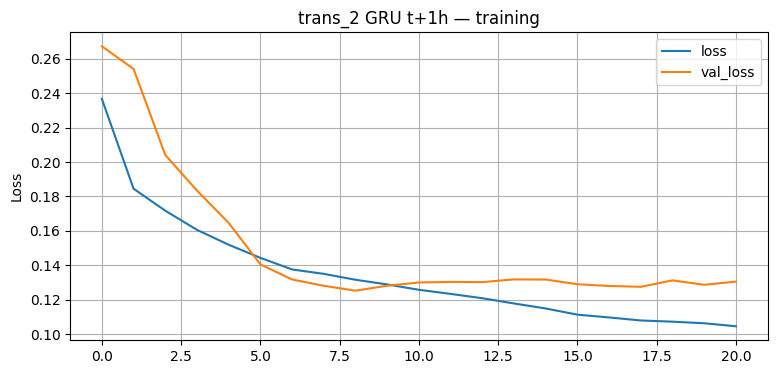

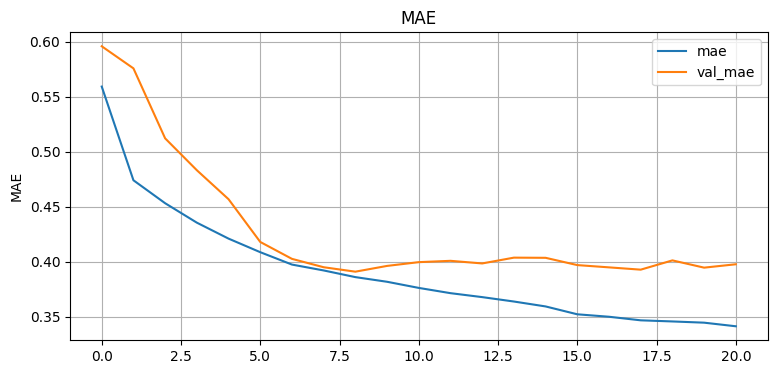

Shapes → train:(11736, 48, 6)  val:(1568, 48, 6)  test:(3472, 48, 6)  | window=48
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step
[trans_2 GRU t+1h] MAE_z=0.4590 RMSE_z=0.6099 R2=0.6446 | MAE=5.42°C RMSE=7.20°C


IntRangeSlider(value=(0, 500), description='Slice:', max=2000, step=10)

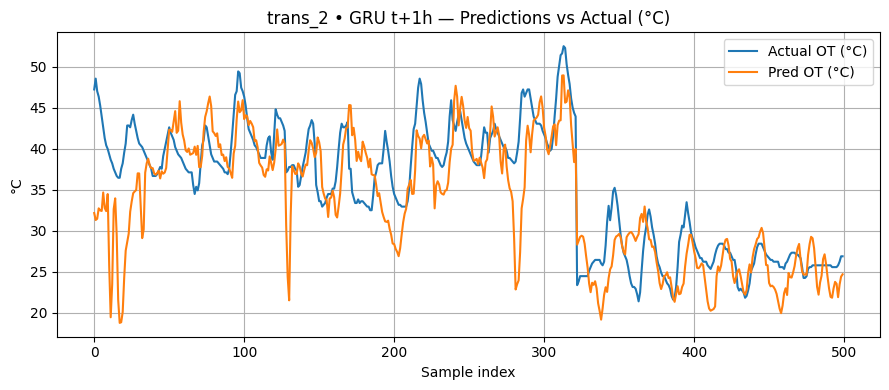

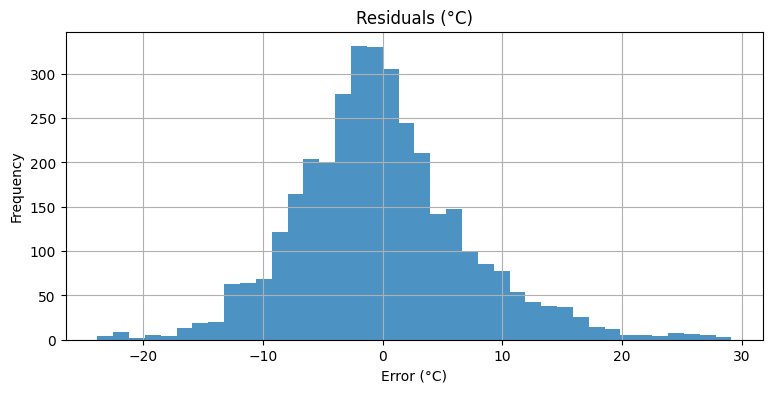

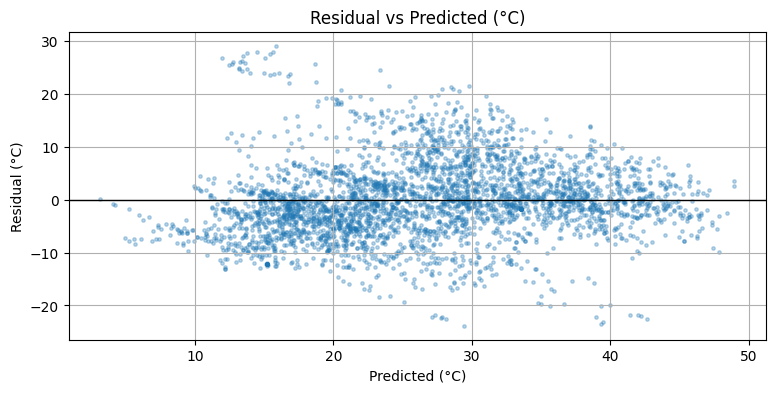

In [ ]:
# ==== GRU visualisations (no architecture diagram) ====
import os, json, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from sklearn.metrics import mean_absolute_error, r2_score
import ipywidgets as W

# ==== GRU visualisations (robust & per-transformer correct) ====
import os, json, glob, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from sklearn.metrics import mean_absolute_error, r2_score
import ipywidgets as W

# --- choose which transformer/horizon to visualise ---
tf_name = "trans_2"      # or "trans_2"
HKEY    = "t+1h"        # "t+1h", "t+24h", "t+168h"

# --- project paths ---
BASE = "/content/drive/MyDrive/Colab Notebooks/project"
RUNS = f"{BASE}/runs"

# --- per-transformer stats (don't use globals) ---
assert 'stats' in globals(), "Run the standardisation cell first to populate `stats`."
mu_t = stats[tf_name]["tg_mu"]
sd_t = stats[tf_name]["tg_sd"]

def inverse_C(z, mu=mu_t, sd=sd_t):
    return z * sd + mu

# --- find the most recent model for this tf_name/horizon ---
candidates = glob.glob(f"{RUNS}/{tf_name}/GRU_{HKEY}*.keras")
assert candidates, f"No saved GRU model found for {tf_name} @ {HKEY} in {RUNS}/{tf_name}"
model_path = max(candidates, key=os.path.getmtime)
print("📦 Using model:", os.path.basename(model_path))

# try to pick the matching history JSON (same prefix before extension)
hist_prefix = os.path.splitext(model_path)[0]
hist_path   = hist_prefix + "_history.json"
hist_dict   = {}
if os.path.exists(hist_path):
    with open(hist_path) as f:
        hist_dict = json.load(f)
    try:
        plot_history(hist_dict, title=f"{tf_name} GRU {HKEY} — training")
    except Exception as e:
        print("plot_history skipped:", e)
else:
    print("ℹ️ No history file found at:", os.path.basename(hist_path))

# --- load model ---
model = tf.keras.models.load_model(model_path)
L_required = model.input_shape[1]  # ensure our windows match model

# --- helper: build windows with an explicit L override to match the model ---
def build_Xy_for_transformer_L(tf_name: str, hkey: str, L_override: int):
    offset, gap = HORIZONS[hkey]
    X_in  = zdfs[tf_name][INPUTS].to_numpy(dtype=np.float32)
    y_out = zdfs[tf_name][[TARGET]].to_numpy(dtype=np.float32).ravel()
    out = {}
    for split in ["train","val","test"]:
        rows = idxs[tf_name][split]
        X, y = make_windows_np(X_in, y_out, rows, L_override, offset, gap, stride=STRIDE)
        out[split] = (X, y)
    return out

# --- rebuild test arrays for the EXACT window length the model expects ---
Xy_tf = build_Xy_for_transformer_L(tf_name, HKEY, L_required)
(Xtr, ytr), (Xva, yva), (Xte, yte) = Xy_tf["train"], Xy_tf["val"], Xy_tf["test"]
print(f"Shapes → train:{Xtr.shape}  val:{Xva.shape}  test:{Xte.shape}  | window={L_required}")

# --- evaluate with the CORRECT transformer's μ/σ ---
pred_gru_z = model.predict(Xte, batch_size=256).ravel()
mae_z  = float(mean_absolute_error(yte, pred_gru_z))
rmse_z = float(np.sqrt(((yte - pred_gru_z)**2).mean()))
r2     = float(r2_score(yte, pred_gru_z))

mae_C  = float(mean_absolute_error(inverse_C(yte), inverse_C(pred_gru_z)))
rmse_C = float(np.sqrt(((inverse_C(yte) - inverse_C(pred_gru_z))**2).mean()))

print(f"[{tf_name} GRU {HKEY}] MAE_z={mae_z:.4f} RMSE_z={rmse_z:.4f} R2={r2:.4f} | "
      f"MAE={mae_C:.2f}°C RMSE={rmse_C:.2f}°C")

# --- interactive visualisation (titles + correct μ/σ) ---
W.IntSlider()  # ensure widgets load
slider = W.IntRangeSlider(value=[0, min(500, len(yte))],
                          min=0, max=min(2000, len(yte)),
                          step=10, description="Slice:")

def _show(_):
    s0, s1 = slider.value
    line_preds(
        yte, pred_gru_z, mu_t, sd_t,
        start=s0, length=max(50, s1 - s0),
        title=f"{tf_name} • GRU {HKEY} — Predictions vs Actual (°C)"
    )
    # Call residual_plots without the title argument
    residual_plots(yte, pred_gru_z, mu_t, sd_t)


slider.observe(_show, names="value"); display(slider); _show(None)

# --- (optional) register for comparisons ---
try:
    RUNS_CACHE
except NameError:
    RUNS_CACHE = {}
RUNS_CACHE[(f"{tf_name}:{HKEY}", "GRU")] = {
    "yte": yte, "pred_z": pred_gru_z, "hist": hist_dict, "mu": mu_t, "sd": sd_t
}


###Visualisations (1w)

📦 Using model: GRU_t+1w_L192_s2_u128_d0.2_Huber_lr2e-04_bs128.keras


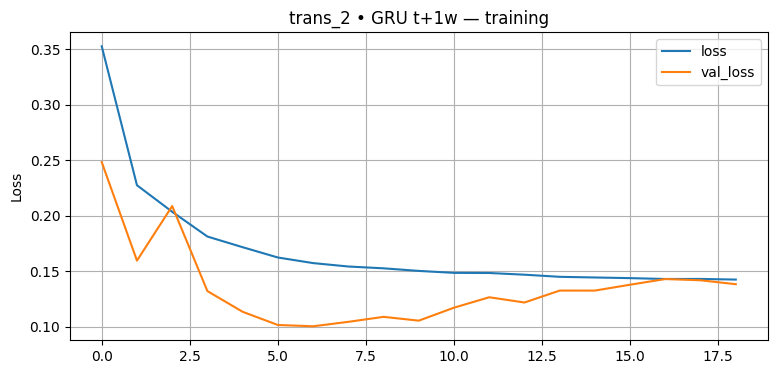

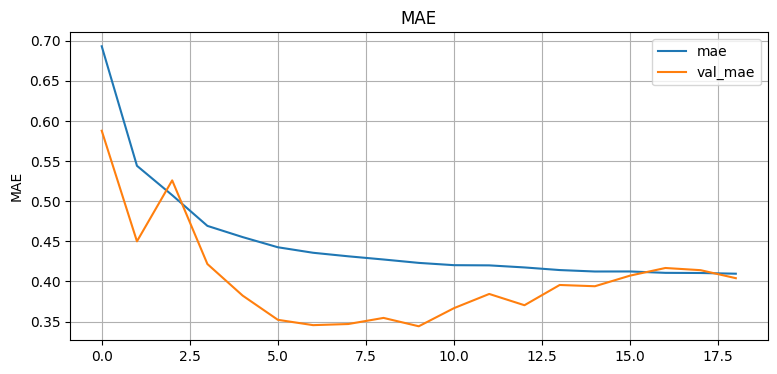

Shapes → train:(10464, 192, 6)  val:(0, 192, 6)  test:(0, 192, 6)  | window=192 stride=2
🧪 Using **TRAIN** split for visualisation/metrics.
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 378ms/step
[trans_2 GRU t+1w • train] MAE_z=0.4173  RMSE_z=0.5434  R2=0.7255 | MAE=4.92°C  RMSE=6.41°C


IntRangeSlider(value=(0, 500), description='Slice (train):', max=2000, step=10)

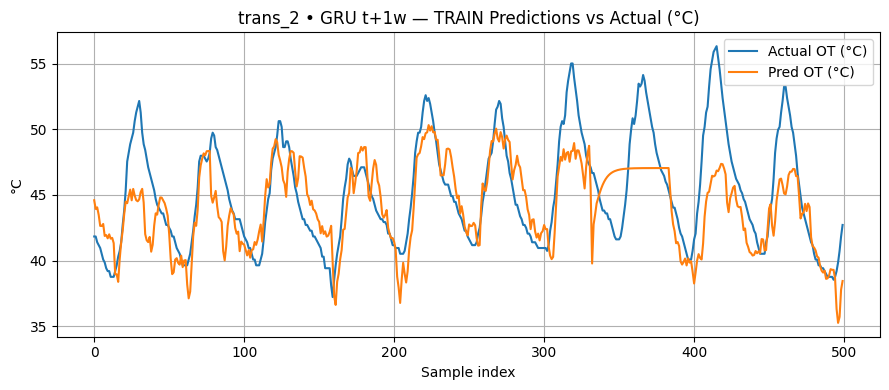

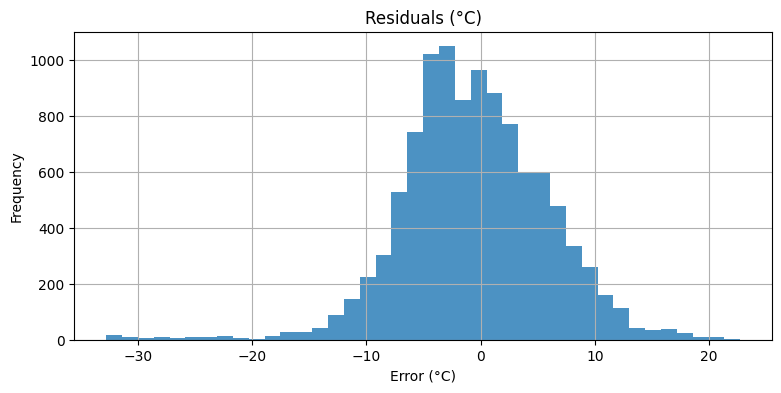

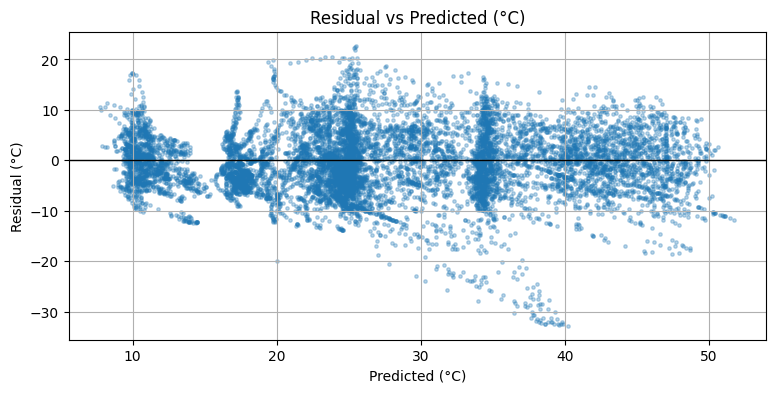

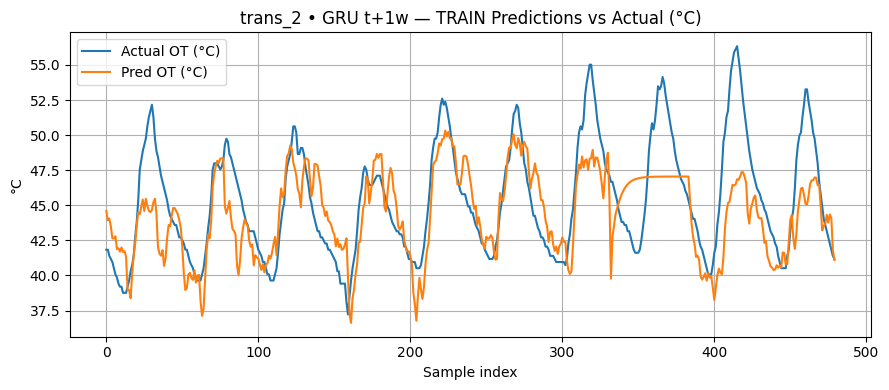

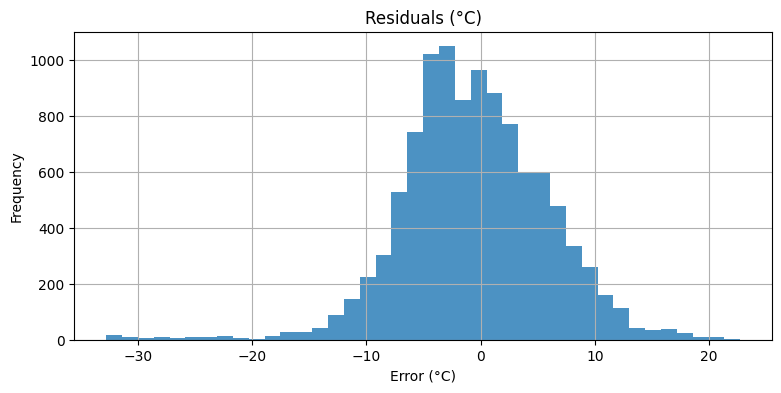

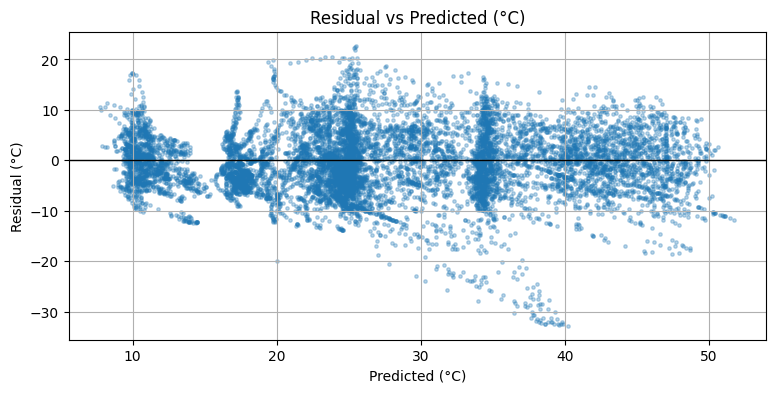

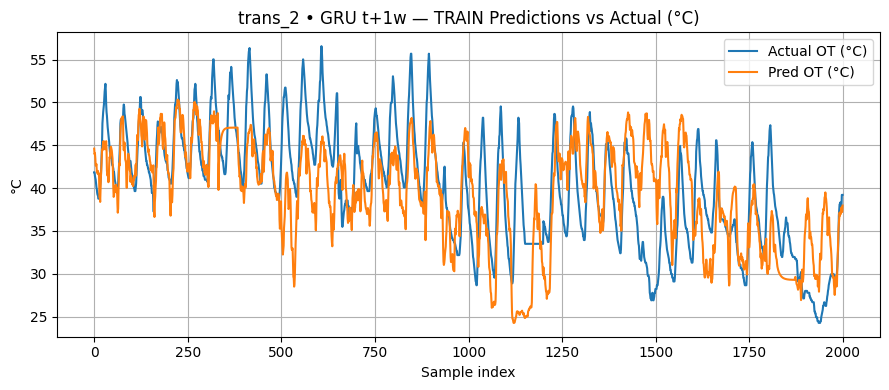

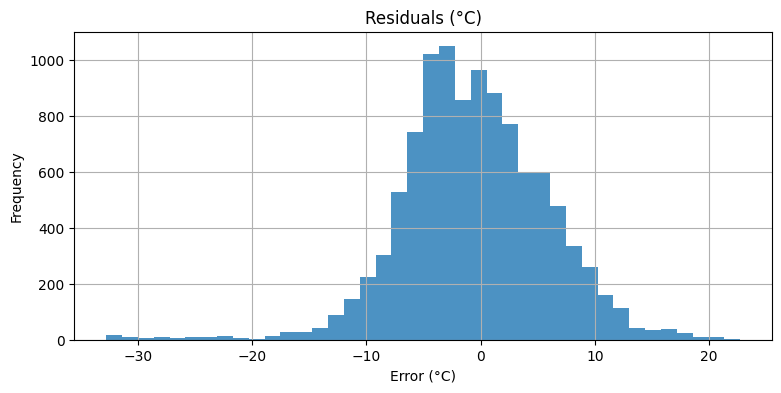

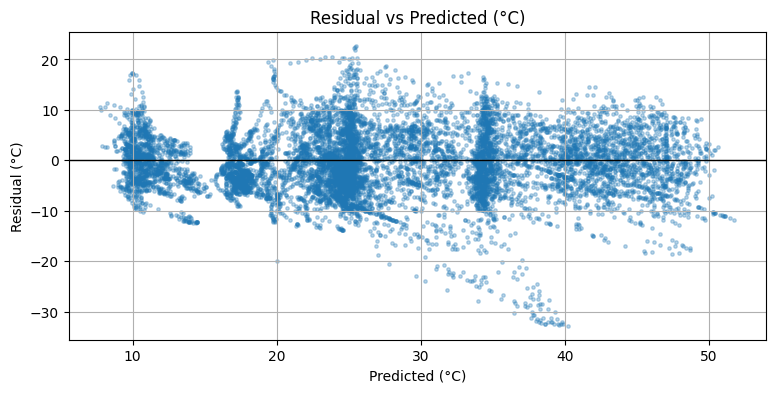

In [ ]:
# ==== GRU @ +1 week — visualisation with safe split fallback ====
import os, re, glob, json, numpy as np, tensorflow as tf
from sklearn.metrics import mean_absolute_error, r2_score
import ipywidgets as W
from IPython.display import display

# --- choose transformer/horizon ---
tf_name = "trans_2"   # or "trans_2"
HKEY    = "t+1w"      # accepts "t+1w" or "t+168h"

# --- paths ---
BASE = "/content/drive/MyDrive/Colab Notebooks/project"
RUNS = f"{BASE}/runs"

# --- required globals: stats, zdfs, idxs, INPUTS, TARGET, HORIZONS, make_windows_np, line_preds, residual_plots
assert all(k in globals() for k in ["stats","zdfs","idxs","INPUTS","TARGET","HORIZONS","make_windows_np","line_preds","residual_plots"]), \
    "Run preprocessing/helpers first."

# --- per-transformer scaling (avoid global tg_mu/tg_sd)
mu_t = stats[tf_name]["tg_mu"]; sd_t = stats[tf_name]["tg_sd"]
toC  = lambda z: z*sd_t + mu_t

def _aliases(hk):
    if hk == "t+1w":   return ["t+1w","t+168h"]
    if hk == "t+168h": return ["t+168h","t+1w"]
    return [hk]

# -- find latest GRU checkpoint (alias-aware: 't+1w' or 't+168h') --
cand = []
for hk in _aliases(HKEY):
    cand += glob.glob(f"{RUNS}/{tf_name}/GRU_{hk}*.keras")
if not cand:  # last resort: any GRU whose name contains an alias
    cand = [p for p in glob.glob(f"{RUNS}/{tf_name}/GRU_*.keras") if any(a in p for a in _aliases(HKEY))]
assert cand, f"No GRU model found for {tf_name} @ {HKEY} in {RUNS}/{tf_name}"
model_path = max(cand, key=os.path.getmtime)
print("📦 Using model:", os.path.basename(model_path))

# -- try to load matching history (same prefix)
hist_path = os.path.splitext(model_path)[0] + "_history.json"
hist_dict = {}
if os.path.exists(hist_path):
    with open(hist_path) as f:
        hist_dict = json.load(f)
    try:
        plot_history(hist_dict, title=f"{tf_name} • GRU {HKEY} — training")
    except Exception as e:
        print("plot_history skipped:", e)
else:
    print("ℹ️ No history file found for:", os.path.basename(model_path))

# -- load model, infer window L and (if present) training stride from filename
model = tf.keras.models.load_model(model_path)
L_required = model.input_shape[1]
m = re.search(r"_s(\d+)_", os.path.basename(model_path))
stride_used = int(m.group(1)) if m else (globals().get("STRIDE", 1))

# -- helper to rebuild X/y with exact L & stride so shapes align
def _build_xy(tf_name, hkey, L_override, stride):
    hkey_real = "t+168h" if (hkey == "t+1w" and "t+1w" not in HORIZONS) else hkey
    offset, gap = HORIZONS[hkey_real]
    X_in  = zdfs[tf_name][INPUTS].to_numpy(np.float32)
    y_out = zdfs[tf_name][[TARGET]].to_numpy(np.float32).ravel()
    out = {}
    for split in ["train","val","test"]:
        rows = idxs[tf_name][split]
        X, y = make_windows_np(X_in, y_out, rows, L_override, offset, gap, stride=stride)
        out[split] = (X, y)
    return out

Xy_tf = _build_xy(tf_name, HKEY, L_required, stride_used)

# -- prefer TEST → VAL → TRAIN (some 1w splits can be empty if continuity < L+GAP+OFFSET)
splits_order = ["test","val","train"]
chosen = next((s for s in splits_order if Xy_tf[s][0].size > 0), None)

if chosen is None:
    print("❌ All splits empty for this horizon/window/stride.\n"
          "   You need ≥ (L + GAP + OFFSET) consecutive indices in a split (≈ 1632 for 1w when L=288).")
else:
    (Xsel, ysel) = Xy_tf[chosen]
    print(f"Shapes → train:{Xy_tf['train'][0].shape}  val:{Xy_tf['val'][0].shape}  test:{Xy_tf['test'][0].shape}  | "
          f"window={L_required} stride={stride_used}")
    print(f"🧪 Using **{chosen.upper()}** split for visualisation/metrics.")

    # -- predict & metrics on chosen split
    pred_z = model.predict(Xsel, batch_size=256).ravel()
    mae_z  = float(mean_absolute_error(ysel, pred_z))
    rmse_z = float(np.sqrt(((ysel - pred_z)**2).mean()))
    r2     = float(r2_score(ysel, pred_z)) if len(ysel) > 1 else float("nan")

    mae_C  = float(mean_absolute_error(toC(ysel), toC(pred_z)))
    rmse_C = float(np.sqrt(((toC(ysel) - toC(pred_z))**2).mean()))

    print(f"[{tf_name} GRU {HKEY} • {chosen}] MAE_z={mae_z:.4f}  RMSE_z={rmse_z:.4f}  R2={r2:.4f} | "
          f"MAE={mae_C:.2f}°C  RMSE={rmse_C:.2f}°C")

    # -- interactive plots
    W.IntSlider()  # warm widgets so slider renders in Colab
    slider = W.IntRangeSlider(value=[0, min(500, len(ysel))],
                              min=0, max=min(2000, len(ysel)),
                              step=10, description=f"Slice ({chosen}):")
    def _show(_):
        s0, s1 = slider.value
        line_preds(ysel, pred_z, mu_t, sd_t,
                   start=s0, length=max(50, s1 - s0),
                   title=f"{tf_name} • GRU {HKEY} — {chosen.upper()} Predictions vs Actual (°C)")
        residual_plots(ysel, pred_z, mu_t, sd_t)

    slider.observe(_show, names="value")
    display(slider)
    _show(None)

    # -- (optional) register for model-comparison utilities
    try:
        RUNS_CACHE
    except NameError:
        RUNS_CACHE = {}
    RUNS_CACHE[(f"{tf_name}:{HKEY}", "GRU")] = {
        "y": ysel, "pred_z": pred_z, "hist": hist_dict, "mu": mu_t, "sd": sd_t, "split": chosen
    }


# CNN (*build, train, evaluate, save*) (t+1h)

In [ ]:
# =========================
# 1) Short-horizon CNN (causal, light dilation, BN)
#    Suited for t+1h: focuses on local dynamics, stable training
# =========================
from tensorflow.keras import layers, models, regularizers

def build_cnn1d_causal_short(L, n_feats, channels=96, kernel=3, dropout=0.15, l2=1e-5):
    """
    Causal 1D CNN for short-horizon forecasting (t+1h).
    - Shallow dilation (1,2,4) captures tens of minutes to few hours.
    - BatchNorm + Dropout for stability.
    """
    inp = layers.Input((L, n_feats))
    x = inp
    for d in [1, 2, 4]:
        x = layers.Conv1D(
            channels, kernel,
            padding="causal", dilation_rate=d,
            activation="relu",
            kernel_regularizer=regularizers.l2(l2)
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout)(x)
    x = layers.GlobalAveragePooling1D()(x)
    out = layers.Dense(1)(x)
    return models.Model(inp, out)


# ===== CNN (t+1h) — separate models for trans_1 and trans_2 with audits =====
# Needs in scope: zdfs, idxs, INPUTS, TARGET, RUNS, stats, make_windows_np
import os, json, csv, random, numpy as np, tensorflow as tf
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import optimizers, losses

# -----------------------------
# 0) Hard constraints & reproducibility
# -----------------------------
assert TARGET not in INPUTS, "❌ OT must NOT be in INPUTS."
for tname in ["trans_1", "trans_2"]:
    assert {"train","val","test"}.issubset(idxs[tname].keys()), f"Missing splits for {tname}"

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# -----------------------------
# 1) Horizon config for t+1h (strict)
# -----------------------------
HKEY   = "t+1h"
OFFSET = 4   # predict 1 hour ahead (15-min × 4)
GAP    = 4   # inputs end at t-4 (no peeking)

# Per-transformer windows/stride (tuned for 1h)
# More context for trans_1 (thermal lag), slightly less for trans_2
L_TRANS_1, STRIDE_TRANS_1 = 96, 1   # ~24h context, densest sampling
L_TRANS_2, STRIDE_TRANS_2 = 96, 2   # ~12h context, moderate sampling

# -----------------------------
# 2) CNN hyperparameters (stable defaults for 1h)
# -----------------------------
CFG = {
    "trans_1": dict(
        channels=96,   # was 128
        dropout=0.10,
        lr=2e-4,
        patience_es=8,   # was 16
        patience_lr=4    # was 8
    ),
    "trans_2": dict(
        channels=96,
        dropout=0.15,
        lr=2e-4,
        patience_es=12,
        patience_lr=6
    ),
}
KERNEL  = 3
BATCH   = 64
EPOCHS  = 130
LOSS_OBJ = losses.Huber(delta=1.0)  # robust to occasional spikes

# -----------------------------
# 3) Helpers: window building & audit
# -----------------------------
def build_xy_t1h(tf_name: str, L: int, stride: int):
    """Return (Xtr,ytr), (Xva,yva), (Xte,yte) for t+1h with OFFSET=4, GAP=4."""
    X_in  = zdfs[tf_name][INPUTS].to_numpy(np.float32)           # inputs: NO OT
    y_out = zdfs[tf_name][[TARGET]].to_numpy(np.float32).ravel() # target: OT (z)
    Xtr, ytr = make_windows_np(X_in, y_out, idxs[tf_name]["train"], L, OFFSET, GAP, stride)
    Xva, yva = make_windows_np(X_in, y_out, idxs[tf_name]["val"],   L, OFFSET, GAP, stride)
    Xte, yte = make_windows_np(X_in, y_out, idxs[tf_name]["test"],  L, OFFSET, GAP, stride)
    return (Xtr, ytr), (Xva, yva), (Xte, yte)

def audit_gap(tf_name, L, stride, max_print=3):
    """Print a few human-readable examples proving: window=[t-(L-1+GAP) .. t-GAP], target=t+OFFSET."""
    import numpy as np
    def first_valid(rows):
        rows = np.asarray(rows, dtype=np.int64)
        if rows.size == 0: return None
        lo, hi = int(rows.min()), int(rows.max()); rowset = set(rows.tolist())
        out = []
        for t in rows[::stride]:
            t_gap_end = t - GAP
            t_start   = t_gap_end - (L - 1)
            t_target  = t + OFFSET
            if t_start < lo or t_gap_end > hi or t_target > hi: continue
            widx = np.arange(t_start, t_gap_end + 1, dtype=np.int64)
            if np.all(np.isin(widx, rows)) and (t_target in rowset):
                out.append((t, t_gap_end, t_target, widx[0], widx[-1]))
                if len(out) >= max_print: break
        return out
    print(f"🔎 Verifying {tf_name} @ {HKEY} → EXPECTED OFFSET=4, GAP=4")
    assert OFFSET == 4 and GAP == 4, "❌ OFFSET/GAP must both be 4 for t+1h."
    for split in ["train","val","test"]:
        ex = first_valid(idxs[tf_name][split])
        if not ex:
            print(f"   {split:5s}: (no valid windows)");
            continue
        for i,(t, t_gap_end, t_target, w0, w1) in enumerate(ex):
            print(f"   {split:5s} sample#{i}: t={t} | window=[{w0}..{w1}]=[t-{(GAP+L-1)} .. t-{GAP}] | target=t+{OFFSET} → {t_target}")
            assert (t_target - t_gap_end) == (OFFSET + GAP), "❌ separation != 8 steps"
    print("✅ Horizon alignment verified (inputs end at t-4; target at t+4).")

# -----------------------------
# 4) Train per transformer
# -----------------------------
for tf_name in ["trans_1", "trans_2"]:
    print("\n" + "-"*80)
    print(f"📦 Preparing data for {tf_name} @ {HKEY} (OFFSET={OFFSET}, GAP={GAP})")

    # Window/stride
    if tf_name == "trans_1":
        L, STRIDE_LOCAL = L_TRANS_1, STRIDE_TRANS_1
    else:
        L, STRIDE_LOCAL = L_TRANS_2, STRIDE_TRANS_2

    # Build windows
    (Xtr, ytr), (Xva, yva), (Xte, yte) = build_xy_t1h(tf_name, L=L, stride=STRIDE_LOCAL)
    NFEATS = Xtr.shape[2] if Xtr.size else len(INPUTS)
    print(f"Shapes → train:{Xtr.shape}  val:{Xva.shape}  test:{Xte.shape}  | window={L} stride={STRIDE_LOCAL}")

    # Audit (no-peek proof)
    audit_gap(tf_name, L=L, stride=STRIDE_LOCAL)

    # Build & compile CNN (gradient clipping for stability)
    tf.keras.backend.clear_session()
    ch     = CFG[tf_name]["channels"]
    drop   = CFG[tf_name]["dropout"]
    lr     = CFG[tf_name]["lr"]

    cnn = build_cnn1d_causal_short(L, n_feats=NFEATS, channels=ch, kernel=KERNEL, dropout=drop)
    opt = optimizers.Adam(learning_rate=lr, clipnorm=1.0)
    cnn.compile(optimizer=opt, loss=LOSS_OBJ, metrics=["mae"])

    # Paths & callbacks
    out_dir = f"{RUNS}/{tf_name}"; os.makedirs(out_dir, exist_ok=True)
    tag = f"CNN_{HKEY}_L{L}_s{STRIDE_LOCAL}_ch{ch}_k{KERNEL}_d{drop}_Huber_lr{lr:.0e}"
    ckpt_path = f"{out_dir}/{tag}.keras"
    hist_path = f"{out_dir}/{tag}_history.json"

    cbs = [
        EarlyStopping(
            monitor="val_loss",
            patience=CFG[tf_name]["patience_es"],
            min_delta=1e-4,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor="val_loss",
            patience=CFG[tf_name]["patience_lr"],
            factor=0.5,
            cooldown=2,
            min_lr=1e-5
        ),
        ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True),
        tf.keras.callbacks.TerminateOnNaN()
    ]

    # Train
    hist = cnn.fit(
        Xtr, ytr,
        validation_data=(Xva, yva),
        epochs=EPOCHS,
        batch_size=BATCH,
        callbacks=cbs,
        verbose=1
    )
    with open(hist_path, "w") as f: json.dump(hist.history, f)

    # Evaluate (z-space)
    pred_z = cnn.predict(Xte, batch_size=256).ravel()
    mae_z  = float(mean_absolute_error(yte, pred_z))
    rmse_z = float(np.sqrt(((yte - pred_z)**2).mean()))
    r2     = float(r2_score(yte, pred_z))

    # Convert to °C with THIS transformer's μ/σ
    mu = stats[tf_name]["tg_mu"]; sd = stats[tf_name]["tg_sd"]
    toC = lambda z: z*sd + mu
    mae_C  = float(mean_absolute_error(toC(yte), toC(pred_z)))
    rmse_C = float(np.sqrt(((toC(yte) - toC(pred_z))**2).mean()))

    print(f"✅ [{tf_name}] {tag}")
    print(f"   MAE_z={mae_z:.4f}  RMSE_z={rmse_z:.4f}  R2={r2:.4f} | MAE={mae_C:.2f}°C  RMSE={rmse_C:.2f}°C")
    print(f"   Saved model → {ckpt_path}")
    print(f"   Saved history → {hist_path}")

    # Log summary
    summary = {
        "transformer": tf_name, "horizon": HKEY,
        "window": int(L), "stride": int(STRIDE_LOCAL),
        "channels": int(ch), "kernel": int(KERNEL), "dropout": float(drop),
        "loss": "Huber", "lr": float(lr), "batch_size": int(BATCH), "epochs": int(EPOCHS),
        "val_loss": float(min(hist.history["val_loss"])),"MAE_z": mae_z,"RMSE_z": rmse_z,"R2": r2,
        "MAE_C": mae_C, "RMSE_C": rmse_C, "seed": SEED
    }
    csv_path = f"{RUNS}/CNN_{HKEY}_summary.csv"
    new_file = not os.path.exists(csv_path)
    with open(csv_path, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=list(summary.keys()))
        if new_file: writer.writeheader()
        writer.writerow(summary)
    with open(f"{out_dir}/{tag}_summary.json", "w") as f:
        json.dump(summary, f, indent=2)



--------------------------------------------------------------------------------
📦 Preparing data for trans_1 @ t+1h (OFFSET=4, GAP=4)
Shapes → train:(45910, 96, 6)  val:(5896, 96, 6)  test:(13136, 96, 6)  | window=96 stride=1
🔎 Verifying trans_1 @ t+1h → EXPECTED OFFSET=4, GAP=4
   train sample#0: t=99 | window=[0..95]=[t-99 .. t-4] | target=t+4 → 103
   train sample#1: t=100 | window=[1..96]=[t-99 .. t-4] | target=t+4 → 104
   train sample#2: t=101 | window=[2..97]=[t-99 .. t-4] | target=t+4 → 105
   val   sample#0: t=21603 | window=[21504..21599]=[t-99 .. t-4] | target=t+4 → 21607
   val   sample#1: t=21604 | window=[21505..21600]=[t-99 .. t-4] | target=t+4 → 21608
   val   sample#2: t=21605 | window=[21506..21601]=[t-99 .. t-4] | target=t+4 → 21609
   test  sample#0: t=771 | window=[672..767]=[t-99 .. t-4] | target=t+4 → 775
   test  sample#1: t=772 | window=[673..768]=[t-99 .. t-4] | target=t+4 → 776
   test  sample#2: t=773 | window=[674..769]=[t-99 .. t-4] | target=t+4 → 777
✅ 

##CNN (t+24h)


In [ ]:
# =========================
# 3) Better long-horizon CNN (dilated, causal, BN)
# =========================
from tensorflow.keras import layers, models, regularizers

def build_cnn1d_dilated(L, n_feats, channels=64, kernel=5, dropout=0.2, l2=1e-5):
    """
    Dilated causal CNN for long-horizon forecasting.
    """
    inp = layers.Input((L, n_feats))
    x = inp
    for d in [1, 2, 4, 8]:
        x = layers.Conv1D(
            channels, kernel,
            padding="causal", dilation_rate=d,
            activation="relu",
            kernel_regularizer=regularizers.l2(l2)
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout)(x)
    x = layers.GlobalAveragePooling1D()(x)
    out = layers.Dense(1)(x)
    return models.Model(inp, out)


# ===== Train 1D-CNN for trans_1 and trans_2 (with per-transformer overrides) =====
# Uses build_cnn1d() and build_Xy_for_transformer(), saves models + logs.
# Applies transformer-specific overrides (window, stride, lr, etc.).
import os, json, csv, random, tensorflow as tf
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import optimizers, losses

# --- choose horizon ---
HKEY = "t+24h"   # or "t+1h" / "t+168h"

# --- reproducibility ---
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)


# --- base defaults (can be overridden per transformer) ---
KERNEL  = 5
BATCH   = 64
EPOCHS  = 100

for tf_name in ["trans_1", "trans_2"]:
    print("\n" + "-"*70)
    print(f"📦 Preparing data for {tf_name} @ {HKEY}")

    # ---------- per-transformer overrides ----------
    if tf_name == "trans_1":
        L_override      = 96
        stride_override = 2
        channels, dropout = 128, 0.10
        lr, loss_obj    = 5e-4, losses.Huber(delta=1.0)
        patience_es, patience_lr = 12, 6
    else:  # trans_2 → longer context + denser samples
        L_override      = 192     # <— bigger window (try 144 if RAM tight)
        stride_override = 1
        channels, dropout = 128, 0.15
        lr, loss_obj    = 1e-3, losses.Huber(delta=1.0)
        patience_es, patience_lr = 14, 6

    # ---------- build X/y ----------
    offset, gap = HORIZONS[HKEY]
    X_in  = zdfs[tf_name][INPUTS].to_numpy(np.float32)
    y_out = zdfs[tf_name][[TARGET]].to_numpy(np.float32).ravel()

    Xtr, ytr = make_windows_np(X_in, y_out, idxs[tf_name]["train"], L_override, offset, gap, stride_override)
    Xva, yva = make_windows_np(X_in, y_out, idxs[tf_name]["val"],   L_override, offset, gap, stride_override)
    Xte, yte = make_windows_np(X_in, y_out, idxs[tf_name]["test"],  L_override, offset, gap, stride_override)

    L, NFEATS = Xtr.shape[1], Xtr.shape[2]
    print(f"Shapes → train:{Xtr.shape}  val:{Xva.shape}  test:{Xte.shape}  | window={L} stride={stride_override}")

    # ---------- build & compile CNN ----------
    tf.keras.backend.clear_session()
    cnn = build_cnn1d_dilated(L, n_feats=NFEATS, channels=channels, kernel=KERNEL, dropout=dropout)
    cnn.compile(optimizer=optimizers.Adam(lr), loss=loss_obj, metrics=["mae"])

    # ---------- callbacks & paths ----------
    out_dir   = f"{RUNS}/{tf_name}"; os.makedirs(out_dir, exist_ok=True)
    loss_name = "Huber" if isinstance(loss_obj, tf.keras.losses.Loss) or loss_obj == "huber" else "MSE"
    tag       = f"CNN_{HKEY}_L{L}_s{stride_override}_ch{channels}_k{KERNEL}_d{dropout}_{loss_name}"
    ckpt_path = f"{out_dir}/{tag}.keras"
    hist_path = f"{out_dir}/{tag}_history.json"

    cbs = [
        EarlyStopping(monitor="val_loss", patience=patience_es, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", patience=patience_lr, factor=0.5, min_lr=1e-5),
        ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True),
    ]

    # ---------- train ----------
    hist = cnn.fit(
        Xtr, ytr,
        validation_data=(Xva, yva),
        epochs=EPOCHS,
        batch_size=BATCH,
        callbacks=cbs,
        verbose=1
    )
    with open(hist_path, "w") as f:
        json.dump(hist.history, f)

    # ---------- evaluate (z) ----------
    pred_z = cnn.predict(Xte, batch_size=256).ravel()
    mae_z  = float(mean_absolute_error(yte, pred_z))
    rmse_z = float(np.sqrt(((yte - pred_z)**2).mean()))
    r2     = float(r2_score(yte, pred_z))

    # ---------- convert to °C ----------
    mu = stats[tf_name]["tg_mu"]; sd = stats[tf_name]["tg_sd"]
    toC    = lambda z: z*sd + mu
    mae_C  = float(mean_absolute_error(toC(yte), toC(pred_z)))
    rmse_C = float(np.sqrt(((toC(yte) - toC(pred_z))**2).mean()))

    # ---------- optional: bias calibration on VAL (apply to TEST) ----------
    pred_val_z = cnn.predict(Xva, batch_size=256).ravel()
    A = np.vstack([toC(pred_val_z), np.ones_like(pred_val_z)]).T
    a, b = np.linalg.lstsq(A, toC(yva), rcond=None)[0]  # y ≈ a*pred + b
    pred_calib_C = a*toC(pred_z) + b
    mae_C_cal  = float(mean_absolute_error(toC(yte), pred_calib_C))
    rmse_C_cal = float(np.sqrt(((toC(yte) - pred_calib_C)**2).mean()))

    print(f"✅ [{tf_name}] {tag}")
    print(f"   MAE_z={mae_z:.4f}  RMSE_z={rmse_z:.4f}  R2={r2:.4f}")
    print(f"   MAE={mae_C:.2f}°C  RMSE={rmse_C:.2f}°C")
    print(f"   (Calibrated) MAE={mae_C_cal:.2f}°C  RMSE={rmse_C_cal:.2f}°C")
    print(f"   Saved model → {ckpt_path}")
    print(f"   Saved history → {hist_path}")

    # ---------- log summary ----------
    summary = {
        "transformer": tf_name, "horizon": HKEY,
        "window": int(L), "stride": int(stride_override),
        "channels": int(channels), "kernel": int(KERNEL), "dropout": float(dropout),
        "loss": loss_name, "lr": float(lr), "batch_size": int(BATCH),
        "val_loss": float(min(hist.history["val_loss"])),
        "MAE_z": mae_z, "RMSE_z": rmse_z, "R2": r2,
        "MAE_C": mae_C, "RMSE_C": rmse_C,
        "MAE_C_cal": mae_C_cal, "RMSE_C_cal": rmse_C_cal,
        "seed": SEED
    }

    csv_path = f"{RUNS}/CNN_{HKEY}_summary.csv"
    new_file = not os.path.exists(csv_path)
    with open(csv_path, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=list(summary.keys()))
        if new_file: writer.writeheader()
        writer.writerow(summary)

    with open(f"{out_dir}/{tag}_summary.json", "w") as f:
        json.dump(summary, f, indent=2)


----------------------------------------------------------------------
📦 Preparing data for trans_1 @ t+24h
Shapes → train:(21712, 96, 6)  val:(2496, 96, 6)  test:(5664, 96, 6)  | window=96 stride=2
Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 121s 345ms/step - loss: 0.1745 - mae: 0.4496 - val_loss: 0.2156 - val_mae: 0.5559 - learning_rate: 5.0000e-04
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 140s 338ms/step - loss: 0.0820 - mae: 0.3072 - val_loss: 0.1837 - val_mae: 0.4906 - learning_rate: 5.0000e-04
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 145s 347ms/step - loss: 0.0625 - mae: 0.2667 - val_loss: 0.1699 - val_mae: 0.4735 - learning_rate: 5.0000e-04
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 114s 336ms/step - loss: 0.0513 - mae: 0.2396 - val_loss: 0.1702 - val_mae: 0.4723 - learning_rate: 5.0000e-04
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 118s 347ms/step - loss: 0.0447 - mae: 0.2224 - val_loss: 0.1740 - val_mae: 0.4837 - learning_rate: 5.0000e-04
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 139s

## CNN (t+1w)

In [ ]:
# =========================
# 1) Long-horizon CNN (causal, deeper dilation, BN) — TRAIN+TEST ONLY
#    t+1w: inputs end at t-672, target at t+672
# =========================
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TerminateOnNaN
import os, json, csv, random, numpy as np, tensorflow as tf
from sklearn.metrics import mean_absolute_error, r2_score

# ---- Model
def build_cnn1d_causal_long(L, n_feats, channels=112, kernel=3, dropout=0.15, l2=1e-5):
    """
    Causal 1D CNN for long-horizon forecasting (t+1w).
    Deeper exponentially-dilated stack + residuals; BN + Dropout for stability.
    """
    inp = layers.Input((L, n_feats))
    x = inp
    for d in [1, 2, 4, 8, 16, 32]:
        h = layers.Conv1D(
            channels, kernel,
            padding="causal", dilation_rate=d,
            activation="relu",
            kernel_regularizer=regularizers.l2(l2)
        )(x)
        h = layers.BatchNormalization()(h)
        h = layers.Dropout(dropout)(h)
        if x.shape[-1] != h.shape[-1]:
            x = layers.Conv1D(h.shape[-1], 1, padding="causal")(x)
        x = layers.Add()([x, h])
    x = layers.GlobalAveragePooling1D()(x)
    out = layers.Dense(1)(x)
    return models.Model(inp, out)


# ===== CNN (t+1w) — separate models for trans_1 and trans_2 (TRAIN+TEST ONLY) =====
# Needs in scope: zdfs, idxs, INPUTS, TARGET, RUNS, stats, make_windows_np
# -----------------------------------------------------------------------------------
# 0) Hard constraints & reproducibility
# -----------------------------------------------------------------------------------
assert TARGET not in INPUTS, "❌ OT must NOT be in INPUTS."
for tname in ["trans_1", "trans_2"]:
    assert {"train","test"}.issubset(idxs[tname].keys()), f"Missing train/test splits for {tname}"

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# -----------------------------------------------------------------------------------
# 1) Horizon config for t+1w (STRICT, no-peek)
# -----------------------------------------------------------------------------------
HKEY   = "t+1w"
OFFSET = 672  # 7 days ahead (15-min × 4 × 24 × 7)
GAP    = 672  # last input at t-672

# Per-transformer windows/stride (runtime-aware)
L_TRANS_1, STRIDE_TRANS_1 = 288, 2   # ~3 days context, stride 2
L_TRANS_2, STRIDE_TRANS_2 = 192, 2   # ~2 days context, stride 2

# -----------------------------------------------------------------------------------
# 2) Training hyperparameters (fast defaults)
# -----------------------------------------------------------------------------------
CFG = {
    "trans_1": dict(channels=112, dropout=0.15, lr=2e-4),
    "trans_2": dict(channels=112, dropout=0.15, lr=2e-4),
}
KERNEL  = 3
BATCH   = 128      # bigger batch → fewer steps/epoch
EPOCHS  = 50       # cap epochs
LOSS_OBJ = losses.Huber(delta=1.0)

# -----------------------------------------------------------------------------------
# 3) Helpers: window building (with sustainable fallback) & audit
# -----------------------------------------------------------------------------------
MIN_NEED = OFFSET + GAP  # points separating last input (t-GAP) and target (t+OFFSET)

def _make_windows(tf_name: str, L: int, stride: int, rows_train, rows_test):
    """Internal: build windows using provided row arrays (no global mutation)."""
    X_in  = zdfs[tf_name][INPUTS].to_numpy(np.float32)
    y_out = zdfs[tf_name][[TARGET]].to_numpy(np.float32).ravel()
    Xtr, ytr = make_windows_np(X_in, y_out, rows_train, L, OFFSET, GAP, stride)
    Xte, yte = make_windows_np(X_in, y_out, rows_test,  L, OFFSET, GAP, stride)
    return (Xtr, ytr), (Xte, yte)

def build_train_test_with_fallback(tf_name: str, L: int, stride: int):
    """
    Try original train/test. If test has zero windows, carve a time-respecting pseudo-test
    from the tail of TRAIN (rolling-origin). No global idxs are modified.
    Returns: (Xtr,ytr), (Xte,yte), mode['original'|'pseudo']
    """
    need_span = L + MIN_NEED  # L + GAP + OFFSET
    rows_train = np.asarray(idxs[tf_name]["train"], dtype=np.int64)
    rows_test  = np.asarray(idxs[tf_name]["test"],  dtype=np.int64)

    # 1) First try original
    (Xtr, ytr), (Xte, yte) = _make_windows(tf_name, L, stride, rows_train, rows_test)
    if Xte.size > 0:
        return (Xtr, ytr), (Xte, yte), "original"

    # 2) Fallback: carve pseudo-test from the tail of train
    if rows_train.size < 2 * need_span:
        raise RuntimeError(
            f"{tf_name}: not enough rows to carve a pseudo-test for t+1w. "
            f"Need ≥ {2*need_span} rows in train; have {rows_train.size}."
        )

    # Take a tail portion large enough to guarantee windows for weekly horizon
    tail_len = max(int(0.15 * rows_train.size), need_span + 256)
    pseudo_test_rows  = rows_train[-tail_len:]
    pseudo_train_rows = rows_train[:-tail_len]

    (Xtr2, ytr2), (Xte2, yte2) = _make_windows(tf_name, L, stride, pseudo_train_rows, pseudo_test_rows)
    if Xte2.size == 0:
        # As a last resort, increase tail a bit more
        tail_len2 = min(rows_train.size - need_span - 16, tail_len + need_span // 2)
        pseudo_test_rows  = rows_train[-tail_len2:]
        pseudo_train_rows = rows_train[:-tail_len2]
        (Xtr2, ytr2), (Xte2, yte2) = _make_windows(tf_name, L, stride, pseudo_train_rows, pseudo_test_rows)

    if Xte2.size == 0:
        # Still empty → safer to skip test than crash later
        print(f"[{tf_name}] ⚠️ pseudo-test still empty after fallback. Will skip test evaluation.")
        return (Xtr, ytr), (np.empty((0, L, len(INPUTS)), np.float32), np.empty((0,), np.float32)), "none"

    return (Xtr2, ytr2), (Xte2, yte2), "pseudo"

def audit_gap(tf_name, L, stride, max_print=2):
    """Prove alignment: window=[t-(L-1+GAP) .. t-GAP], target=t+OFFSET; checks separation=OFFSET+GAP."""
    rows = np.asarray(idxs[tf_name]["train"], dtype=np.int64)
    if rows.size == 0:
        print("No rows to audit."); return
    lo, hi = int(rows.min()), int(rows.max()); rowset = set(rows.tolist())
    print(f"🔎 Verifying {tf_name} @ {HKEY} → EXPECTED OFFSET={OFFSET}, GAP={GAP}")
    shown = 0
    for t in rows[::max(1, stride)]:
        t_gap_end = t - GAP
        t_start   = t_gap_end - (L - 1)
        t_target  = t + OFFSET
        if t_start < lo or t_gap_end > hi or t_target > hi:
            continue
        widx = np.arange(t_start, t_gap_end + 1, dtype=np.int64)
        if np.all(np.isin(widx, rows)) and (t_target in rowset):
            print(f"   sample#{shown}: t={t} | window=[{widx[0]}..{widx[-1]}] = [t-{(GAP+L-1)} .. t-{GAP}] | target=t+{OFFSET} → {t_target}")
            assert (t_target - t_gap_end) == (OFFSET + GAP), "❌ separation != OFFSET+GAP"
            shown += 1
            if shown >= max_print: break
    print("✅ Horizon alignment verified (inputs end at t-672; target at t+672).")

# -----------------------------------------------------------------------------------
# 4) Train per transformer (no validation; sustainable pseudo-test)
# -----------------------------------------------------------------------------------
for tf_name in ["trans_1", "trans_2"]:
    print("\n" + "-"*80)
    print(f"📦 Preparing data for {tf_name} @ {HKEY} (OFFSET={OFFSET}, GAP={GAP})")

    # Window/stride per transformer
    if tf_name == "trans_1":
        L, STRIDE_LOCAL = L_TRANS_1, STRIDE_TRANS_1
    else:
        L, STRIDE_LOCAL = L_TRANS_2, STRIDE_TRANS_2

    # Build windows with fallback
    (Xtr, ytr), (Xte, yte), test_mode = build_train_test_with_fallback(tf_name, L=L, stride=STRIDE_LOCAL)
    NFEATS = Xtr.shape[2] if Xtr.size else len(INPUTS)
    print(f"Shapes → train:{Xtr.shape}  test:{Xte.shape}  | window={L} stride={STRIDE_LOCAL} | test_mode={test_mode}")

    # Audit (no-peek proof)
    audit_gap(tf_name, L=L, stride=STRIDE_LOCAL)

    # Build & compile CNN
    tf.keras.backend.clear_session()
    ch   = CFG[tf_name]["channels"]; drop = CFG[tf_name]["dropout"]; lr = CFG[tf_name]["lr"]
    cnn = build_cnn1d_causal_long(L, n_feats=NFEATS, channels=ch, kernel=KERNEL, dropout=drop)
    opt = optimizers.Adam(learning_rate=lr, clipnorm=1.0)
    cnn.compile(optimizer=opt, loss=LOSS_OBJ, metrics=["mae"])

    # Paths & callbacks (monitor TRAIN LOSS only)
    out_dir = f"{RUNS}/{tf_name}"; os.makedirs(out_dir, exist_ok=True)
    tag = f"CNN_{HKEY}_L{L}_s{STRIDE_LOCAL}_ch{ch}_k{KERNEL}_d{drop}_Huber_lr{lr:.0e}"
    ckpt_path = f"{out_dir}/{tag}.keras"; hist_path = f"{out_dir}/{tag}_history.json"

    cbs = [
        EarlyStopping(monitor="loss", patience=8, min_delta=3e-4, restore_best_weights=True),
        ReduceLROnPlateau(monitor="loss", patience=4, factor=0.5, cooldown=1, min_lr=1e-5),
        ModelCheckpoint(ckpt_path, monitor="loss", save_best_only=True),
        TerminateOnNaN(),
    ]

    # Train (no validation_data)
    hist = cnn.fit(Xtr, ytr, epochs=EPOCHS, batch_size=BATCH, callbacks=cbs, verbose=1)
    with open(hist_path, "w") as f: json.dump(hist.history, f)

    # Safe test evaluation (skip if empty)
    if Xte.size == 0:
        print(f"⚠️ [{tf_name}] No test windows available for {HKEY}. Skipping test evaluation.")
        mae_z = rmse_z = r2 = mae_C = rmse_C = float("nan")
    else:
        pred_z = cnn.predict(Xte, batch_size=256).ravel()
        mae_z  = float(mean_absolute_error(yte, pred_z))
        rmse_z = float(np.sqrt(((yte - pred_z)**2).mean()))
        r2     = float(r2_score(yte, pred_z))
        mu = stats[tf_name]["tg_mu"]; sd = stats[tf_name]["tg_sd"]
        toC = lambda z: z*sd + mu
        mae_C  = float(mean_absolute_error(toC(yte), toC(pred_z)))
        rmse_C = float(np.sqrt(((toC(yte) - toC(pred_z))**2).mean()))

    print(f"✅ [{tf_name}] {tag}")
    print(f"   Train best loss={min(hist.history['loss']):.4f} | Test mode={test_mode}"
          f" | MAE_z={mae_z:.4f}  RMSE_z={rmse_z:.4f}  R2={r2:.4f}"
          f" | MAE={mae_C:.2f}°C  RMSE={rmse_C:.2f}°C")
    print(f"   Saved model → {ckpt_path}")
    print(f"   Saved history → {hist_path}")

    # Log summary
    summary = {
        "transformer": tf_name, "horizon": HKEY, "test_mode": test_mode,
        "window": int(L), "stride": int(STRIDE_LOCAL),
        "channels": int(ch), "kernel": int(KERNEL), "dropout": float(drop),
        "loss": "Huber", "lr": float(lr), "batch_size": int(BATCH), "epochs": int(EPOCHS),
        "train_best_loss": float(min(hist.history["loss"])),
        "MAE_z": mae_z, "RMSE_z": rmse_z, "R2": r2, "MAE_C": mae_C, "RMSE_C": rmse_C, "seed": SEED
    }
    csv_path = f"{RUNS}/CNN_{HKEY}_summary_train_test.csv"
    new_file = not os.path.exists(csv_path)
    with open(csv_path, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=list(summary.keys()))
        if new_file: writer.writeheader()
        writer.writerow(summary)
    with open(f"{out_dir}/{tag}_summary.json", "w") as f:
        json.dump(summary, f, indent=2)



--------------------------------------------------------------------------------
📦 Preparing data for trans_1 @ t+1w (OFFSET=672, GAP=672)
Shapes → train:(9771, 288, 6)  test:(192, 288, 6)  | window=288 stride=2 | test_mode=pseudo
🔎 Verifying trans_1 @ t+1w → EXPECTED OFFSET=672, GAP=672
   sample#0: t=2976 | window=[2017..2304] = [t-959 .. t-672] | target=t+672 → 3648
   sample#1: t=2978 | window=[2019..2306] = [t-959 .. t-672] | target=t+672 → 3650
✅ Horizon alignment verified (inputs end at t-672; target at t+672).
Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - loss: 0.2630 - mae: 0.5624 - learning_rate: 2.0000e-04
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - loss: 0.0798 - mae: 0.3022 - learning_rate: 2.0000e-04
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - loss: 0.0630 - mae: 0.2651 - learning_rate: 2.0000e-04
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - loss: 0.0540 - mae: 0.2428 - learning_rate: 2.0000e-04
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 132s 

CNN (1w) (Retry)

In [ ]:
# ===== CNN (t+1w) — faster training, strict no-peek (OFFSET=672, GAP=672) =====
# Requires in scope: zdfs, idxs, INPUTS, TARGET, RUNS, stats, make_windows_np
# Speed-ups: tf.data pipelines, AMP (mixed precision), XLA (jit_compile), modest epochs
# Arch: causal dilated CNN with residual blocks, BN + Dropout, float32 head under AMP

import os, json, csv, random, re
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# -----------------------------
# 0) Hard constraints & reproducibility
# -----------------------------
assert TARGET not in INPUTS, "❌ OT must NOT be in INPUTS."
for tname in ["trans_1", "trans_2"]:
    assert {"train","val","test"}.issubset(idxs[tname].keys()), f"Missing splits for {tname}"

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# -----------------------------
# 1) Horizon config for t+1w (strict)
# -----------------------------
HKEY   = "t+1w"   # accepts "t+1w" or "t+168h" in mapping
OFFSET = 672      # 7d * 24h * 4 steps/h
GAP    = 672      # inputs end strictly at t-672

# Per-transformer windows/stride (balanced for 1w)
# - trans_1: longer thermal memory → bigger window
# - trans_2: slightly shorter to keep runtime reasonable
L_TRANS_1, STRIDE_TRANS_1 = 288, 2    # ~3d context, 30-min spacing
L_TRANS_2, STRIDE_TRANS_2 = 192, 2    # ~2d context, 30-min spacing

# -----------------------------
# 2) CNN hyperparameters (stable for long horizon, bounded runtime)
# -----------------------------
CFG = {
    # channels ~ width; dropout a tad higher for long horizon; lr conservative
    "trans_1": dict(channels=128, dropout=0.15, lr=2e-4, patience_es=10, patience_lr=5),
    "trans_2": dict(channels=112, dropout=0.15, lr=2e-4, patience_es=10, patience_lr=5),
}
KERNEL   = 3
L2       = 1e-5
BATCH    = 128                         # higher batch → better GPU throughput (lower if VRAM tight)
EPOCHS   = 40                          # modest cap; EarlyStopping will usually stop earlier
LOSS_OBJ = tf.keras.losses.Huber(delta=1.5)
CLIPNORM = 1.0

# -----------------------------
# 3) SPEED BOOSTS: AMP + tf.data + XLA
# -----------------------------
# AMP mixed precision (float16 compute / float32 variables) when supported.
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy("mixed_float16")
    AMP_ENABLED = True
    print("⚡ Mixed precision enabled (float16 compute / float32 vars).")
except Exception:
    AMP_ENABLED = False
    print("ℹ️ Mixed precision not enabled (running in float32).")

def to_ds(X, y, batch_size, shuffle=False):
    """Builds a tf.data pipeline w/ cache + prefetch (keeps GPU fed)."""
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(min(len(y), 65536), reshuffle_each_iteration=True)
    ds = ds.batch(batch_size, drop_remainder=False).cache().prefetch(tf.data.AUTOTUNE)
    return ds

def compile_for_speed(model, lr, loss_obj, clipnorm=1.0, xla=True):
    """Ensure float32 output under AMP and compile with XLA + gradient clipping."""
    if AMP_ENABLED:
        # force final head to float32 so metrics/stats are stable
        if getattr(model.layers[-1], "dtype", None) != "float32":
            out = layers.Activation("linear", dtype="float32", name="float32_head")(model.output)
            model = models.Model(model.input, out, name=model.name)
    opt = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=clipnorm)
    model.compile(optimizer=opt, loss=loss_obj, metrics=["mae"], jit_compile=bool(xla))
    return model

# -----------------------------
# 4) Model: causal dilated CNN with light residuals
# -----------------------------
def _conv_block(x, channels, kernel, dilation, dropout, l2=L2):
    """Conv → BN → ReLU → Dropout with causal padding and dilation."""
    y = layers.Conv1D(
        channels, kernel, padding="causal", dilation_rate=dilation,
        activation=None, kernel_regularizer=regularizers.l2(l2)
    )(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation("relu")(y)
    y = layers.Dropout(dropout)(y)
    return y

def build_cnn1w(L, n_feats, channels=128, kernel=3, dropout=0.15, l2=L2):
    """
    Causal, dilated 1D CNN for week-ahead forecasting.
    Dilation pattern [1,2,4,8,16] captures hours→days; residuals stabilize training.
    """
    inp = layers.Input((L, n_feats))
    x   = layers.Conv1D(channels, 1, padding="causal",
                        activation="relu", kernel_regularizer=regularizers.l2(l2))(inp)

    for d in [1, 2, 4, 8, 16]:
        h = _conv_block(x, channels, kernel, d, dropout, l2=l2)
        # lightweight residual (match shapes)
        if x.shape[-1] != h.shape[-1]:
            x = layers.Conv1D(channels, 1, padding="causal")(x)
        x = layers.Add()([x, h])

    x = layers.GlobalAveragePooling1D()(x)
    out = layers.Dense(1)(x)  # final float32 cast added in compile_for_speed when AMP is on
    return models.Model(inp, out)

# -----------------------------
# 5) Helpers: window builder, audit, val-fallback
# -----------------------------
def build_xy_1w(tf_name: str, L: int, stride: int):
    """Return (Xtr,ytr), (Xva,yva), (Xte,yte) for t+1w with OFFSET=GAP=672."""
    X_in  = zdfs[tf_name][INPUTS].to_numpy(np.float32)            # inputs: NO OT
    y_out = zdfs[tf_name][[TARGET]].to_numpy(np.float32).ravel()  # target: OT (z)
    Xtr, ytr = make_windows_np(X_in, y_out, idxs[tf_name]["train"], L, OFFSET, GAP, stride)
    Xva, yva = make_windows_np(X_in, y_out, idxs[tf_name]["val"],   L, OFFSET, GAP, stride)
    Xte, yte = make_windows_np(X_in, y_out, idxs[tf_name]["test"],  L, OFFSET, GAP, stride)
    return (Xtr, ytr), (Xva, yva), (Xte, yte)

def audit_gap(tf_name, L, stride, max_print=2):
    """Print proof that window ends at t-672 and target is t+672 (separation 1344)."""
    import numpy as np
    def first_valid(rows):
        rows = np.asarray(rows, dtype=np.int64)
        if rows.size == 0: return None
        lo, hi = int(rows.min()), int(rows.max()); rowset = set(rows.tolist())
        out = []
        for t in rows[::stride]:
            t_gap_end = t - GAP
            t_start   = t_gap_end - (L - 1)
            t_target  = t + OFFSET
            if t_start < lo or t_gap_end > hi or t_target > hi: continue
            widx = np.arange(t_start, t_gap_end + 1, dtype=np.int64)
            if np.all(np.isin(widx, rows)) and (t_target in rowset):
                out.append((t, t_gap_end, t_target, widx[0], widx[-1]))
                if len(out) >= max_print: break
        return out

    print(f"🔎 Verifying {tf_name} @ {HKEY} → EXPECTED OFFSET=672, GAP=672")
    assert OFFSET == 672 and GAP == 672, "❌ OFFSET/GAP must both be 672 for t+1w."
    for split in ["train","val","test"]:
        ex = first_valid(idxs[tf_name][split])
        if not ex:
            print(f"   {split:5s}: (no valid sample to print)")
            continue
        for i,(t, t_gap_end, t_target, w0, w1) in enumerate(ex):
            print(f"   {split:5s} sample#{i}: t={t} | window=[{w0}..{w1}] = [t-{(GAP+L-1)} .. t-{GAP}] | target=t+{OFFSET} → {t_target}")
            assert (t_target - t_gap_end) == 1344, "❌ separation != 1344 steps"
    print("✅ Horizon alignment verified (inputs end at t-672; target at t+672).")

def ensure_validation(Xtr, ytr, Xva, yva, frac=0.10):
    """If VAL is empty, carve last frac of TRAIN as VAL (no cross-split leakage)."""
    if Xva.size > 0 and yva.size > 0:
        return (Xtr, ytr, Xva, yva, False)
    if Xtr.size == 0:
        return (Xtr, ytr, Xva, yva, False)
    n = len(ytr)
    k = max(1, int(frac * n))
    return (Xtr[:-k], ytr[:-k], Xtr[-k:], ytr[-k:], True)

# -----------------------------
# 6) Train per transformer
# -----------------------------
for tf_name in ["trans_1", "trans_2"]:
    print("\n" + "-"*92)
    print(f"📦 Preparing data for {tf_name} @ {HKEY} (OFFSET={OFFSET}, GAP={GAP})")

    # Window/stride choice per transformer
    if tf_name == "trans_1":
        L, STRIDE_LOCAL = L_TRANS_1, STRIDE_TRANS_1
    else:
        L, STRIDE_LOCAL = L_TRANS_2, STRIDE_TRANS_2

    # Build windows (END at t-672; predict t+672)
    (Xtr, ytr), (Xva, yva), (Xte, yte) = build_xy_1w(tf_name, L=L, stride=STRIDE_LOCAL)
    NFEATS = Xtr.shape[2] if Xtr.size else len(INPUTS)
    print(f"Shapes → train:{Xtr.shape}  val:{Xva.shape}  test:{Xte.shape}  | window={L} stride={STRIDE_LOCAL}")

    # Audit (no-peek proof)
    audit_gap(tf_name, L=L, stride=STRIDE_LOCAL)

    # If VAL is empty, carve 10% from TRAIN as fallback
    Xtr, ytr, Xva, yva, carved = ensure_validation(Xtr, ytr, Xva, yva, frac=0.10)
    if carved:
        print(f"ℹ️ VAL was empty → carved {len(yva)} samples (10%) from TRAIN as validation.")

    # Safety
    assert Xtr.size > 0, "❌ No training samples for this transformer/horizon."

    # Build tf.data pipelines
    train_ds = to_ds(Xtr, ytr, BATCH, shuffle=True)
    val_ds   = to_ds(Xva, yva, BATCH, shuffle=False) if Xva.size else None

    # Build & compile CNN (gradient clipping + XLA + AMP head cast)
    tf.keras.backend.clear_session()
    ch     = CFG[tf_name]["channels"]
    drop   = CFG[tf_name]["dropout"]
    lr     = CFG[tf_name]["lr"]

    cnn = build_cnn1w(L, n_feats=NFEATS, channels=ch, kernel=KERNEL, dropout=drop, l2=L2)
    cnn = compile_for_speed(cnn, lr=lr, loss_obj=LOSS_OBJ, clipnorm=CLIPNORM, xla=True)

    # Paths & callbacks
    out_dir = f"{RUNS}/{tf_name}"; os.makedirs(out_dir, exist_ok=True)
    tag = f"CNN_{HKEY}_L{L}_s{STRIDE_LOCAL}_ch{ch}_k{KERNEL}_d{drop}_Huber_lr{lr:.0e}_bs{BATCH}"
    ckpt_path = f"{out_dir}/{tag}.keras"
    hist_path = f"{out_dir}/{tag}_history.json"

    cbs = [
        EarlyStopping(monitor="val_loss", patience=CFG[tf_name]["patience_es"], restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", patience=CFG[tf_name]["patience_lr"], factor=0.5, min_lr=1e-5),
        ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True),
    ]

    # Train (via tf.data)
    hist = cnn.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=cbs,
        verbose=1
    )
    with open(hist_path, "w") as f:
        json.dump(hist.history, f)

    # Choose split for evaluation: TEST → VAL → TRAIN
    if yte.size:
        Xev, yev, esplit = Xte, yte, "test"
    elif yva.size:
        Xev, yev, esplit = Xva, yva, "val"
    else:
        Xev, yev, esplit = Xtr, ytr, "train"

    # Evaluate
    pred_z = cnn.predict(to_ds(Xev, yev, batch_size=256, shuffle=False)).ravel()
    mae_z  = float(mean_absolute_error(yev, pred_z))
    rmse_z = float(np.sqrt(((yev - pred_z)**2).mean()))
    r2     = float(r2_score(yev, pred_z)) if len(yev) > 1 else float("nan")

    # Convert to °C using THIS transformer's μ/σ
    mu = stats[tf_name]["tg_mu"]; sd = stats[tf_name]["tg_sd"]
    toC = lambda z: z*sd + mu
    mae_C  = float(mean_absolute_error(toC(yev), toC(pred_z)))
    rmse_C = float(np.sqrt(((toC(yev) - toC(pred_z))**2).mean()))

    print(f"✅ [{tf_name}] {tag} • eval on {esplit.upper()}")
    print(f"   MAE_z={mae_z:.4f}  RMSE_z={rmse_z:.4f}  R2={r2:.4f} | MAE={mae_C:.2f}°C  RMSE={rmse_C:.2f}°C")
    print(f"   Saved model → {ckpt_path}")
    print(f"   Saved history → {hist_path}")

    # Log summary (CSV + JSON per transformer)
    summary = {
        "transformer": tf_name, "horizon": HKEY,
        "window": int(L), "stride": int(STRIDE_LOCAL),
        "channels": int(ch), "kernel": int(KERNEL), "dropout": float(drop),
        "loss": "Huber", "lr": float(lr),
        "batch_size": int(BATCH), "epochs": int(EPOCHS),
        "eval_split": esplit,
        "val_loss": float(min(hist.history.get("val_loss", [np.nan]))),
        "MAE_z": mae_z, "RMSE_z": rmse_z, "R2": r2,
        "MAE_C": mae_C, "RMSE_C": rmse_C, "seed": SEED
    }

    csv_path = f"{RUNS}/CNN_{HKEY}_summary.csv"
    new_file = not os.path.exists(csv_path)
    with open(csv_path, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=list(summary.keys()))
        if new_file: writer.writeheader()
        writer.writerow(summary)

    with open(f"{out_dir}/{tag}_summary.json", "w") as f:
        json.dump(summary, f, indent=2)


⚡ Mixed precision enabled (float16 compute / float32 vars).

--------------------------------------------------------------------------------------------
📦 Preparing data for trans_1 @ t+1w (OFFSET=672, GAP=672)
Shapes → train:(9984, 288, 6)  val:(0, 288, 6)  test:(0, 288, 6)  | window=288 stride=2
🔎 Verifying trans_1 @ t+1w → EXPECTED OFFSET=672, GAP=672
   train sample#0: t=2976 | window=[2017..2304] = [t-959 .. t-672] | target=t+672 → 3648
   train sample#1: t=2978 | window=[2019..2306] = [t-959 .. t-672] | target=t+672 → 3650
   val  : (no valid sample to print)
   test : (no valid sample to print)
✅ Horizon alignment verified (inputs end at t-672; target at t+672).
ℹ️ VAL was empty → carved 998 samples (10%) from TRAIN as validation.
Epoch 1/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 298s 4s/step - loss: 0.5170 - mae: 0.7567 - val_loss: 0.4281 - val_mae: 0.8868 - learning_rate: 2.0000e-04
Epoch 2/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - loss: 0.0708 - mae: 0.2754 - val_loss: 0.9895 - val_m

## Visualisations

In [ ]:
# ==== CNN visualisations (robust & per-transformer correct) ====
import os, json, glob, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from sklearn.metrics import mean_absolute_error, r2_score
import ipywidgets as W

# --- choose which transformer/horizon to visualise ---
tf_name = "trans_2"     # or "trans_2"
HKEY    = "t+24h"       # or "t+1h", "t+1w"

# --- project paths ---
BASE = "/content/drive/MyDrive/Colab Notebooks/project"
RUNS = f"{BASE}/runs"

# --- required globals from pipeline: stats, zdfs, idxs, INPUTS, TARGET, STRIDE, HORIZONS, WINDOWS, make_windows_np
assert 'stats' in globals() and 'zdfs' in globals() and 'idxs' in globals(), "Run preprocessing cells first."

# --- transformer-specific scaling (avoid global tg_mu/tg_sd) ---
mu_t = stats[tf_name]["tg_mu"]
sd_t = stats[tf_name]["tg_sd"]
def inverse_C(z, mu=mu_t, sd=sd_t):
    return z * sd + mu

# --- locate the most recent CNN model for this transformer/horizon ---
cand = glob.glob(f"{RUNS}/{tf_name}/CNN_{HKEY}*.keras")
assert cand, f"No CNN model found for {tf_name} @ {HKEY} in {RUNS}/{tf_name}"
model_path = max(cand, key=os.path.getmtime)
print("📦 Using model:", os.path.basename(model_path))

# --- try to load the matching history (same prefix) ---
hist_path = os.path.splitext(model_path)[0] + "_history.json"
hist_dict = {}
if os.path.exists(hist_path):
    with open(hist_path) as f:
        hist_dict = json.load(f)
    try:
        plot_history(hist_dict, title=f"{tf_name} CNN {HKEY} — training")
    except Exception as e:
        print("plot_history skipped:", e)
else:
    print("ℹ️ No CNN history file found at:", os.path.basename(hist_path))

# --- load model and infer its required window length ---
model = tf.keras.models.load_model(model_path)
L_required = model.input_shape[1]

# --- build windows to EXACTLY match the model input length ---
def build_Xy_for_transformer_L(tf_name: str, hkey: str, L_override: int):
    offset, gap = HORIZONS[hkey]
    X_in  = zdfs[tf_name][INPUTS].to_numpy(dtype=np.float32)
    y_out = zdfs[tf_name][[TARGET]].to_numpy(dtype=np.float32).ravel()
    out = {}
    for split in ["train","val","test"]:
        rows = idxs[tf_name][split]
        X, y = make_windows_np(X_in, y_out, rows, L_override, offset, gap, stride=STRIDE)
        out[split] = (X, y)
    return out

Xy_tf = build_Xy_for_transformer_L(tf_name, HKEY, L_required)
(Xtr, ytr), (Xva, yva), (Xte, yte) = Xy_tf["train"], Xy_tf["val"], Xy_tf["test"]
print(f"Shapes → train:{Xtr.shape}  val:{Xva.shape}  test:{Xte.shape}  | window={L_required}")

# --- evaluate (z and °C) using the CORRECT μ/σ ---
pred_cnn_z = model.predict(Xte, batch_size=256).ravel()
mae_z  = float(mean_absolute_error(yte, pred_cnn_z))
rmse_z = float(np.sqrt(((yte - pred_cnn_z)**2).mean()))
r2     = float(r2_score(yte, pred_cnn_z))

mae_C  = float(mean_absolute_error(inverse_C(yte), inverse_C(pred_cnn_z)))
rmse_C = float(np.sqrt(((inverse_C(yte) - inverse_C(pred_cnn_z))**2).mean()))

print(f"[{tf_name} CNN {HKEY}] MAE_z={mae_z:.4f}  RMSE_z={rmse_z:.4f}  R2={r2:.4f} | "
      f"MAE={mae_C:.2f}°C  RMSE={rmse_C:.2f}°C")

# --- interactive visualisation (no unsupported kwargs) ---
W.IntSlider()  # preload widgets
slider = W.IntRangeSlider(value=[0, min(500, len(yte))],
                          min=0, max=min(2000, len(yte)),
                          step=10, description="Slice:")

def _show(_):
    s0, s1 = slider.value
    line_preds(
        yte, pred_cnn_z, mu_t, sd_t,
        start=s0, length=max(50, s1 - s0),
        title=f"{tf_name} • CNN {HKEY} — Predictions vs Actual (°C)"
    )
    residual_plots(yte, pred_cnn_z, mu_t, sd_t)  # no 'title' arg

slider.observe(_show, names="value")
display(slider)
_show(None)

# --- (optional) register for comparisons ---
try:
    RUNS_CACHE
except NameError:
    RUNS_CACHE = {}
RUNS_CACHE[(f"{tf_name}:{HKEY}", "CNN")] = {
    "yte": yte, "pred_z": pred_cnn_z, "hist": hist_dict, "mu": mu_t, "sd": sd_t
}





KeyboardInterrupt: 

###Visualisations (1w)

📦 Using model: CNN_t+1w_L192_s2_ch112_k3_d0.15_Huber_lr2e-04_bs128.keras


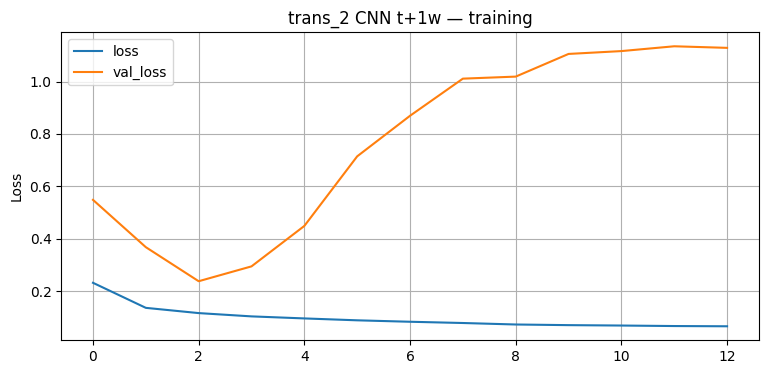

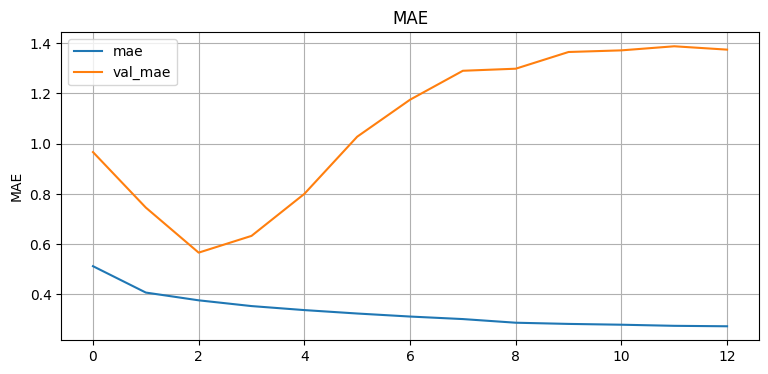

Shapes → train:(10464, 192, 6)  val:(0, 192, 6)  test:(0, 192, 6)  | window=192 stride=2
🧪 Using **TRAIN** split for visualisation/metrics (others empty).
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 933ms/step
[trans_2 CNN t+1w • train] MAE_z=0.6360  RMSE_z=0.8049  R2=0.3976 | MAE=7.50°C  RMSE=9.50°C


IntRangeSlider(value=(0, 500), description='Slice (train):', max=2000, step=10)

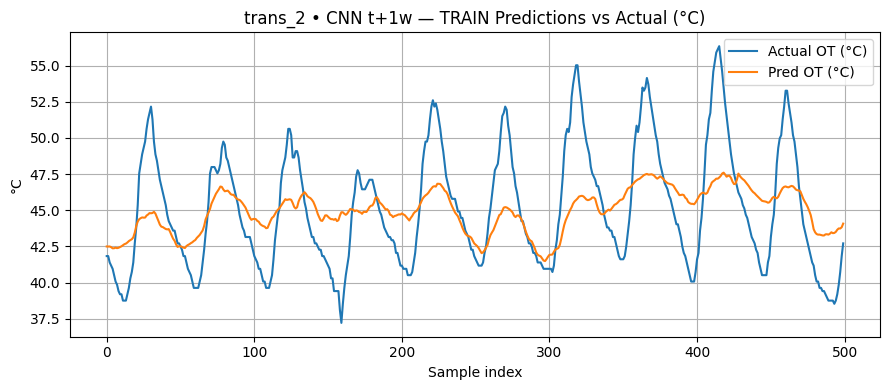

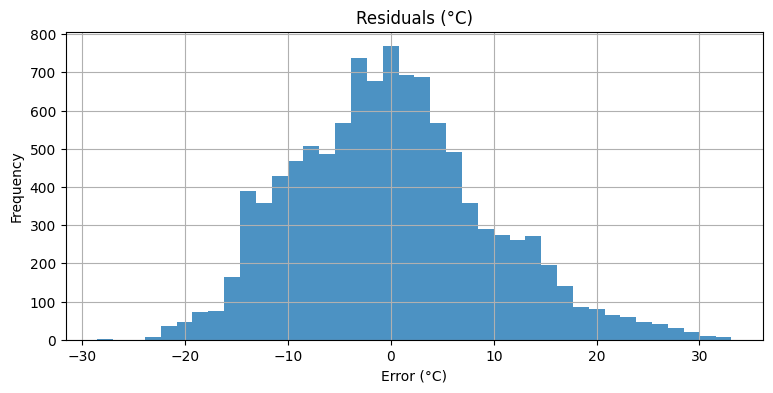

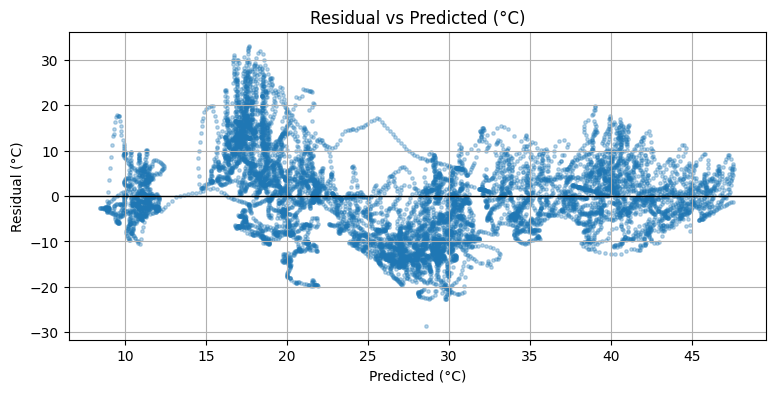

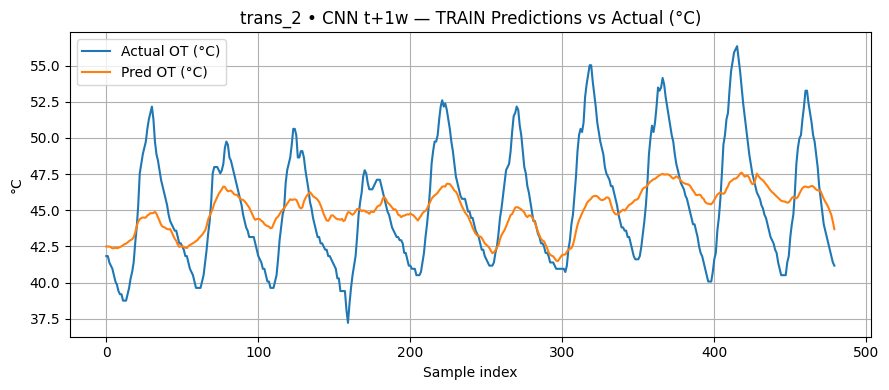

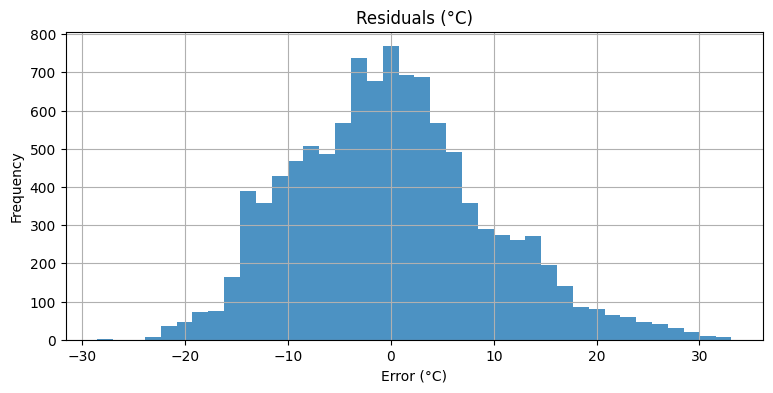

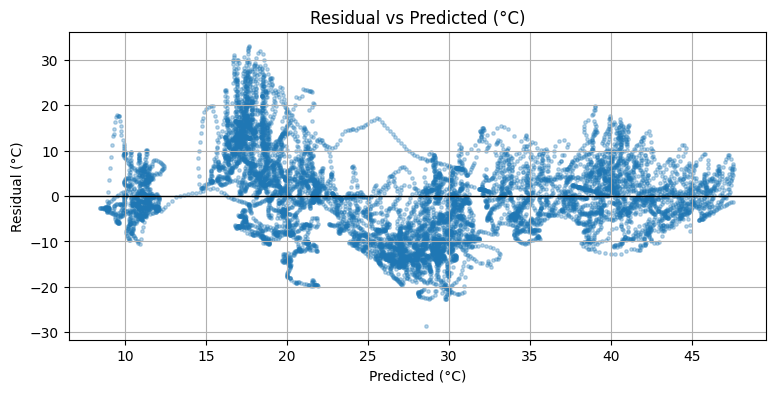

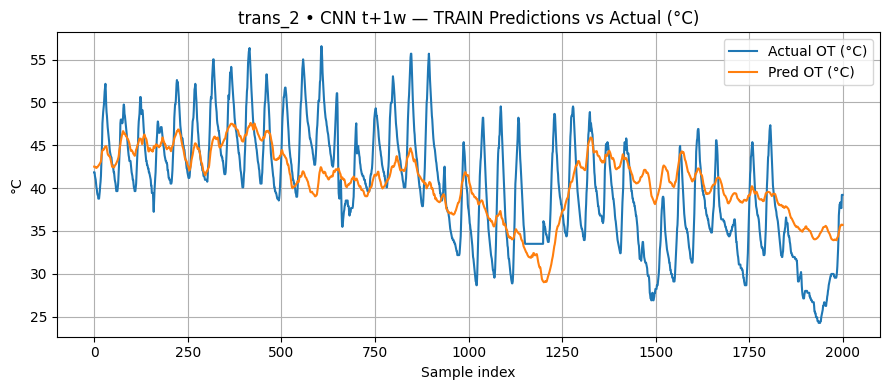

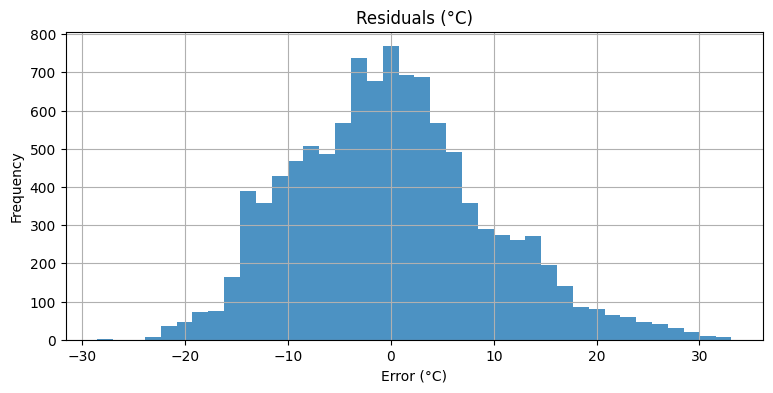

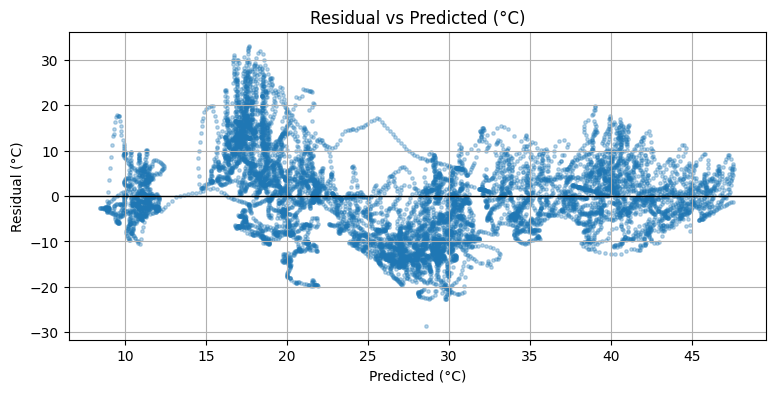

In [ ]:
# ==== CNN @ +1 week — visualisation for the AMP/XLA CNN (no long-horizon variant) ====
import os, re, glob, json, numpy as np, tensorflow as tf
from sklearn.metrics import mean_absolute_error, r2_score
import ipywidgets as W
from IPython.display import display

# --- choose transformer/horizon ---
tf_name = "trans_2"   # or "trans_2"
HKEY    = "t+1w"      # accepts "t+1w" or "t+168h"

# --- base paths ---
BASE = "/content/drive/MyDrive/Colab Notebooks/project"
RUNS = f"{BASE}/runs"

# --- required globals ---
assert all(k in globals() for k in ["stats","zdfs","idxs","INPUTS","TARGET","HORIZONS",
                                    "make_windows_np","line_preds","residual_plots"]), \
    "Run preprocessing + helper cells first (stats, zdfs, idxs, HORIZONS, etc.)."

mu_t = stats[tf_name]["tg_mu"]; sd_t = stats[tf_name]["tg_sd"]
toC  = lambda z: z*sd_t + mu_t

# --- alias helper (handles 't+1w' <-> 't+168h') ---
def _aliases(hk):
    if hk == "t+1w": return ["t+1w","t+168h"]
    if hk == "t+168h": return ["t+168h","t+1w"]
    return [hk]

# --- locate latest CNN (trained via official CNN 1w script) ---
cand = []
for hk in _aliases(HKEY):
    cand += glob.glob(f"{RUNS}/{tf_name}/CNN_{hk}*.keras")
if not cand:
    # fallback: any CNN with that horizon tag
    cand = [p for p in glob.glob(f"{RUNS}/{tf_name}/CNN_*.keras")
            if any(a in p for a in _aliases(HKEY))]
assert cand, f"No CNN model found for {tf_name} @ {HKEY} in {RUNS}/{tf_name}"
model_path = max(cand, key=os.path.getmtime)
print("📦 Using model:", os.path.basename(model_path))

# --- history (optional) ---
hist_path = os.path.splitext(model_path)[0] + "_history.json"
if os.path.exists(hist_path):
    with open(hist_path) as f: hist_dict = json.load(f)
    try: plot_history(hist_dict, title=f"{tf_name} CNN {HKEY} — training")
    except Exception as e: print("plot_history skipped:", e)

# --- load model + parse window/stride used during training ---
model = tf.keras.models.load_model(model_path)
L_required = model.input_shape[1]
m = re.search(r"_s(\d+)_", os.path.basename(model_path))
stride_used = int(m.group(1)) if m else 1

# --- build X/y for exact L & stride ---
def _build_xy(tf_name, hkey, L_override, stride):
    hkey_real = "t+168h" if (hkey == "t+1w" and "t+1w" not in HORIZONS) else hkey
    offset, gap = HORIZONS[hkey_real]
    X_in  = zdfs[tf_name][INPUTS].to_numpy(np.float32)
    y_out = zdfs[tf_name][[TARGET]].to_numpy(np.float32).ravel()
    out = {}
    for split in ["train","val","test"]:
        rows = idxs[tf_name][split]
        X, y = make_windows_np(X_in, y_out, rows, L_override, offset, gap, stride)
        out[split] = (X, y)
    return out

Xy_tf = _build_xy(tf_name, HKEY, L_required, stride_used)
splits_order = ["test","val","train"]
chosen = next((s for s in splits_order if Xy_tf[s][0].size > 0), None)

if chosen is None:
    print("❌ All splits empty for this horizon/window/stride. "
          "You need ≥ (L + GAP + OFFSET) consecutive steps in a split (≈ 1632 for 1w).")
else:
    (Xsel, ysel) = Xy_tf[chosen]
    print(f"Shapes → train:{Xy_tf['train'][0].shape}  val:{Xy_tf['val'][0].shape}  test:{Xy_tf['test'][0].shape}  | "
          f"window={L_required} stride={stride_used}")
    print(f"🧪 Using **{chosen.upper()}** split for visualisation/metrics (others empty).")

    # --- predictions & metrics ---
    pred_z = model.predict(Xsel, batch_size=256).ravel()
    mae_z  = float(mean_absolute_error(ysel, pred_z))
    rmse_z = float(np.sqrt(((ysel - pred_z)**2).mean()))
    r2     = float(r2_score(ysel, pred_z)) if len(ysel) > 1 else float("nan")

    mae_C  = float(mean_absolute_error(toC(ysel), toC(pred_z)))
    rmse_C = float(np.sqrt(((toC(ysel) - toC(pred_z))**2).mean()))

    print(f"[{tf_name} CNN {HKEY} • {chosen}] MAE_z={mae_z:.4f}  RMSE_z={rmse_z:.4f}  R2={r2:.4f} | "
          f"MAE={mae_C:.2f}°C  RMSE={rmse_C:.2f}°C")

    # --- interactive visualisation ---
    W.IntSlider()  # warm widgets
    slider = W.IntRangeSlider(value=[0, min(500, len(ysel))],
                              min=0, max=min(2000, len(ysel)),
                              step=10, description=f"Slice ({chosen}):")
    def _show(_):
        s0, s1 = slider.value
        line_preds(ysel, pred_z, mu_t, sd_t,
                   start=s0, length=max(50, s1 - s0),
                   title=f"{tf_name} • CNN {HKEY} — {chosen.upper()} Predictions vs Actual (°C)")
        residual_plots(ysel, pred_z, mu_t, sd_t)
    slider.observe(_show, names="value")
    display(slider)
    _show(None)


#Export

In [ ]:
import shutil, os

export_dir = "/content/drive/MyDrive/Colab Notebooks/project/exported_models"
os.makedirs(export_dir, exist_ok=True)

for tf_name in ["trans_1", "trans_2"]:
    src_dir = f"/content/drive/MyDrive/Colab Notebooks/project/runs/{tf_name}"
    for fname in os.listdir(src_dir):
        if fname.endswith(".keras"):
            shutil.copy(os.path.join(src_dir, fname),
                        os.path.join(export_dir, f"{tf_name}_{fname}"))

print("✅ Exported models to:", export_dir)


✅ Exported models to: /content/drive/MyDrive/Colab Notebooks/project/exported_models


In [ ]:
# ===== Select & export best models =====
import os, re, json, shutil, glob, pathlib, numpy as np, tensorflow as tf

RUNS = "/content/drive/MyDrive/Colab Notebooks/project/runs"  # change if needed
EXPORT_DIR = os.path.join(RUNS, "exports")
os.makedirs(EXPORT_DIR, exist_ok=True)

# ---- helpers ----
FAMILY_RE = re.compile(r"/(trans_[12])/(CNN|GRU|LSTM)_(t\+\d+h|t\+\dw)_")

def _meta_from_path(p: str):
    """Return (transformer, family, horizon) parsed from filename or None if not matched."""
    m = FAMILY_RE.search(p.replace("\\", "/"))
    if not m:
        return None
    return m.group(1), m.group(2), m.group(3)

def _summary_from_path(keras_path: str):
    base = os.path.splitext(keras_path)[0]
    s_path = base + "_summary.json"
    h_path = base + "_history.json"
    meta = {"summary_path": None, "history_path": None,
            "val_loss": None, "train_best_loss": None,
            "MAE_C": None, "MAE_z": None, "eval_split": None}
    if os.path.exists(s_path):
        meta["summary_path"] = s_path
        try:
            with open(s_path) as f:
                s = json.load(f)
            meta["val_loss"] = s.get("val_loss")
            meta["train_best_loss"] = s.get("train_best_loss")
            meta["MAE_C"] = s.get("MAE_C")
            meta["MAE_z"] = s.get("MAE_z")
            meta["eval_split"] = s.get("eval_split")
        except Exception:
            pass
    if os.path.exists(h_path):
        meta["history_path"] = h_path
    return meta

def _score(summary: dict):
    """
    Build a sortable score:
      1) val_loss if present
      2) else train_best_loss
      3) tie-breaker by MAE_C if present
    Returns a tuple; Python sorts lexicographically.
    """
    # Use big fallback numbers when missing
    val = summary.get("val_loss")
    trn = summary.get("train_best_loss")
    maeC = summary.get("MAE_C")
    return (
        val if (val is not None and np.isfinite(val)) else np.inf,
        trn if (trn is not None and np.isfinite(trn)) else np.inf,
        maeC if (maeC is not None and np.isfinite(maeC)) else np.inf,
    )

def _export_one(keras_path: str, export_root: str):
    """Copy .keras + metadata, and export a TF SavedModel (Keras 3 safe)."""
    import shutil, os, tensorflow as tf

    os.makedirs(export_root, exist_ok=True)

    # 1) copy .keras checkpoint
    dst_keras = os.path.join(export_root, os.path.basename(keras_path))
    shutil.copy2(keras_path, dst_keras)

    # 2) copy metadata if present
    base = os.path.splitext(keras_path)[0]
    for suffix in ["_summary.json", "_history.json"]:
        src = base + suffix
        if os.path.exists(src):
            shutil.copy2(src, os.path.join(export_root, os.path.basename(src)))

    # 3) export SavedModel (Keras 3: prefer model.export; fallback to save(..., 'tf'))
    sm_dir = os.path.join(export_root, "savedmodel")
    if os.path.exists(sm_dir):
        shutil.rmtree(sm_dir)

    model = tf.keras.models.load_model(keras_path)

    # Keras 3 path
    if hasattr(model, "export"):
        model.export(sm_dir)  # writes a proper TF SavedModel for serving
    else:
        # Older TF/Keras fallback
        model.save(sm_dir, save_format="tf")

    return {"keras": dst_keras, "savedmodel_dir": sm_dir}

# ---- collect all keras checkpoints ----
all_keras = glob.glob(os.path.join(RUNS, "trans_*", "*.keras"))

# ---- FILTERS: adjust ----
FILTER_HORIZON = "t+1h"     # only 1-week
FILTER_FAMILY  = "LSTM"       # only CNN; set to None for all families

candidates = []
for p in all_keras:
    meta = _meta_from_path(p)
    if not meta:
        continue
    tname, family, horizon = meta
    if FILTER_HORIZON and horizon != FILTER_HORIZON:
        continue
    if FILTER_FAMILY and family != FILTER_FAMILY:
        continue
    s = _summary_from_path(p)
    score = _score(s)
    candidates.append({
        "path": p, "transformer": tname, "family": family, "horizon": horizon,
        "score": score, **s
    })

# ---- pick the single best per (transformer, family, horizon) ----
best = {}
for c in candidates:
    key = (c["transformer"], c["family"], c["horizon"])
    if key not in best or c["score"] < best[key]["score"]:
        best[key] = c

# ---- show selections ----
if not best:
    print("No matching models found with current filters.")
else:
    print("Selected models to export:")
    for k, c in best.items():
        print(f"  - {k}: {os.path.basename(c['path'])} | score={c['score']} | "
              f"val_loss={c['val_loss']} train_best_loss={c['train_best_loss']} MAE_C={c['MAE_C']}")

    # ---- export each selection ----
    exported = {}
    for (tname, family, horizon), c in best.items():
        # export under runs/exports/<transformer>/<family>_<horizon>/
        export_root = os.path.join(EXPORT_DIR, tname, f"{family}_{horizon}")
        out = _export_one(c["path"], export_root)
        exported[(tname, family, horizon)] = out

    print("\nExports written to:")
    for k, out in exported.items():
        print(f"  - {k}:")
        print(f"      • .keras → {out['keras']}")
        print(f"      • SavedModel dir → {out['savedmodel_dir']}")


Selected models to export:
  - ('trans_1', 'LSTM', 't+1h'): LSTM_t+1h_L48_s2_u128_d0.3_Huber.keras | score=(0.12235656380653381, inf, 4.491517066955566) | val_loss=0.12235656380653381 train_best_loss=None MAE_C=4.491517066955566
  - ('trans_2', 'LSTM', 't+1h'): LSTM_t+1h_L48_s2_u128_d0.3_Huber.keras | score=(0.11572115123271942, inf, 5.130031108856201) | val_loss=0.11572115123271942 train_best_loss=None MAE_C=5.130031108856201
Saved artifact at '/content/drive/MyDrive/Colab Notebooks/project/runs/exports/trans_1/LSTM_t+1h/savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 6), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136581220705360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136581220702480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136581220705744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13658122